# Debiasing Notebook

This notebook takes in binned and cleaned Galaxy Zoo data and produces a debiased output catalogue. This notebook is based on the procedures outlined in [Hart et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.461.3663H/abstract), and original debiasing efforts hosted on the GAMA branch of [this GitHub repo](https://github.com/RossHart/Debiasing/tree/GAMA).

In [25]:
# imports
import os
import sys
import warnings
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import (
    AnchoredSizeBar as scalebar
)
from collections import Counter as counter
import scipy.stats as st
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic, gaussian_kde
from scipy.optimize import minimize, curve_fit
import copy
import astropy.stats as stats
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import imageio
import time
from sklearn.neighbors import NearestNeighbors
from voronoi_2d_binning import voronoi_2d_binning

# Notebook startup
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}
nbtf = '%Y-%m-%d %H:%M:%S %Z'
nbt0 = time.time()
nbt0str = time.strftime(nbtf, time.localtime(nbt0))
print(f'Notebook start time: \n   {nbt0str}')
#--------------------------------68-------------------------------->
# np.seterr(divide='raise')

Notebook start time: 
   2021-06-14 11:16:42 CEST


## Setup Parameters

Here we define parameters which will be used throughout the remainder of this notebook.

In [26]:
#For DeCALS-DR2
setup_file = 'debiasing-setup-decals-dr2.py'

#For DeCALS-DR5 - uncomment
#setup_file = 'debiasing-setup-decals-dr5.py'

exec(open(setup_file).read())
print('Setup file successfully sourced!\n')
if not os.path.exists(outdir):
    os.mkdir(outdir)
print(f'output directory: {outdir}\n')
print(f'input votes cat: {os.path.basename(input_votefrac_cat)}')
print(f'input extras cat: {os.path.basename(input_extraval_cat)}')
print(f'output debiased cat: {os.path.basename(output_cat)}')

Setup file successfully sourced!

output directory: /Users/skruk/Documents/Work_in_progress/Debiasing_GZ_DeCALS/Debiasting_GZ_DeCALS_after_referee/gamakidsgz/outputs/DeCALS_debiasing/Debiasing_GZ_DECaLS/data/DR2

input votes cat: current_final_dr2_result_extra_n30.fits
input extras cat: current_final_dr2_result_extra_n30.fits
output debiased cat: current_final_dr2_result_debiased.fits.gz


## Data Read, Setup and Pre-Debiasing Analysis Plots

First, we read in the cleaned and associated extra information datasets. Simple analysis is performed, to verify the input data.

In [27]:
# z to dist
def z_to_dist(z):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    return cosmo.luminosity_distance(z)

In [28]:
# mag to Mag
def mag_to_Mag(mag, z):
    D = z_to_dist(z)
    Mag = mag - 5*(np.log10(D/(u.pc))-1)
    return Mag

In [29]:
# read in tabular data
gama_cln = Table.read(input_extraval_cat)
gama_ext = Table.read(input_extraval_cat)
if any(gama_cln[input_votefrac_id] != gama_ext[input_extraval_id]):
    raise ValueError("input catalogues must be row matched!")

In [30]:
# generate primary data table
data = gama_cln.copy()
for c in (Mr_column, R50_column, z_column):
    if c in list(gama_ext.columns):
        data[c] = gama_ext[c]
data_original = data.copy()
R50 = data_original[R50_column]
Mr = data_original[Mr_column]
z = data_original[z_column]
# znums = dict()
# for zlo,zhi in zip(volume_redshift_bounds[:-1],
#                    volume_redshift_bounds[1:]):
#     key = f'{round(zlo,5)} ≤ z ≤ {round(zhi,5)}'
#     value = sum((z>=zlo) & (z<=zhi))
#     znums.update({key:value})
# print(f'redshift bin number counts:')
# display(znums)
data = Table.from_pandas(data.to_pandas().fillna(0))
print(f'total number of input objects: {len(data)}')

#Limit data to N=30 volunteers to the first question

data = data[data["smooth-or-featured_total-votes"]>=30]
print(f'total number of input objects: {len(data)}')

total number of input objects: 88298
total number of input objects: 88298


In [31]:
# visualise first couple of objects in data table
oldnrows = pd.options.display.max_rows
oldcolwidth = pd.options.display.max_colwidth
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 30
display(data.to_pandas().head(2).T)
pd.options.display.max_rows = oldnrows
pd.options.display.max_colwidth = oldcolwidth

0  \
iauname                                b'J103438.28-005109.6'   
ra                                                     158.66   
dec                                                  -0.85268   
redshift                                            0.0737827   
elpetro_absmag_r                                      -21.084   
sersic_nmgy_r                                         520.811   
petro_th50                                            2.88914   
petro_th90                                            6.54693   
petro_theta                                           5.98512   
upload_group                                    b'pre_active'   
active_learning_on                                      False   
in_gzd_c                                                 True   
jpeg_loc                        b'/media/walml/beta/galaxy...   
smooth-or-featured_total-votes                             39   
smooth-or-featured_smooth                                  19   
smooth-or-featured_smooth_f...                       0.487179   
smooth-or-featured_featured...                             15   
smooth-or-featured_featured...                       0.384615   
smooth-or-featured_artifact                                 5   
smooth-or-featured_artifact...                       0.128205   
how-rounded_total-votes                                    19   
how-rounded_completely                                     16   
how-rounded_completely_frac...                       0.842105   
how-rounded_in-between                                      2   
how-rounded_in-between_frac...                       0.105263   
how-rounded_cigar-shaped                                    1   
how-rounded_cigar-shaped_fr...                      0.0526316   
disk-edge-on_total-votes                                   15   
disk-edge-on_yes                                            2   
disk-edge-on_yes_fraction                            0.133333   
disk-edge-on_no                                            13   
disk-edge-on_no_fraction                             0.866667   
edge-on-bulge_total-votes                                   2   
edge-on-bulge_rounded                                       2   
edge-on-bulge_rounded_fraction                              1   
edge-on-bulge_boxy                                          0   
edge-on-bulge_boxy_fraction                                 0   
edge-on-bulge_none                                          0   
edge-on-bulge_none_fraction                                 0   
bar_total-votes                                            13   
bar_yes                                                     1   
bar_yes_fraction                                    0.0769231   
bar_no                                                     12   
bar_no_fraction                                      0.923077   
has-spiral-arms_total-votes                                13   
has-spiral-arms_yes                                         8   
has-spiral-arms_yes_fraction                         0.615385   
has-spiral-arms_no                                          5   
has-spiral-arms_no_fraction                          0.384615   
spiral-winding_total-votes                                  8   
spiral-winding_tight                                        4   
spiral-winding_tight_fraction                             0.5   
spiral-winding_medium                                       4   
spiral-winding_medium_fraction                            0.5   
spiral-winding_loose                                        0   
spiral-winding_loose_fraction                               0   
spiral-arm-count_total-votes                                8   
spiral-arm-count_1                                          0   
spiral-arm-count_1_fraction                                 0   
spiral-arm-count_2                                          5   
spiral-arm-count_2_fraction                             0.625   
spiral-arm-count_3            

In [32]:
# 2D kernel density estimator
def kde2d(x, y, xlim = None, ylim = None, nx = 25, ny = 25,
          sigma = None, xlog = False, ylog = False,
          levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]):
    """2D kernel density estimator."""
    old = np.seterr(invalid='ignore')
    xlim = [np.nanmin(x), np.nanmax(x)] if xlim is None else xlim
    ylim = [np.nanmin(y), np.nanmax(y)] if ylim is None else ylim
    if xlog:
        x = np.log10(x)
        xlim = np.log10(xlim)
    if ylog:
        y = np.log10(y)
        ylim = np.log10(ylim)
    bins = [int(nx), int(ny)]
    range = [sorted(np.asarray(xlim)), sorted(np.asarray(ylim))]
    Z, X, Y = np.histogram2d(x, y, bins, range)
    if xlog:
        X = 10**X
    if ylog:
        Y = 10**Y
    X = (X[1:] + X[:-1]) / 2
    Y = (Y[1:] + Y[:-1]) / 2
    sigma=[np.sqrt(nx)/5,np.sqrt(ny)/5] if sigma is None else sigma
    Z = gaussian_filter(Z, sigma)
    L = []
    if levels:
        V = sorted(np.ravel(Z))
        C = np.cumsum(V)
        for lvl in levels:
            L.append(V[np.abs(C - (C[-1]*lvl)).argmin()])
    np.seterr(**old)
    return X, Y, Z.T, [xlim, ylim], L

/Users/skruk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/Users/skruk/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


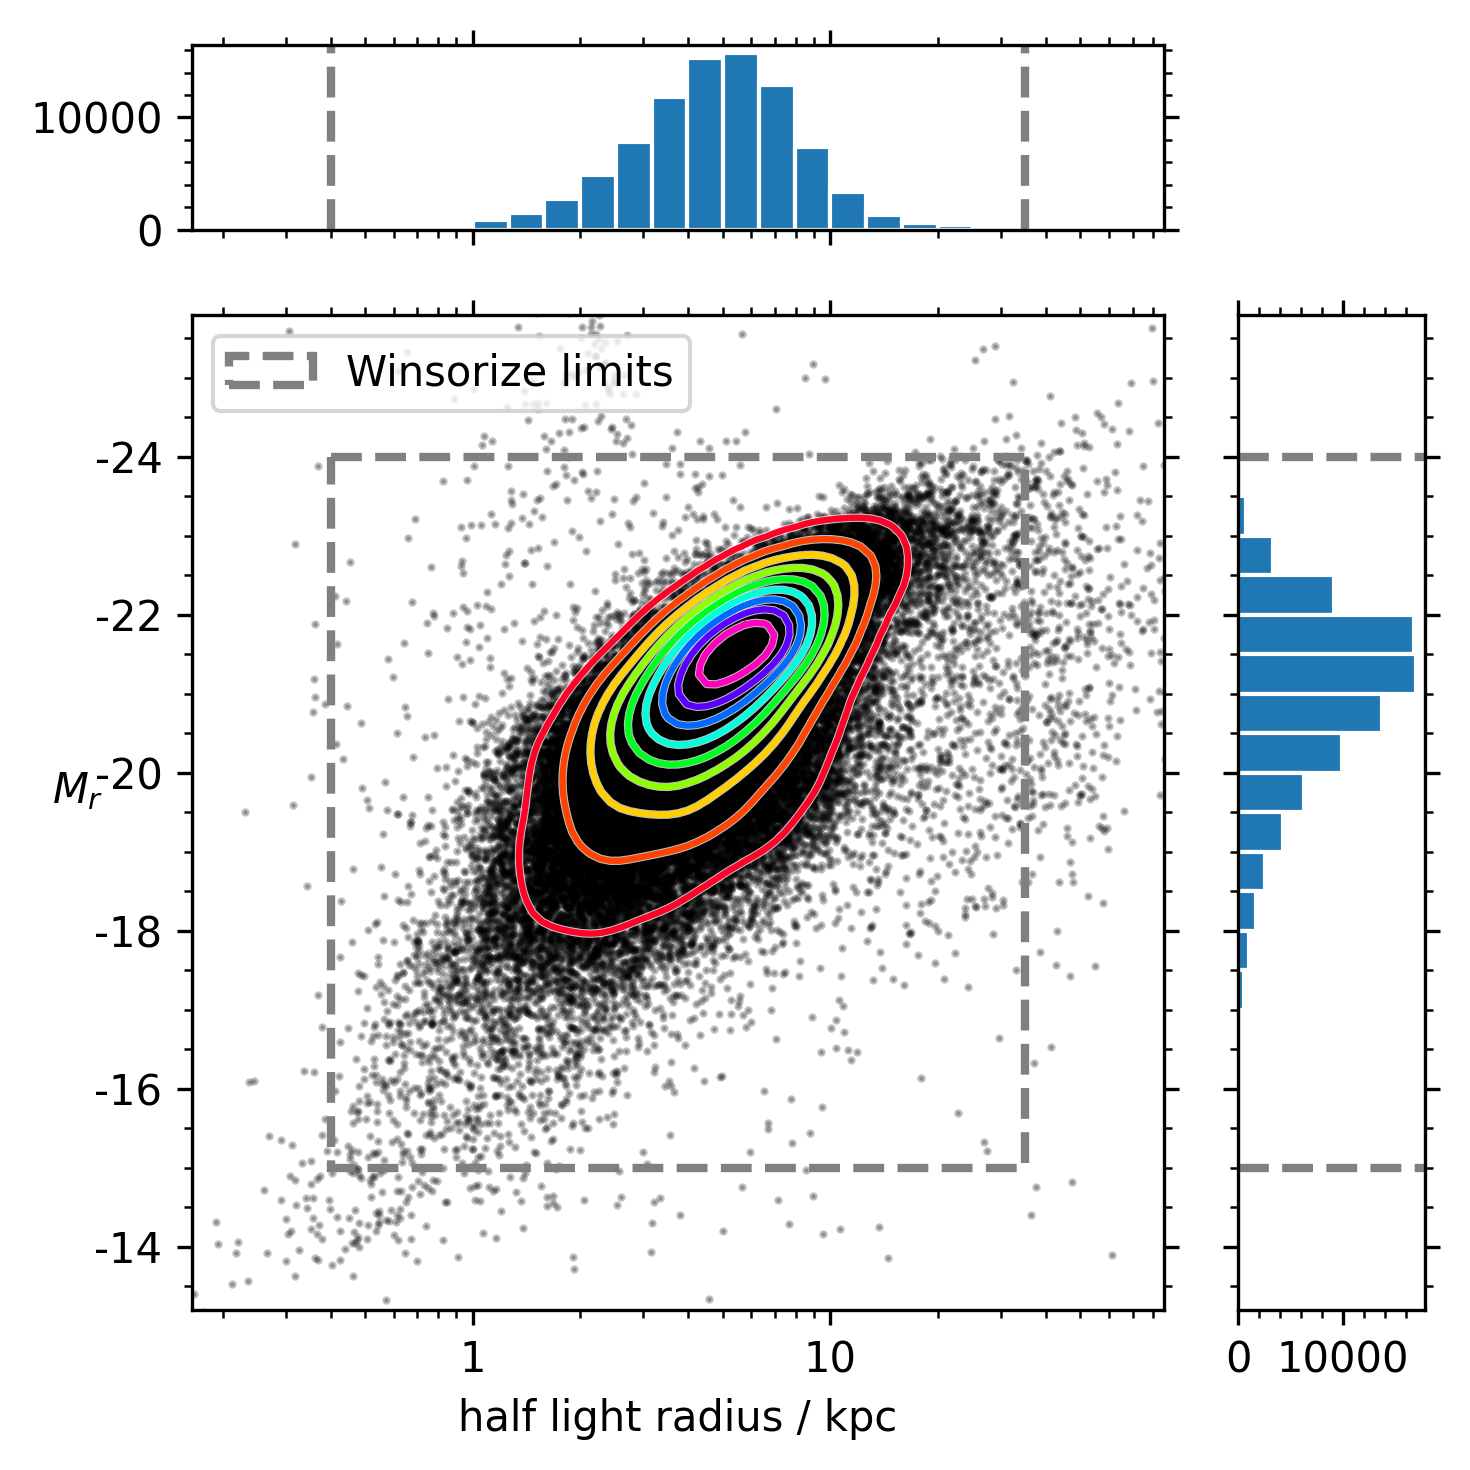

In [33]:
# size-magnitude plot
def minmax(x): return [np.nanmin(x), np.nanmax(x)]
def extendrange(x,f=0.05):u,v=minmax(x);d=(v-u)*(1+f);return v-d,u+d
size = data_original[R50_column]
mag = data_original[Mr_column]
winsorColor = 'grey'
sizeLim = [R50lo,R50hi]
magLim = [Mrlo,Mrhi]
outerSizeLim = 10**np.array(extendrange(np.log10(sizeLim), f=0.2))
outerMagLim = extendrange(magLim, f=0.2)[::-1]
X, Y, Z, extent, L = kde2d(size, mag, outerSizeLim, outerMagLim,
                           xlog=True, nx=101, ny=101)

fig = plt.figure(figsize=(5,5), dpi=dpi)
gs = matplotlib.gridspec.GridSpec(5, 5, figure=fig)
fmt = matplotlib.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))

ax = fig.add_subplot(gs[-4:,:4])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.scatter(size, mag, c='k', s=1, alpha=0.25, label='')
ax.contour(X, Y, Z, L, colors='white', alpha=0.75, linewidths=2)
ax.contour(X, Y, Z, L, cmap='gist_rainbow', alpha=1)
rect = matplotlib.patches.Rectangle((sizeLim[0], magLim[0]),
                                    np.diff(sizeLim),
                                    np.diff(magLim),
                                    linewidth=2,
                                    edgecolor=winsorColor,
                                    facecolor='none',
                                    linestyle='--', 
                                    label='Winsorize limits',)
ax.add_patch(rect)
ax.set_xscale('log')
ax.set_xlabel('half light radius / kpc')
ax.set_ylabel('$M_r$', rotation=0)
ax.set_xlim(outerSizeLim)
ax.set_ylim(outerMagLim)
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.legend(loc='upper left')

ax = fig.add_subplot(gs[0,:4])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.set_xlim(outerSizeLim)
ax.hist(size, bins=np.logspace(-3, 4, 71), log=False, label='',
        edgecolor='white', color=cols[1])
plt.axvline(sizeLim[0], c='white', ls='-', lw=5)
plt.axvline(sizeLim[1], c='white', ls='-', lw=5)
plt.axvline(sizeLim[0], c=winsorColor, ls='--', lw=2)
plt.axvline(sizeLim[1], c=winsorColor, ls='--', lw=2)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.set_xticklabels([])

ax = fig.add_subplot(gs[-4:,4])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.set_ylim(outerMagLim)
ax.hist(mag, bins=np.arange(-30,-9,0.5), log=False, label='',
        edgecolor='white', color=cols[1], orientation='horizontal')
plt.axhline(magLim[0], c='white', ls='-', lw=5)
plt.axhline(magLim[1], c='white', ls='-', lw=5)
plt.axhline(magLim[0], c=winsorColor, ls='--', lw=2)
plt.axhline(magLim[1], c=winsorColor, ls='--', lw=2)
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.set_yticklabels([])

plt.tight_layout()
plt.savefig(fname=outdir+'/sizemag.png', dpi='figure')
plt.show()
plt.close()

/Users/skruk/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


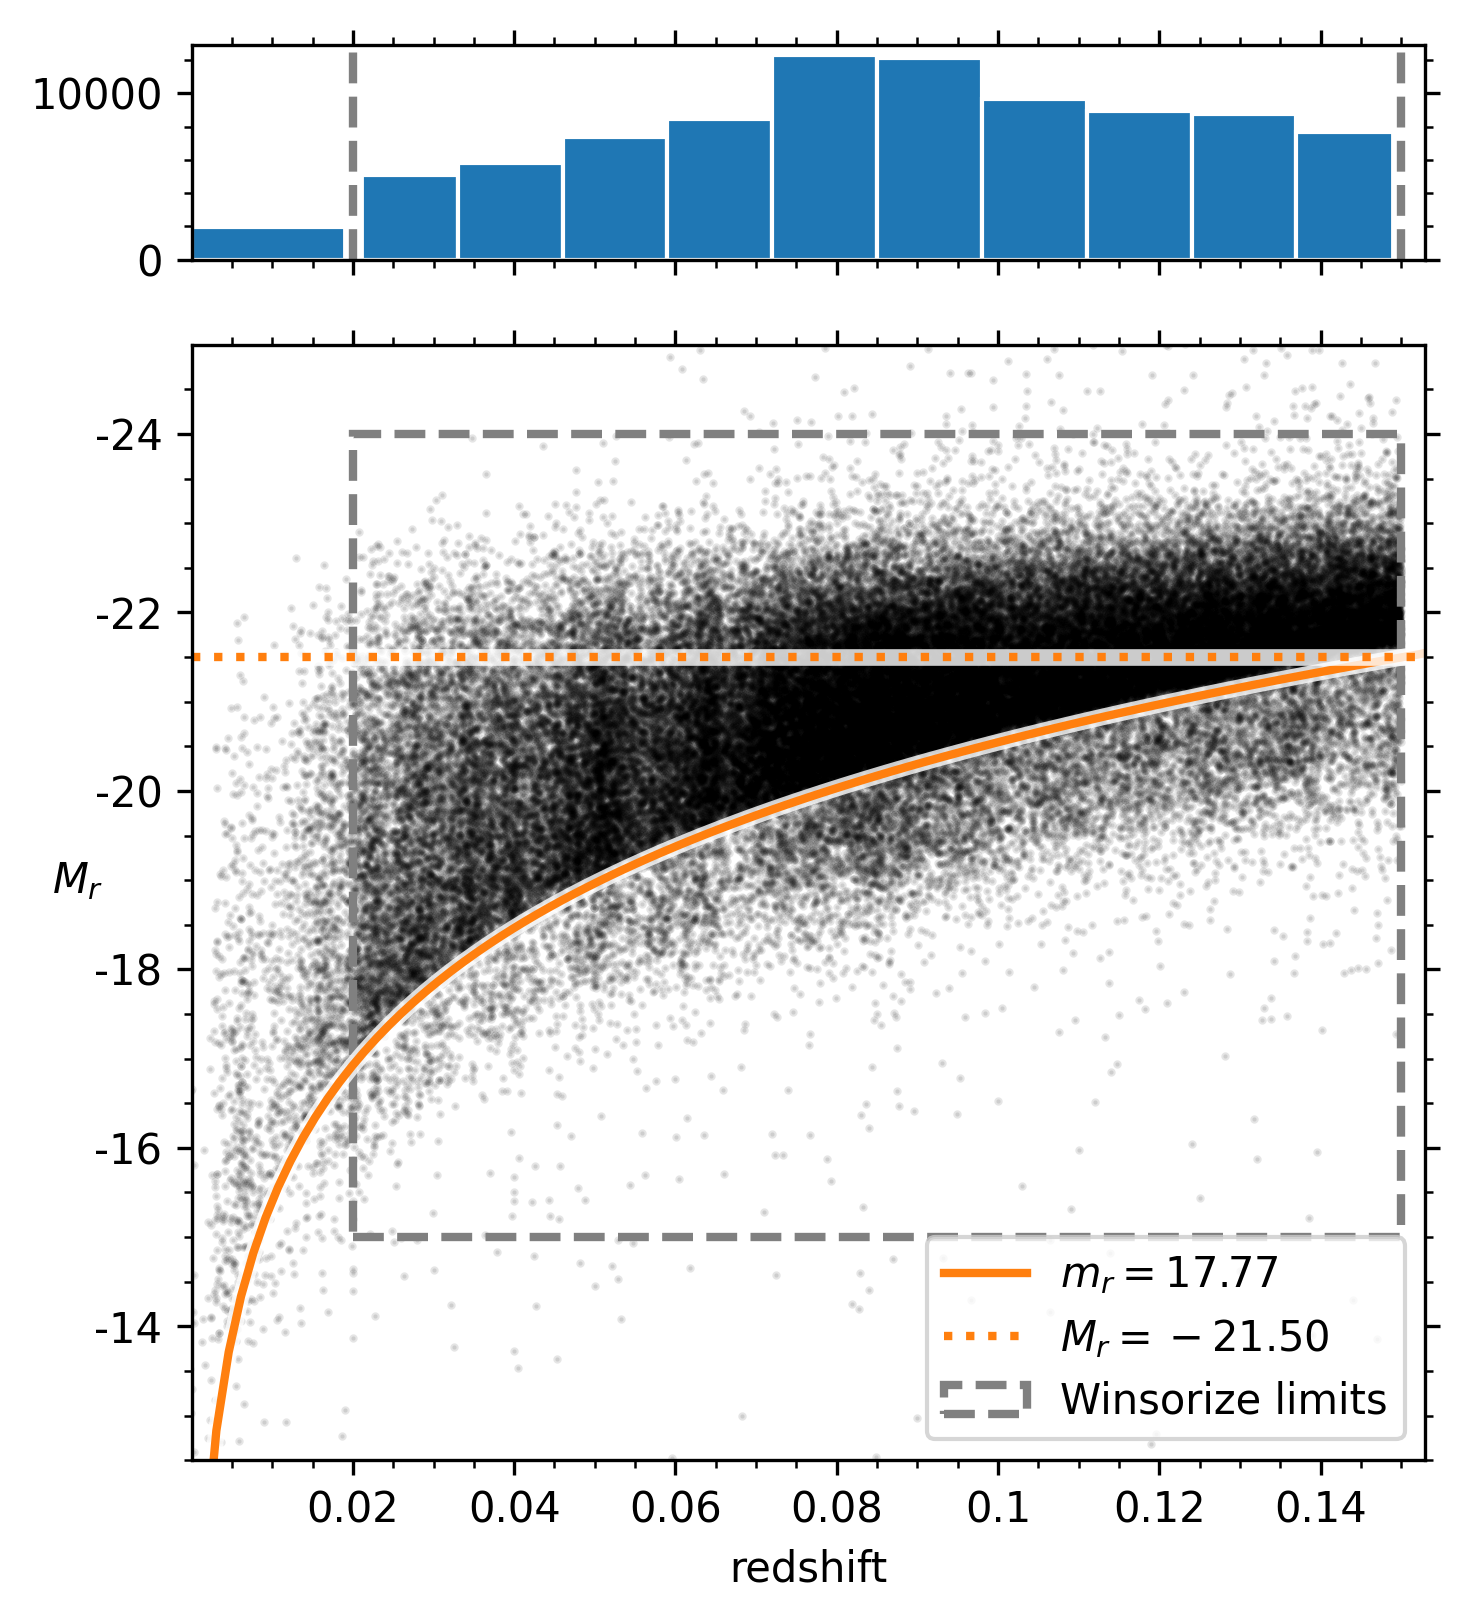

In [34]:
# redshift-magnitude plot
z = data_original[z_column]
mag = data_original[Mr_column]
winsorColor = 'grey'
outerZLim = [1e-5, volume_redshift_bounds[-1]+0.003]
magLim = [Mrhi, Mrlo]
outerMagLim = [magLim[0]+2.5, magLim[1]-1]
MagComplete = mag_to_Mag(survey_mag_limit,
                         np.max(volume_redshift_bounds))
lw = 2

fig = plt.figure(figsize=(5,5.5), dpi=dpi)
gs = matplotlib.gridspec.GridSpec(5, 1, figure=fig)
fmt = matplotlib.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))

ax = fig.add_subplot(gs[-4:,:])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.scatter(z, mag, c='k', s=1, alpha=0.1, label='')
ax.set_xlabel('redshift')
ax.set_ylabel('$M_r$', rotation=0)
ax.set_xlim(outerZLim)
ax.set_ylim(outerMagLim)
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
zs = np.linspace(outerZLim[0], outerZLim[1], 101)
Mlims = mag_to_Mag(survey_mag_limit, zs)
ax.plot(zs, Mlims, c='w', lw=lw+2, label='', alpha=0.8)
ax.plot(zs, Mlims,c=cols[0],lw=lw,label=f'$m_r={survey_mag_limit}$')
ax.axhline(MagComplete, c='w', ls='solid', lw=lw+2,
           label='', alpha=0.8)
ax.axhline(MagComplete, c=cols[0], ls='dotted', lw=lw,
           label=f'$M_r={MagComplete:.02f}$')
# ax.axvline(volume_redshift_bounds[0],c='w',ls='solid',lw=lw+2,
#            label='', alpha=0.8)
# ax.axvline(volume_redshift_bounds[0],c=winsorColor,ls='--',lw=lw,
#            label='')
# ax.axvline(volume_redshift_bounds[-1],c='w',ls='solid',lw=lw+2,
#            label='', alpha=0.8)
# ax.axvline(volume_redshift_bounds[-1],c=winsorColor,ls='--',lw=lw,
#            label='Winsorize limits')
rect = matplotlib.patches.Rectangle((volume_redshift_bounds[0],
                                     magLim[0]),
                                    np.diff(volume_redshift_bounds),
                                    np.diff(magLim),
                                    linewidth=2,
                                    edgecolor=winsorColor,
                                    facecolor='none',
                                    linestyle='--', 
                                    label='Winsorize limits',)
ax.add_patch(rect)
ax.legend(loc='lower right')

ax = fig.add_subplot(gs[:-4,:])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
histZBins = [0]+list(np.linspace(volume_redshift_bounds[0],
                                 volume_redshift_bounds[-1], 11))
if np.max(volume_redshift_bounds) < np.max(z):
    histZBins += [np.max(z)]
ax.hist(z, bins=histZBins, log=False, label='',
        edgecolor='white', color=cols[1])
ax.axvline(volume_redshift_bounds[0],c='w',ls='-',lw=lw+3,label='')
ax.axvline(volume_redshift_bounds[0],c=winsorColor,ls='--',lw=lw,
           label='')
ax.axvline(volume_redshift_bounds[-1],c='w',ls='-',lw=lw+3,label='')
ax.axvline(volume_redshift_bounds[-1],c=winsorColor,ls='--',lw=lw,
           label='Winsorize limits')
ax.set_xlim(outerZLim)
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.set_xticklabels([])

plt.tight_layout()
plt.savefig(fname=outdir+'/redshiftmag.png', dpi='figure')
plt.show()
plt.close()

In [35]:
# winsorize/trim/clip data to R50/Mr/z min/max ranges
R50 = data_original[R50_column]
Mr = data_original[Mr_column]
z = data_original[z_column]
R50_ok = np.all([R50 >= R50lo, R50 <= R50hi], axis=0)
Mr_ok = np.all([Mr >= Mrlo, Mr <= Mrhi], axis=0)
z_ok = np.all([z >= volume_redshift_bounds[0],
               z <= volume_redshift_bounds[-1]], axis=0)
data_ok = (R50_ok) & (Mr_ok) & (z_ok)
data[R50_column] = np.clip(data[R50_column], R50lo, R50hi)
data[Mr_column] = np.clip(data[Mr_column], Mrlo, Mrhi)
data[z_column]=np.clip(data[z_column],
                       volume_redshift_bounds[0],
                       volume_redshift_bounds[-1])
print(f'Winsorizing data in R50/Mr/z space')
print(f'  R50_ok: {sum(R50_ok)} / {len(R50_ok)} '
      f'({sum(~R50_ok)} winsorized)')
print(f'   Mr_ok: {sum(Mr_ok)} / {len(Mr_ok)} '
      f'({sum(~Mr_ok)} winsorized)')
print(f'    z_ok: {sum(z_ok)} / {len(z_ok)} '
      f'({sum(~z_ok)} winsorized)')
print(f'total_ok: {sum(data_ok)} / {len(data_ok)} '
      f'({sum(~data_ok)} winsorized)')

Winsorizing data in R50/Mr/z space
  R50_ok: 87659 / 88298 (639 winsorized)
   Mr_ok: 87864 / 88298 (434 winsorized)
    z_ok: 86344 / 88298 (1954 winsorized)
total_ok: 85618 / 88298 (2680 winsorized)


## Question / Answer Dictionary

From Ross Hart: here, you can adjust what the questions are to be debiased, and their order. Note that the order does matter, you need to debias the questions further up the tree than the question you are currently debiasing.

In [36]:
# Put all of this together in a single question dict
question_dict = dict()
for s in range(len(q)):
    # setup possible answers and required questions
    if req_q[s] is not None:
        rq = [q[v] for v in req_q[s]] 
    else:
        rq = None
    question_dict[q[s]] = {'lbl_question': lbl_q[s],
                           'pos_answers': a[s],
                           'lbl_answers': lbl_a[s],
                           'req_questions': rq,}
    # add required answers
    if req_a[s] is not None:
        ra_array = [question_dict[q[v]]['pos_answers'] 
                    for v in req_q[s]]
        answer_arrays = [ra_array[v] 
                         for v in range(len(req_a[s]))]
        answer_indices = [req_a[s][v] 
                          for v in range(len(req_a[s]))]
        ra = [answer_arrays[v2][answer_indices[v2]] 
              for v2 in range(len(answer_indices))]
    else:
        ra = None # if there are no required questions
    question_dict[q[s]].update({'req_answers': ra})
    # add not-req answers (i.e., to be 1-p later on)
    if not_a[s] is not None:
        na_array = [question_dict[q[v]]['pos_answers']
                    for v in req_q[s]]
        answer_arrays = [na_array[v]
                         for v in range(len(not_a[s]))]
        answer_indices = [not_a[s][v]
                          for v in range(len(not_a[s]))]
        na = [answer_arrays[v2][answer_indices[v2]]
              for v2 in range(len(answer_indices))]
    else:
        na = None
    question_dict[q[s]].update({'not_answers': na})

In [37]:
# print questions dict
print(f'question_dict:\n**************')
for i, key in enumerate(question_dict):
    print(f'\nT{i:02} : {key}')
    print(f' full label: {question_dict[key]["lbl_question"]}')
    print(f' possible answers:\n  '
          f'{question_dict[key]["pos_answers"]}')
    print(f' answer labels:\n  '
          f'{question_dict[key]["lbl_answers"]}')
    print(' required prior Q/A pairs:')
    if question_dict[key]['req_questions'] is not None:
        for i, rq in enumerate(question_dict[key]['req_questions']):
            if question_dict[key]['req_answers'] is not None:
                ra = question_dict[key]['req_answers'][i]
            else:
                ra = f'NOT {question_dict[key]["not_answers"][i]}'
            print(f'  {rq:>18} : {ra}')
    else:
        print(f'  {"None":>18} : None')
    #display(question_dict[key])

question_dict:
**************

T00 : smooth-or-featured
 full label: smooth, featured, or artifact?
 possible answers:
  ['smooth', 'featured-or-disk', 'artifact']
 answer labels:
  ['smooth', 'featured', 'star/artifact']
 required prior Q/A pairs:
                None : None

T01 : disk-edge-on
 full label: edge-on disk?
 possible answers:
  ['yes', 'no']
 answer labels:
  ['edge-on', 'face-on/inclined']
 required prior Q/A pairs:
  smooth-or-featured : featured-or-disk

T02 : bar
 full label: barred?
 possible answers:
  ['no', 'yes']
 answer labels:
  ['unbarred', 'barred']
 required prior Q/A pairs:
  smooth-or-featured : featured-or-disk
        disk-edge-on : no

T03 : has-spiral-arms
 full label: spiral arm pattern?
 possible answers:
  ['no', 'yes']
 answer labels:
  ['no spiral arms', 'spiral arms']
 required prior Q/A pairs:
  smooth-or-featured : featured-or-disk
        disk-edge-on : no

T04 : bulge-size
 full label: bulge size?
 possible answers:
  ['none', 'obvious', 'do

## Function & Inverse Function Dictionary

From Ross Hart: First we define the functions (and their respective inverses), then we construct a dictionary which lists all of the functions and bounds to be used in the to fit the data.

In [38]:
def f_logistic(x, k, c):
    # Function to fit the data bin output from the raw plot func.
    L = (1 + np.exp(c))
    r = L / (1.0 + np.exp(-k * x + c))
    return r

def f_exp_pow(x, k, c):
    # Function to fit the data bin output from the raw plot func.
    r = np.exp(-k * (-x) ** c)
    return r

def i_f_logistic(y, k, c):
    # inverse of f_logistic
    L = (1 + np.exp(c))
    x = -(np.log(L / y - 1) - c) / k
    return x

def i_f_exp_pow(y, k, c):
    # inverse of f_exp_pow
    k[np.isnan(k)] = 0
    ok = k > 0
    x = np.zeros_like(y) - np.inf
    logyok = (np.ma.log(y[ok]).filled(np.nan)).data
    x[ok] = -(-logyok / k[ok] )**(1.0 / c[ok])
    return x
function_dict = {}
function_dict['func'] = {0: f_logistic,
                         1: f_exp_pow,
                         }
function_dict['bounds'] = {0: logistic_bounds,
                           1: exponential_bounds,
                           }
function_dict['p0'] = {0: [3,-3],
                       1: [2,1],
                       }
function_dict['i_func'] = {0: i_f_logistic,
                           1: i_f_exp_pow,
                           }
function_dict['label'] = {0: 'logistic',
                          1: 'exp. power',
                          }

## Sampling Functions

This section provides methods which trim, bin and manipulate sample data.

In [39]:
# sample class: trims and manipulates data
class Sample():

    def __init__(self, full_data, question_dict, 
                 question='shape', p_cut=p_cut, N_cut=N_cut, 
                 use_normalised=False):
        logDat = np.log10(full_data[R50_column])-np.log10(R50lo)+1
        full_data['LOGR50'] = logDat
        if use_normalised == True:
            suffix = output_frac_suffix + '_norm'
        else:
            suffix = output_frac_suffix
        req_q = question_dict[question]['req_questions']
        req_a = question_dict[question]['req_answers']
        not_a = question_dict[question]['not_answers']
        if req_q is not None:
            p_col = np.ones(len(full_data))
            if req_a is not None:
                for q, a in zip(req_q, req_a):
                    prior_p = full_data[q + '_' + a + suffix]
                    if p_type == 'multiplicative':
                        p_col = p_col * prior_p
                    elif p_type == 'additive':
                        p_col[prior_p < p_cut] = 0
            else:
                for q, a in zip(req_q, not_a):
                    prior_p = 1 - full_data[q + '_' + a + suffix]
                    if p_type == 'multiplicative':
                        p_col = p_col * prior_p
                    elif p_type == 'additive':
                        p_col[prior_p < p_cut] = 0
            N_col = full_data[question + input_total_suffix]
            select = (p_col >= p_cut) & (N_col >= N_cut)
            less_data = full_data[select]
            print(f'{np.sum(p_col >= p_cut)} galaxies with '
                  f'p>={p_cut}')
            print(f'{np.sum(N_col >= N_cut)} galaxies with '
                  f'N>={N_cut}')
            print(f'{len(less_data)}/{len(full_data)} galaxies '
                  f'with p>={p_cut} and N>={N_cut}.')
        else:
            less_data = full_data.copy()
            select = np.ones(len(full_data), dtype=np.bool)
            print(f'First tier question, so all {len(less_data)} '
                  f'galaxies used.')
        self.all_data = full_data
        self.less_data = less_data
        self.p_mask = select
        return None

    def volume_limited_sample(self):
        lower_z_limit = volume_redshift_bounds[0]
        upper_z_limit = volume_redshift_bounds[-1]
        mag_limit = survey_mag_limit
        Mag_limit = mag_to_Mag(mag_limit, upper_z_limit)
        in_vl = np.all([self.all_data[z_column] >= lower_z_limit,
                        self.all_data[z_column] <= upper_z_limit,
                        self.all_data[Mr_column] <= Mag_limit],
                        axis=0)
        self.in_volume_limit = in_vl
        self.Mag_limit = Mag_limit
        return in_vl

#     def z_slices(self):
#         in_vl = self.volume_limited_sample()        
#         lower_z_limits = [volume_redshift_bounds[0], 
#                           volume_redshift_bounds[1]]
#         upper_z_limits = [volume_redshift_bounds[-2], 
#                           volume_redshift_bounds[-1]]
#         in_lo_z = np.all([self.all_data[z_column] 
#                           >= lower_z_limits[0],
#                           self.all_data[z_column] 
#                           <= lower_z_limits[1]], 
#                          axis=0)
#         in_hi_z = np.all([self.all_data[z_column] 
#                           >= upper_z_limits[0],
#                           self.all_data[z_column] 
#                           <= upper_z_limits[1]], 
#                          axis=0)
#         return ((in_vl*in_lo_z).astype(bool), 
#                 (in_vl*in_hi_z).astype(bool))

In [40]:
# sample bin class
class Bins():

    def __init__(self, sample, 
                 question='shape', answer='smooth'):
        self.n_voronoi = n_voronoi
        self.n_per_z = n_per_z
        self.Mr = sample.less_data[Mr_column]
        self.R50 = sample.less_data['LOGR50']
        self.z = sample.less_data[z_column]
        self.Mr_all = sample.all_data[Mr_column]
        self.R50_all = sample.all_data['LOGR50']
        self.z_all = sample.all_data[z_column]
        self.n_min = low_signal_limit
        self.z_low_limit = volume_redshift_bounds[0]
        self.sample = sample
        self.question = question
        self.answer = answer
        savedir = outdir + question + answer
        self.savedir = savedir
        return None

    def voronoi_bin(self, save=False):
        Mr = self.Mr
        R50 = self.R50
        n_gal = len(Mr)
        n_rect_bins = (math.sqrt(n_gal)) / 2
        n_rect_bins = int(math.floor(n_rect_bins))
        n_per_voronoi_bin = n_gal / n_voronoi
        rect_bin_val,R50_bin_edges,Mr_bin_edges = np.histogram2d(
            R50, Mr, n_rect_bins)
        rect_bins_table = Table(data=[R50_bin_edges, Mr_bin_edges],
                                names=['R50_bin_edges', 
                                       'Mr_bin_edges'])
        # Get bin centres + number of bins:
        R50_bin_centres = 0.5*(R50_bin_edges[:-1] + 
                               R50_bin_edges[1:])
        Mr_bin_centres = 0.5*(Mr_bin_edges[:-1] + 
                              Mr_bin_edges[1:])
        n_R50_bins = len(R50_bin_centres)
        n_Mr_bins = len(Mr_bin_centres)
        # Get ranges:
        R50_bins_min, Mr_bins_min = map(np.min, (R50_bin_centres,
                                                 Mr_bin_centres))
        R50_bins_max, Mr_bins_max = map(np.max, (R50_bin_centres,
                                                 Mr_bin_centres))
        R50_bins_range = R50_bins_max - R50_bins_min
        Mr_bins_range = Mr_bins_max - Mr_bins_min
        # 'Ravel' out the coord bins (arr len = n_bin * n_bin)
        R50_bin_coords = R50_bin_centres.repeat(
            n_rect_bins).reshape(n_rect_bins,n_rect_bins).ravel()
        Mr_bin_coords = Mr_bin_centres.repeat(
            n_rect_bins).reshape(n_rect_bins,n_rect_bins).T.ravel()
        # Only keep bins that contain a galaxy:
        signal = rect_bin_val.ravel() # signal = number of gals.
        ok_bin = (signal > 0).nonzero()[0]
        signal = signal[ok_bin]
        # Normalise x + y to be between 0 and 1:
        x = ((R50_bin_coords[ok_bin] - R50_bins_min) / 
             R50_bins_range)
        y = ((Mr_bin_coords[ok_bin] - Mr_bins_min) / 
             Mr_bins_range)
        # Voronoi_2d_binning aims for a target S/N
        noise = np.sqrt(signal)
        targetSN = np.sqrt(n_per_voronoi_bin)
        output = voronoi_2d_binning(x, y, signal, noise, targetSN, 
                                    plot=0, quiet=True, wvt=True)
        binNum,xNode,yNode,xBar,yBar,sn,nPixels,scale = output
        vbin = np.unique(binNum)
        count = (sn**2).astype(np.int)
        R50_vbin_mean = (xBar * R50_bins_range + R50_bins_min)
        Mr_vbin_mean = (yBar * Mr_bins_range + Mr_bins_min)
        vbins_table = Table(data=[vbin, R50_vbin_mean, 
                                  Mr_vbin_mean,
                                  count, nPixels],
                            names=['vbin', 'R50', 'Mr', 
                                   'count_gals', 
                                   'count_rect_bins'])
        vbins_table.meta['nrectbin'] = n_rect_bins
        vbins_table.meta['nperbin'] = n_per_voronoi_bin
        # Populate rect. grid with voronoi bin indices and counts
        rect_bin_voronoi_bin = (
            np.zeros(np.product(rect_bin_val.shape), np.int)- 1)
        rect_bin_voronoi_bin[ok_bin] = binNum
        rect_vbins_table = Table(data=[R50_bin_coords, 
                                       Mr_bin_coords,
                                       rect_bin_voronoi_bin],
                                 names=['R50', 'Mr', 'vbin'])
        rect_bins_table.meta['nrectbin'] = n_rect_bins
        rect_bins_table.meta['nperbin'] = n_per_voronoi_bin
        if save == True:
            if os.path.isdir(outdir) is False:
                os.mkdir(outdir)
            if os.path.isdir(outdir + '/' + question) is False:
                os.mkdir(outdir + '/' + question)
            if os.path.isdir(savedir) is False:
                os.mkdir(savedir)
            rect_bins_table.write(
                self.savedir + '/rect_bins_table.fits',
                overwrite=True)
            vbins_table.write(
                self.savedir + '/vbins_table.fits',
                overwrite=True)
            rect_vbins_table.write(
                self.savedir + '/rect_vbins_table.fits',
                overwrite=True)
        rect_vbins_table['R50_norm'] = (
            rect_vbins_table['R50'] - R50_bins_min)/R50_bins_range
        rect_vbins_table['Mr_norm'] = (
            rect_vbins_table['Mr'] - Mr_bins_min)/Mr_bins_range
        self.rect_bins_table = rect_bins_table
        self.vbins_table = vbins_table
        self.rect_vbins_table = rect_vbins_table
        self.Mr_bins_min = Mr_bins_min
        self.Mr_bins_range = Mr_bins_range
        self.R50_bins_min = R50_bins_min
        self.R50_bins_range = R50_bins_range
        return None

    def voronoi_assignment(self, reassign=True):
        '''Assign each of the galaxies a voronoi bin. If 
           reassign is True, then even the galaxies not in the 
           sample are given a voronoi bin.'''
        Mr_all = self.Mr_all
        R50_all = self.R50_all
        z_all = self.z_all
        rect_bins_table = self.rect_bins_table 
        rect_vbins_table = self.rect_vbins_table
        vbins_table = self.vbins_table
        Mr_bins_min = self.Mr_bins_min
        Mr_bins_range = self.Mr_bins_range
        R50_bins_min = self.R50_bins_min
        R50_bins_range = self.R50_bins_range
        # Load outputs from the 'voronoi_binning' module:
        R50_bin_edges = rect_bins_table['R50_bin_edges']
        Mr_bin_edges = rect_bins_table['Mr_bin_edges']
        n_R50_bins = len(R50_bin_edges) - 1
        n_Mr_bins = len(Mr_bin_edges) - 1
        # Get the R50 and Mr bin for each galaxy in the sample
        R50_bins = np.digitize(R50_all, 
                               bins=R50_bin_edges).clip(1, 
                                                        n_R50_bins)
        Mr_bins = np.digitize(Mr_all, 
                              bins=Mr_bin_edges).clip(1, 
                                                      n_Mr_bins)
        self.rect_vbins_table = rect_vbins_table
        # convert R50 and Mr bin indices to indices of bins
        # in the combined rectangular grid
        rect_bins = (Mr_bins - 1) + n_Mr_bins * (R50_bins - 1)
        # get the voronoi bin for each galaxy in the sample
        rect_bin_vbins = rect_vbins_table['vbin']
        voronoi_bins = rect_bin_vbins[rect_bins]
        in_p = self.sample.p_mask
        if reassign is True:
            for v in np.unique(voronoi_bins[in_p]):
                in_v = voronoi_bins[in_p] == v
                if in_v.sum() <= self.n_min:
                    voronoi_bins[voronoi_bins == v] = -1
            assigned = voronoi_bins >= 0
            if (assigned == False).sum() != 0:
                xy = np.array([(R50_all - R50_bins_min) / 
                               R50_bins_range,
                              (Mr_all - Mr_bins_min) / 
                               Mr_bins_range]).T
                nbrs = NearestNeighbors(
                    n_neighbors=1).fit(xy[assigned])
                d, i = nbrs.kneighbors(xy[assigned == False])
                voronoi_bins[assigned == False] = voronoi_bins[
                    assigned][i.squeeze()]
        self.voronoi_bins = voronoi_bins
        return None
    
    def redshift_assignment(self):
        '''Bin each of the voronoi bins in terms in to bins of 
           equal sample sizes, each with >=min_gals galaxies.'''
        n_per_bin = self.n_per_z
        q = self.question
        a = self.answer
        z_bins = np.zeros(len(self.z_all),dtype=np.int)
        for v in np.unique(self.voronoi_bins):
            in_v = self.voronoi_bins == v
            in_p = self.sample.p_mask
            in_q = self.sample.all_data[
                q + '_' + a + input_frac_suffix] > 0
            in_vpq = np.all([in_v, in_p, in_q],axis=0)
            z_v = self.z_all[in_v]
            in_vpq &= self.z_all > self.z_low_limit
            z_vpq = self.z_all[in_vpq]
            n_zbins = np.max([5, int(math.floor(in_vpq.sum() / 
                                                self.n_per_z))])
            z_vpq = np.sort(z_vpq)
            bin_edges = np.linspace(0, len(z_vpq)-1, n_zbins+1, 
                                    dtype=np.int)
            z_edges = z_vpq[bin_edges]
            z_edges[0] -= 1
            z_edges[-1] += 1
            z_bins_v = np.digitize(z_v, z_edges)
            z_bins[in_v] = z_bins_v
        self.z_bins = z_bins
        # put all objects below low z limit in a 'zero' bin
        #self.z_bins[self.z_all < self.z_low_limit] = 0
        return None

## Fitting Functions

This section provides fitting routines.

In [41]:
class FunctionFit():

    def __init__(self, question, answer):
        self.question = question
        self.answer = answer
        self.parameter_table = Table(names=('logR50','Mr','z',
                                            'k','c','chisq',
                                            'success'))

    def chisq_fun(self,p, f, x, y):
        ''' chisquare function'''
        return ((f(x, *p) - y)**2).sum()

    def cumfrac_fit(self, data, function_, append=True):
        q = self.question
        a = self.answer
        fv = np.sort(data[q + '_' + a + input_frac_suffix])
        fv_nonzero = fv != 0
        cf = np.linspace(0,1,len(fv))
        x, y = [np.log10(fv[fv_nonzero]),cf[fv_nonzero]]
        x_fit = np.log10(np.linspace(10**(log_fv_range[0]), 1, 
                                     100))
        indices = np.searchsorted(x,x_fit)
        y_fit = y[indices.clip(0, len(y)-1)]
        fit_setup = function_
        res = minimize(self.chisq_fun, function_.p0,
                       args=(function_.function, x_fit, y_fit),
                       bounds=function_.bounds)
        #, method='SLSQP')
        Mr = np.mean(data[Mr_column])
        logR50 = np.mean(data['LOGR50'])
        z_ = np.mean(data[z_column])
        k, c = res.x
        if append is True:
            row = [logR50,Mr,z_,k,c,res.fun,res.success]
            self.parameter_table.add_row(row)
        return None

In [42]:
class Function():

    def __init__(self, function_dict, key):
        self.function = function_dict['func'][key]
        self.bounds = function_dict['bounds'][key]
        self.p0 = function_dict['p0'][key]
        self.inverse_function = function_dict['i_func'][key]
        self.label = function_dict['label'][key]    

In [43]:
class FitToBins():

    def __init__(self, functionfit, column='k', clip_percentile=5):
        self.fit_table = functionfit.parameter_table
        self.Mr = self.fit_table['Mr']
        self.R50 = self.fit_table['logR50']
        self.z = self.fit_table['z']
        self.fit_parameter = self.fit_table[column]
        self.ok_fit = self.fit_table['success'] == 1
        self.column = column
        if clip_percentile is not None:
            parameter_mean = np.mean(self.fit_parameter)
            parameter_std = np.std(self.fit_parameter)
            parameter_min = np.percentile(self.fit_parameter,
                                          clip_percentile)
            parameter_max = np.percentile(self.fit_parameter,
                                          100-clip_percentile)
            self.in_sigma = np.all([self.fit_parameter
                                    >= parameter_min,
                                    self.fit_parameter
                                    <= parameter_max],
                                   axis=0)
        else:
            self.in_sigma = np.full(len(parameter_table),True)
        to_fit = np.all([self.ok_fit,self.in_sigma], axis=0) 
        self.to_fit = to_fit
        # Set limits of the functions here:
        self.min_ = self.fit_parameter[to_fit].min() 
        self.max_ = self.fit_parameter[to_fit].max()

    def kc_function(self,M_dependence,R_dependence,z_dependence):
        def kcfunc(x,A0,AM,AR,Az):
            M_term = self.get_term(AM,x[0],M_dependence,
                                   negative=True)
            R_term = self.get_term(AR,x[1],R_dependence)
            z_term = self.get_term(Az,x[2],z_dependence)
            return A0 + M_term + R_term + z_term
        return kcfunc

    def get_term(self,constant,var,t='linear',negative='False'):
        if negative is True:
            var = -var
        if t == 'log':
            newvar = np.array((np.ma.log10(var).filled(np.nan)))
            term = constant*newvar
        elif t == 'linear':
            term = constant*var
        elif t == 'exp':
            term = constant*(10**(var))
        return term

    def get_MRz_function(self,M_dependence,R_dependence,
                         z_dependence):
        def kcfunc(x,A0,AM,AR,Az):
            M_term = get_term(AM,x[0],M_dependence)
            R_term = get_term(AR,x[1],R_dependence)
            z_term = get_term(Az,x[2],z_dependence)
            return A0 + M_term + R_term + z_term
    
        return kcfunc

    def normalise(self,x):
        return (x - x.mean()) / x.std()

    def get_kc_function(self, verbose=True):
        M_dependencies = ('log','linear','exp')
        R_dependencies = ('log','linear','exp')
        z_dependencies = ('log','linear','exp')
        # Find the best functions for fitting the data:
        output_table = Table(names=('M_dependency','R_dependency',
                                    'z_dependency','p_fit',
                                    'chisq'),
                             dtype=('object','object',
                                    'object','object',
                                    np.float32))
        for M_dependency in M_dependencies:
            for R_dependency in R_dependencies:
                for z_dependency in z_dependencies:
                    kcfunc = self.kc_function(M_dependency,
                                              R_dependency,
                                              z_dependency)
                    p_fit, res, _ = self.fit_mrz(kcfunc)
                    MRz_row = [M_dependency,R_dependency,
                               z_dependency,p_fit,res]
                    output_table.add_row(MRz_row)
        # Set nan values very large (so they are auto. avoided!)
        output_table['chisq'][np.isfinite(
            output_table['chisq']) == False] = 10**8
        # Choose best functions:
        best_row = np.argmin(output_table['chisq']) 
        best_M_d = output_table['M_dependency'][best_row]
        best_R_d = output_table['R_dependency'][best_row]
        best_z_d = output_table['z_dependency'][best_row]
        kcfunc = self.kc_function(best_M_d,best_R_d,best_z_d)
        if verbose is True:
            print(f'--- Selected function ({self.column}): ---')
            print(f'{best_M_d}(M),{best_R_d}(R),{best_z_d}(z)')
        p_fit, _, fitted_table = self.fit_mrz(kcfunc)
        self.kc_function = kcfunc
        self.p_fit = p_fit
        self.output_table = output_table
        self.fitted_table = fitted_table
        return self

    def fit_mrz(self, kc_function, clip=None):
        '''Fit a linear function of M, R and z to k and c.'''
        x = self.Mr
        y = self.R50
        z = self.z
        xyz = np.array([x,y,z])
        fitted_table = Table(xyz.T,names=('Mr','R50','z'))
        fitted_table[self.column] = self.fit_parameter
        xyz_ok = (xyz.T[self.to_fit]).T
        fit_parameter_ok = self.fit_parameter[self.to_fit]
        # Fit to the data:
        p_fit, _ = curve_fit(kc_function,xyz_ok,
                             fit_parameter_ok,maxfev=10**5)  
        res = (kc_function(xyz_ok,*p_fit) - 
               fit_parameter_ok) # k residuals
        res_normalised = self.normalise(res) # norm. k residuals
        # Remove the +-2sigma fits, and then redo the fitting:
        if clip != None:
            clipped = np.absolute(res_normalised) < clip 
            p_fit, _ = curve_fit(kc_function, 
                                 (xyz_ok.T[clipped]).T, 
                                 fit_parameter_ok[clipped],
                                 maxfev=10**5)
        fitted_table[self.column + '_fit'] = kc_function(xyz,
                                                         *p_fit)
        chisq = (fitted_table[self.column+'_fit'] - 
                 fitted_table[self.column])**2
        return p_fit, chisq.sum(), fitted_table

In [44]:
def fit_bins(sample, bins, function_dict,
             question='shape', answer='smooth', verbose=True):
    log_function = Function(function_dict,0)
    exp_function = Function(function_dict,1)
    logfit = FunctionFit(question, answer)
    expfit = FunctionFit(question, answer)
    v_unique = np.unique(bins.voronoi_bins)
    for v in v_unique:
        in_v = bins.voronoi_bins[sample.p_mask] == v
        z_unique = np.unique(bins.z_bins[sample.p_mask][in_v])
        # ignore the 'zero' bin
        z_unique = z_unique[z_unique > 0]
        for z in z_unique:
            in_z = bins.z_bins[sample.p_mask] == z
            in_vz = np.all([in_v,in_z],axis=0)
            logfit.cumfrac_fit(sample.less_data[in_vz],
                               log_function)
            expfit.cumfrac_fit(sample.less_data[in_vz],
                               exp_function)
    chisq_log = np.sum(logfit.parameter_table['chisq'])
    chisq_exp = np.sum(expfit.parameter_table['chisq'])
    if verbose is True:
        print(f'------------------')
        print(f'chisq (log) = {round(chisq_log.sum(),1)}')
        print(f'chisq (exp) = {round(chisq_exp.sum(),1)}')
        print(f'------------------')
    if chisq_log < chisq_exp:
        print('=> log func preferred') if verbose is True else None
        return logfit, log_function, logistic_bounds
    else:
        print('=> exp func preferred') if verbose is True else None
        return expfit, exp_function, exponential_bounds

In [45]:
def debias_data(sample, fitted_k, fitted_c, function_,
                question='shape', answer='smooth',
                debias_all=False):
    if debias_all:
        data = sample.all_data
    else:
        data = sample.less_data        
    function = function_.function
    inverse_function = function_.inverse_function
    fv_column = question + '_' + answer + input_frac_suffix
    fv = data[fv_column]
    fv_debiased = np.zeros(len(fv))
    nonzero = fv > 0
    fv_nonzero = fv[nonzero]
    logfv = np.log10(fv_nonzero)
    x = data[Mr_column][nonzero]
    y = data['LOGR50'][nonzero]
    z = data[z_column][nonzero]
# LSK change - this functionality moved to Winsorize section at top
#     low_z_limit = volume_redshift_bounds[0]
#     # treat redshift below low_z_limit as if they were at
#     # the low_z_limit, i.e. no debiasing
#     z = z.clip(low_z_limit)
    xyz = np.array([x,y,z])
    xyz_low_z = xyz.copy()
    xyz_low_z[-1] = np.full(len(z), volume_redshift_bounds[0])

    def fitted_parameter(xyz, f):
        p = f.kc_function(xyz,*f.p_fit)
        # p[p <= f.min_] = f.min_
        # p[p >= f.max_] = f.max_
        p = np.clip(p, f.min_, f.max_)
        return p

    k = fitted_parameter(xyz,fitted_k)
    k_low_z = fitted_parameter(xyz_low_z,fitted_k)
    c = fitted_parameter(xyz,fitted_c)
    c_low_z = fitted_parameter(xyz_low_z,fitted_c)
    cumfrac = function(logfv, k, c)
    logfv_debiased = np.array(inverse_function(cumfrac, 
                                               k_low_z, 
                                               c_low_z))
    debiased = 10**(logfv_debiased) # Get 'fv'.
    fv_debiased[nonzero] = debiased
    if debias_all:
        fv_output = fv
        fv_debiased_output = fv_debiased
    else:
        fv_output = np.zeros(len(sample.all_data))
        fv_output[sample.p_mask] = fv
        fv_debiased_output = (np.zeros(len(sample.all_data))
                              + null_value)
        fv_debiased_output[sample.p_mask] = fv_debiased
    if np.max(fv) > 1:
        import IPython; IPython.embed()
    if np.max(fv_debiased) > 1:
        import IPython; IPython.embed()
    return fv_output, fv_debiased_output

In [46]:
# This module does the abundance matching on a bin-by-bin basis,
# depending on the bins provided from the binning.py module.
def find_nearest(reference, values):
    '''Given an array (reference), return the indices of the 
       closest indices for for each of the numbers in the array 
       "values".'''
    i = np.zeros(len(values))
    for m,value in enumerate(values):
        i[m] = (np.abs(reference-value)).argmin()
    return i.astype(int)

In [47]:
def sort_data(D):
    '''Sort data by a given column, to get a cumulative fraction 
       for each index of an array.'''
    D_i = np.arange(len(D))
    order = np.argsort(D)
    D_sorted = D[order]
    D_i_sorted = D_i[order]
    cumfrac = np.linspace(0,1,len(D))
    D_table = Table(np.array([D_i_sorted,D_sorted,cumfrac]).T,
                    names=('index','fv','cumfrac'))
    reorder = np.argsort(D_table['index'])
    D_table = D_table[reorder]
    for f in np.unique(D_table['fv']):
        f_select = D_table['fv'] == f
        D_table['cumfrac'][f_select] = np.mean(
            D_table['cumfrac'][f_select])
    return D_table

In [48]:
def debias_by_bin(sample, vbins, zbins, question, answer,
                  debias_all=False):
    ''' Debias the data in a bin-by-bin basis'''
    # Get the raw and debiased fractions:
    fraction_column = question + '_' + answer + input_frac_suffix
    # using only appropriate galaxies
    data_column = sample.less_data[fraction_column]
    all_data_column = sample.all_data[fraction_column]
    debiased_column = np.zeros(len(all_data_column))
    vbins_all = vbins
    zbins_all = zbins
    vbins = vbins[sample.p_mask]
    zbins = zbins[sample.p_mask]
    outsize = (len(all_data_column)
               if debias_all
               else len(data_column))
    debiased_column = np.zeros(outsize)
    for v in np.unique(vbins):
        select_v = vbins == v
        select_v_all = vbins_all == v
        zbins_v = zbins[select_v] # this voronoi bin redshift bins
        data_v0 = data_column[(select_v) & (zbins == 1)]
        v0_table = sort_data(data_v0) # Ref. array
        # (ie. the low-z sample for each voronoi bin).
        for z in np.unique(zbins_v): # go through each bin in turn:
            select_z = zbins == z
            select_z_all = zbins_all == z
            data_vz = data_column[(select_v) & (select_z)]
            all_data_vz = all_data_column[(select_v_all)
                                          & (select_z_all)]
            if z == 0:
                # do not debias objects below the low z limit
                debiased_column[(select_v)
                                & (select_z)] = data_vz
            else:
                vz_table = sort_data(data_vz)
                all_vz_table = sort_data(all_data_vz)
                # Now find the nearest value to each of the
                # galaxies in the voronoi bin:
                fv_i = find_nearest(vz_table['fv'],
                                    all_vz_table['fv'])
                all_vz_table['cumfrac'] = vz_table['cumfrac'][fv_i]
                # Now match to the low redshift sample:
                if debias_all:
                    match_vz_table = all_vz_table
                    selection = select_v_all & select_z_all
                else:
                    match_vz_table = vz_table
                    selection = select_v & select_z
                debiased_i = find_nearest(v0_table['cumfrac'],
                                          match_vz_table['cumfrac'])
                debiased_fractions = v0_table['fv'][debiased_i]
                debiased_column[selection] = debiased_fractions
    if debias_all:
        # Don't debias unanswered questions!
        debiased_column[all_data_column == -1] = -1
        # Don't 'debias up' 0s.
        debiased_column[all_data_column == 0] = 0
        # Don't 'debias down' 1s.
        debiased_column[all_data_column == 1] = 1
        debiased_output = debiased_column
    else:
        # Don't 'debias up' 0s.
        debiased_column[data_column == 0] = 0
        # Don't 'debias down' 1s.
        debiased_column[data_column == 1] = 1
        debiased_output = (np.zeros(len(sample.all_data))
                           + null_value)
        debiased_output[sample.p_mask] = debiased_column
    return debiased_output

## Debias Functions

The functions in this section facilitate debiasing for a single question/answer pair.

In [49]:
# bin data function
def bin_values(values, nbins, fixedcount=True):
    '''Bin the data by value (e.g., into redshift slices).'''
    sorted_indices = np.argsort(values)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        x = np.empty(len(values))
        x[sorted_indices] = np.linspace(0, 1, len(values))
        bins = np.digitize(x, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(values), np.max(values), 
                                nbins + 1)
        bin_edges[-1] += 1
        x = values
        bins = np.digitize(x, bins=bin_edges)
    stat, be, bn = binned_statistic(x, values, bins=bin_edges)
    return stat, bins

In [50]:
# return histogram fractions
def histogram_fractions(a, bins):
    '''Get raw histogram values .'''
    hist, bin_edges = np.histogram(a, bins=bins)
    f = hist / np.sum(hist)
    return f

In [51]:
# calculate RMS of a dataset in comp. w. ref. data
def get_chi2(dataset, reference, redshifts):
    '''Calculate RMS of a dataset in comparison w. ref. data.'''
    bins = np.linspace(0,1,11)
    bins[0] = -1
    bins[-1] = 2
    zv, zb = bin_values(redshifts, nbins=10)
    rms_values = np.zeros(len(np.unique(zb)))
    ref_fractions = histogram_fractions(reference, bins)
    for i, z in enumerate(np.unique(zb)):
        sample = dataset[zb == z]
        fractions = histogram_fractions(sample, bins)
        rms_values[i] = np.sum((fractions-ref_fractions)**2)
    return np.sum(rms_values)

In [52]:
# primary debiasing function
def debias(data, question='features', answer='smooth', 
           use_fit=False, use_bin=False,
           debias_all=False,
           append_column=True,
           verbose=True):
    data_sample = Sample(data, question_dict, question)
    bins = Bins(data_sample, question, answer)
    bins.voronoi_bin()
    bins.voronoi_assignment(reassign=True)
    bins.redshift_assignment()
    # bin by bin...
    fv_debiased_bin = debias_by_bin(data_sample,
                                    bins.voronoi_bins,
                                    bins.z_bins,
                                    question, answer,
                                    debias_all=debias_all)
    functionfit, function_, bounds = fit_bins(data_sample,
                                              bins,
                                              function_dict,
                                              question,
                                              answer,
                                              verbose=verbose)
    # function fitter...
    fitted_k = FitToBins(functionfit,'k',
                         clip_percentile).get_kc_function(
        verbose=verbose)
    fitted_c = FitToBins(functionfit,'c',
                         clip_percentile).get_kc_function(
        verbose=verbose)
    fv, fv_debiased = debias_data(data_sample,
                                  fitted_k,fitted_c,function_,
                                  question,answer,
                                  debias_all=debias_all)
    fv_debiased[np.isfinite(fv_debiased) == False] = 0
    
    # AT THIS POINT fv, fv_debiased AND fv_debiased_bin CONTAIN
    # AN ENTRY FOR EVERY GALAXY, BUT THOSE THAT DON'T FALL IN
    # THE 'VALID' SAMPLE ARE SET EQUAL TO A FLAG VALUE OF null_value
    
    if use_fit is True:
        fv_debiased_final = fv_debiased
    elif use_bin is True:
        fv_debiased_final = fv_debiased_bin
    else:
        # need to check which is better - need a vol limited sample
        in_vl = data_sample.volume_limited_sample()
        # need to limit to the 'valid' sample here, especially
        # if we have not added the 'uncorrected' values back in
        in_vl &= data_sample.p_mask
        z = data_sample.all_data[z_column]
        chi2_bin = get_chi2(fv_debiased_bin[in_vl],
                            fv[in_vl],z[in_vl])
        chi2_fit = get_chi2(fv_debiased[in_vl],
                            fv[in_vl],z[in_vl])
        if chi2_bin < chi2_fit:
            print('bin method preferred')
            fv_debiased_final = fv_debiased_bin
        else:
            print('fit method preferred')
            fv_debiased_final = fv_debiased
        if verbose is True:
            print(f'---------')
            print(f'chi2 (bin) = {np.round(chi2_bin,2)}')
            print(f'chi2 (fit) = {np.round(chi2_fit,2)}')
            print(f'---------')
    # give back the outputs...
    if append_column is True:
        data[question+
             output_priorsample_suffix] = data_sample.p_mask
        data[question+'_'+answer+
             output_frac_suffix] = fv_debiased_final
        return data
    else:
        return fv, fv_debiased_final

## Run Debiasing Code

Finally, run debiasing routines on all input data

In [53]:
# set up question check list
# NB: to run a low-tier question, all prior req_q must also be run
questions = [q for q in question_dict.keys()]
# questions = ['features','edgeon','spiral','spiralnumber']
# questions = ['features', 'edgeon']
# questions = ['features']

# here we set up two debiased output catalogues
# data_deb_masked = traditional masked output catalogue, where
#                   objects that do not satisfy the prior p 
#                   criteria have their vote fractions set to -1.
# data_deb = new output catalogue, where all objects receive a
#            debiased vote fraction. Note however that only those
#            that satisfy the prior p criteria are used to 
#            determine a debiasing solution.
do_masked = False
if do_masked:
    data_deb_masked = data.copy()
data_deb = data.copy()
# NOTE: setting do_masked to False turns off psamp masking 
#       checking below. This cuts down processing in this cell by 
#       half, speeding up the whole notebook in the process.

# GIVEN THAT BIN METHOD IS TYPICALLY PREFERRED, OR SIMILAR CHISQ,
# TO FIT METHOD - PLUS SO MUCH SIMPLER, AND WE HAVEN'T INSPECTED
# THE REASONABLENESS OF THE FITS - COULD PERHAPS ALWAYS USE
# BIN METHOD WITH use_bin=True

for q in questions:
    answers = question_dict[q]['pos_answers']
    for a in answers:
        print(f'\n\n\n{"-"*68}')
        print(f'Q: {q}')
        print(f'A: {a}')
        print(f'{"-"*68}')
        if do_masked:
            print(f'\ndebias masked\n-------------')
            data_deb_masked = debias(data_deb_masked,
                                     question=q, answer=a,
                                     verbose=True,
                                     debias_all=False)
            print(f'\ndebias all\n----------')
        data_deb = debias(data_deb,
                          question=q, answer=a,
                          verbose=True,
                          debias_all=True)




--------------------------------------------------------------------
Q: smooth-or-featured
A: smooth
--------------------------------------------------------------------
First tier question, so all 88298 galaxies used.
Bin-accretion...
136  initial bins.
Reassign bad bins...
24  good bins.
Modified Lloyd algorithm...
22  iterations.
Unbinned pixels:  0  /  8604
Fractional S/N scatter (%): 22.775229853502047
------------------
chisq (log) = 576.3
chisq (exp) = 497.1
------------------
=> exp func preferred
--- Selected function (k): ---
log(M),linear(R),log(z)
--- Selected function (c): ---
linear(M),log(R),log(z)
fit method preferred
---------
chi2 (bin) = 2.51
chi2 (fit) = 1.75
---------



--------------------------------------------------------------------
Q: smooth-or-featured
A: featured-or-disk
--------------------------------------------------------------------
First tier question, so all 88298 galaxies used.
Bin-accretion...
136  initial bins.
Reassign bad bins...
24  good b

## Some checks of the debiased fractions, now we are not applying the prior sample masking

This section generates analysis numbers checking that sample masks are being applied correctly, and that we understand the numbers of galaxies making it through each stage of the processing. This section only works for GAMA-KiDS input data, and only if a `data_deb_masked` output was generated above.

In [54]:
try:
    qbase = 'spiral'
    qabase = 'spiral_spiral'
    # how many input gals do not have a spiral vote frac.?
    no_spiral_in=(data_original[f'{qabase}_clean_frac'] < 0).sum()
    print(f'input gals without a spiral VF: {no_spiral_in}')

    # how many masked output gals do not have a spiral vote frac.?
    no_spi_msk=(data_deb_masked[f'{qabase}_deb_frac'] < 0).sum()
    print(f'output masked gals without a spiral VF: {no_spi_msk}')

    # how many unmsked output gals do not have a spiral vote frac.?
    no_spi_reg=(data_deb[f'{qabase}_deb_frac'] < 0).sum()
    print(f'output unmsked gals without a spiral VF: {no_spi_reg}')

    # total number of cleaned (input) gals with zero classifiers
    num_zero_eyes=(data_deb[f'{qbase}_clean_total'] == 0).sum()
    print(f'input gals with zero eyeballs: {num_zero_eyes}')

    # are all zero classifiers == -1 in the new unmsked deb output?
    zeros = data_deb[f'{qbase}_clean_total'] == 0
    all_neg=(data_deb[f'{qabase}_deb_frac'][zeros] == -1).all()
    print(f'all zero eyeballs==-1 in unmasked output?: {all_neg}')
    
    print('\n  So, we are still masking those with no votes at '
          '\n  all for a given question (and hence -1 in the '
          '\n  clean catalogue.)\n')
    
    # how many masked output galaxies have a spiral VF >0?
    spi_msk=(data_deb_masked[f'{qabase}_deb_frac'] > 0).sum()
    print(f'output masked gals with a spiral VF >0: {spi_msk}')

    # how many unmasked output galaxies have a spiral VF >0?
    spi_reg=(data_deb[f'{qabase}_deb_frac'] > 0).sum()
    print(f'output unmasked gals with a spiral VF >0: {spi_reg}')
    
    # how many masked output galaxies have a spiral VF >=0?
    spi_msk0=(data_deb_masked[f'{qabase}_deb_frac'] >= 0).sum()
    print(f'output masked gals with a spiral VF >=0: {spi_msk0}')
    
    # how many unmasked output galaxies have a spiral VF >=0?
    spi_reg0=(data_deb[f'{qabase}_deb_frac'] >= 0).sum()
    print(f'output unmasked gals with a spiral VF >=0: {spi_reg0}')
    
    print('\n  Adding in the newly unmasked values triples the '
          '\n  number of objects with a debiased spiral vote '
          '\n  fraction, but two-thirds of these have a vote '
          '\n  fraction of zero. Nevertheless, the number of '
          '\n  objects with a non-zero debiased spiral vote '
          '\n  fraction is nearly doubled.\n')

    # how many gals satisfy the prior samp criteria for t'spiral Q?
    spi_ps=(data_deb[f'{qbase}{output_priorsample_suffix}']).sum()
    print(f'number of gals with spiral psamp == True: {spi_ps}')
    
    print('\n  The previous masking is available via the '
          '\n  _deb_psamp column.\n')
    
    # check all masked entries with vf>=0 match unmasked entries
    matches = []
    for col in data_deb_masked.colnames:
        if col.endswith('deb_frac'):
            ok = data_deb_masked[col] >= 0
            all_eq=(data_deb_masked[col][ok] ==
                    data_deb[col][ok]).all()
            matches.append(all_eq)
    print('do all unmasked entries match masked?:',np.all(matches))
    
    print('\n  The previously unmasked entries remain the same.\n')
    
    # plot to show where the psamp=False values fall for the spi Q
    # ok = data_deb_masked['spiral_spiral_deb_frac'] >= 0
    ok = data_deb[f'{qbase}{output_priorsample_suffix}']
    fig, ax = plt.subplots(1, 1, figsize=(5,3.5), dpi=150)
    bins = np.arange(-1,1+1e-5,0.1)
    ax.hist(data_deb[f'{qabase}_deb_frac'][ok],bins=bins,
                              label='psamp True')
    ax.hist(data_deb[f'{qabase}_deb_frac'][~ok],bins=bins,
            alpha=0.5,label='psamp False')
    ax.set_xlabel('unmasked debiased spiral vote fraction')
    ax.set_ylabel('number')
    plt.legend()
    plt.show()
    plt.close()
    
    print('\n  The newly unmasked objects with non-zero vote '
          '\n  fractions have a similar distribution to the '
          '\n  previously unmasked objects, with a bit less '
          '\n  certainty. Still we increase the number of spirals '
          '\n  with f_spiral > 0.9 by around a half again.\n')
    
    # ok = data_deb_masked['spiral_spiral_deb_frac'] >= 0
    ok = data_deb[f'{qbase}{output_priorsample_suffix}']
    fig, ax = plt.subplots(1, 1, figsize=(5,3.5), dpi=150)
    bins = np.arange(-0.5, 35.5, 1)
    ax.hist(data_deb[f'{qbase}_clean_total'][ok],bins=bins,
            label='psamp True')
    ax.hist(data_deb[f'{qbase}_clean_total'][~ok],bins=bins,
            alpha=0.5,label='psamp False')
    ax.set_xlabel('unmasked cleaned spiral total')
    ax.set_ylabel('number')
    plt.legend()
    plt.show()
    plt.close()
    
    # how many pmask False spiral galaxies have a cleaned value >2?
    new_unmsk=(data_deb[f'{qbase}_clean_total'][~ok] >= 3).sum()
    print(f'pmask=False spiral gals with total >= 3: {new_unmsk}')
    
    print('\n  There are over ~8k newly unmasked objects for '
          '\n  which at least 3 people have answered the spiral '
          '\n  question.\n')
    
except:
    print('masked psamp outputs not available, skipped')

masked psamp outputs not available, skipped


## Post-Debiasing Analysis Plots

Construct a number of analysis plots to take a closer look at the effects debiasing have had on the vote fractions.

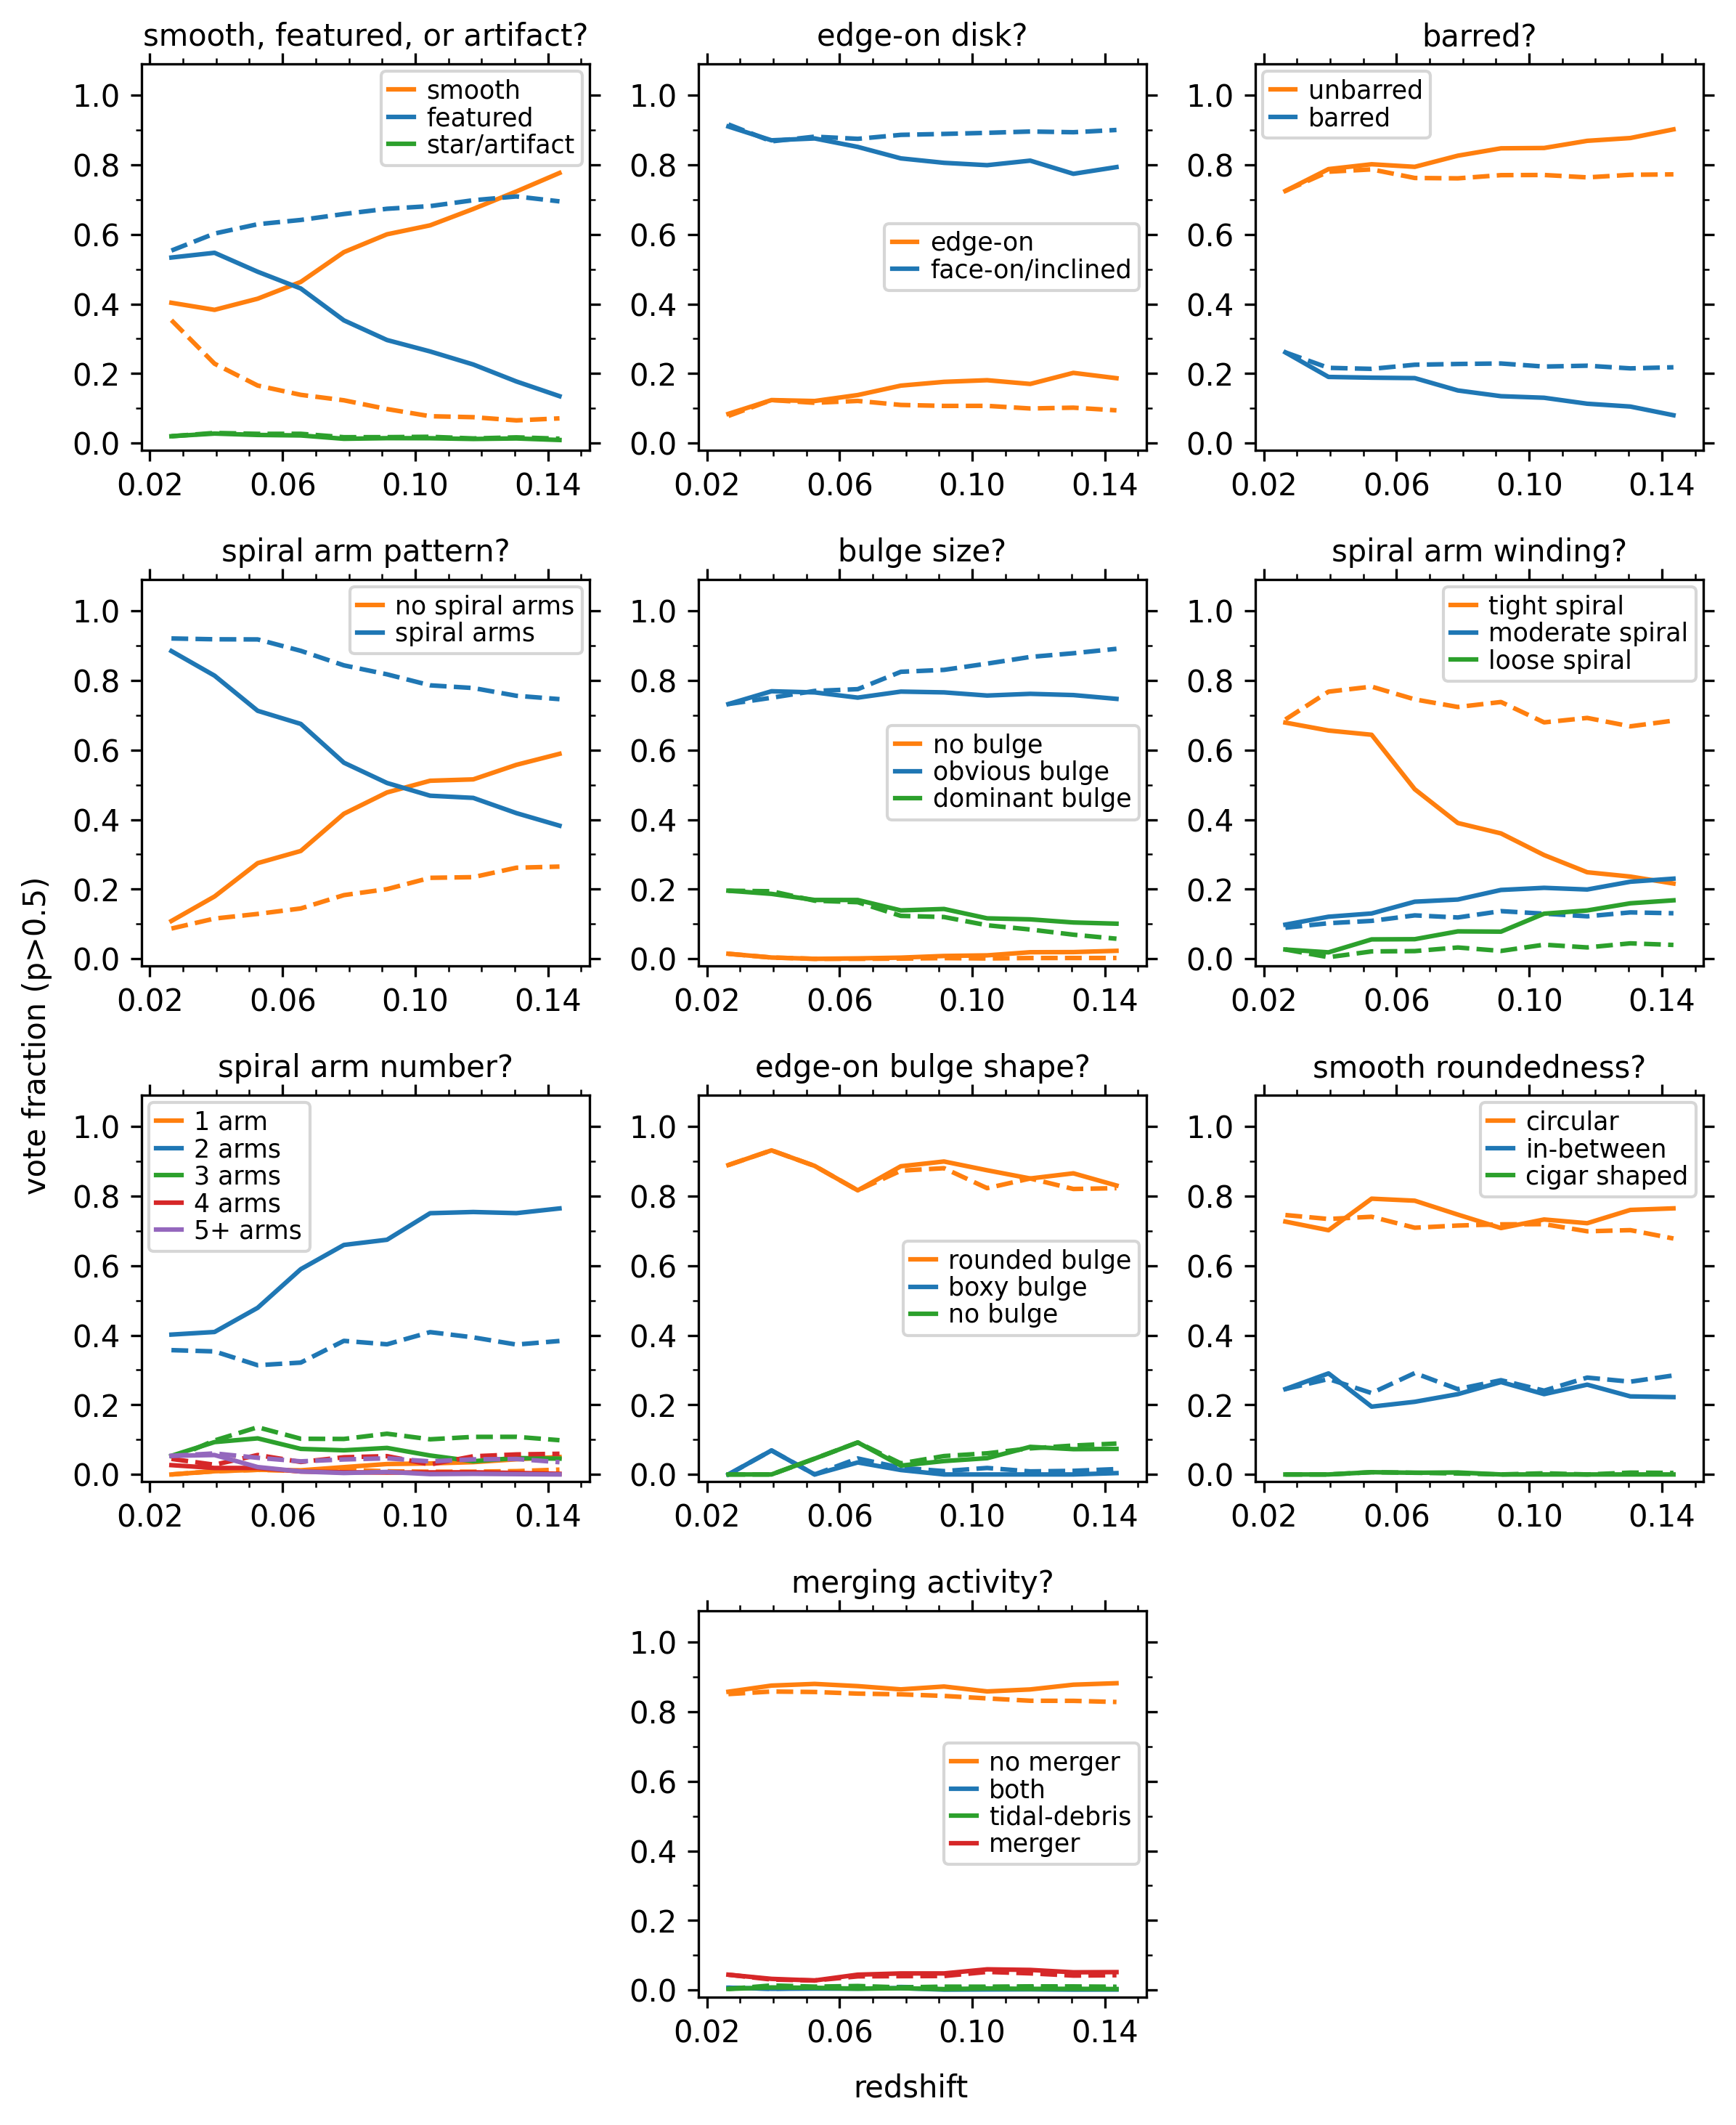

In [55]:
# cleaned vs debiased vote fractions as a function of redshift
z = data_original[z_column]
Mr = data_original[Mr_column]
MagComplete = mag_to_Mag(survey_mag_limit,
                         np.max(volume_redshift_bounds))
in_vl = ((z >= volume_redshift_bounds[0]) &
         (z <= volume_redshift_bounds[1]) &
         (Mr > -99) & (Mr <= MagComplete))
zbins = list(np.linspace(volume_redshift_bounds[0],
                         volume_redshift_bounds[1], 11))
zlos = zbins[:-1]
zhis = zbins[1:]
zmids = list((np.array(zlos)+np.array(zhis))/2)
label_inset = 0.03
axis_pad = 0.02
zticks = np.arange(volume_redshift_bounds[0],
                   volume_redshift_bounds[1]+1e-5, 0.04)
fticks = [0, 0.2, 0.4, 0.6, 0.8, 1]

nrows = int(np.ceil(len(question_dict)/3))
figheight = nrows * 2.5
fig, axs = plt.subplots(nrows, 3, figsize=(8,figheight), dpi=dpi, 
                        sharex=False, sharey=False)
all_ax = axs.flatten()
if (len(question_dict) % 3) == 1:
    (all_ax[len(question_dict)-1],
     all_ax[len(question_dict)-0]) = (all_ax[len(question_dict)-0],
                                      all_ax[len(question_dict)-1])
for ax in all_ax:
    ax.set_visible(False)
    ax.minorticks_on()
    ax.tick_params('x', which='both', bottom=True, top=True)
    ax.tick_params('y', which='both', left=True, right=True)

for q, ax in zip(list(question_dict.keys()), all_ax):
    qlbl = question_dict[q]['lbl_question']
    anss = question_dict[q]['pos_answers']
    lbls = question_dict[q]['lbl_answers']
    ax.set_visible(True)
    for i, (a, l) in enumerate(zip(anss, lbls)):
        cln = data_deb[f'{q}_{a}{input_frac_suffix}']
        deb = data_deb[f'{q}_{a}{output_frac_suffix}']
        qa_good = ((deb>=0)&(deb<=1)&(cln>=0)&(cln<=1)&in_vl)
        # For GZ2, Ross limited this plot to galaxies in the
        # prior sample mask
        qa_good &= data_deb[f'{q}{output_priorsample_suffix}']
        cln_frac, deb_frac = [], []
        for zl, zh in zip(zlos, zhis):
            qa_samp = (z >= zl) & (z <= zh) & qa_good
            cln_true = cln[qa_samp] > 0.5
            deb_true = deb[qa_samp] > 0.5
            cln_frac.append(sum(cln_true)/sum(qa_samp))
            deb_frac.append(sum(deb_true)/sum(qa_samp))
        ax.plot(zmids, cln_frac, c=cols[i], label=l)
        ax.plot(zmids, deb_frac, c=cols[i], ls='--')
    ax.set_xticks(zticks)
    ax.set_yticks(fticks)
    ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.01))
    ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.1))
    ax.set_xlim(extendrange((volume_redshift_bounds[0],
                             volume_redshift_bounds[1]), 0.02))
    ax.set_ylim(-0.02,1.09)
    ax.text(0.5, 1+label_inset, qlbl, fontsize='medium',
            ha='center', va='bottom', transform=ax.transAxes)
    if q != 'features':
        ax.legend(fontsize='small', handlelength=1, borderpad=0.3,
                  labelspacing=0.1, handletextpad=0.5,
                  borderaxespad=0.3)
    else:
        leg = ax.legend(fontsize='small', handlelength=1,
                        borderpad=0.3, labelspacing=0.1,
                        handletextpad=0.5, borderaxespad=0.3, loc=2)
        cl, =ax.plot([-1,-1],[-1,-1],ls='-',c='k',label='cleaned')
        dl, =ax.plot([-1,-1],[-1,-1],ls='--',c='k',label='debiased')
        ax.legend(handles=[cl,dl], fontsize='small',
                  handlelength=1.5, borderpad=0.3, labelspacing=0.1,
                  handletextpad=0.5, borderaxespad=0.3, loc=1)
        ax.add_artist(leg)

fig.text(0.52, 0.01, 'redshift',
         ha='center', va='bottom', transform=fig.transFigure)
fig.text(0.01, 0.5, 'vote fraction (p>0.5)', rotation=90,
         ha='left', va='center', transform=fig.transFigure)

plt.tight_layout(rect=[0+axis_pad, 0+axis_pad, 1, 1-axis_pad],
                 h_pad=1.2, w_pad=0.5)
plt.savefig(fname=outdir+'/votefrac.pdf', dpi='figure')
plt.show()
plt.close()


--------------------------------------------------------------------
smooth, featured, or artifact?
------------------------------
eligible galaxies in volume limited sample = 30483
              smooth: false pos = 17394 false neg = 0 
    featured-or-disk: false pos = 355   false neg = 13537 
            artifact: false pos = 5     false neg = 105 


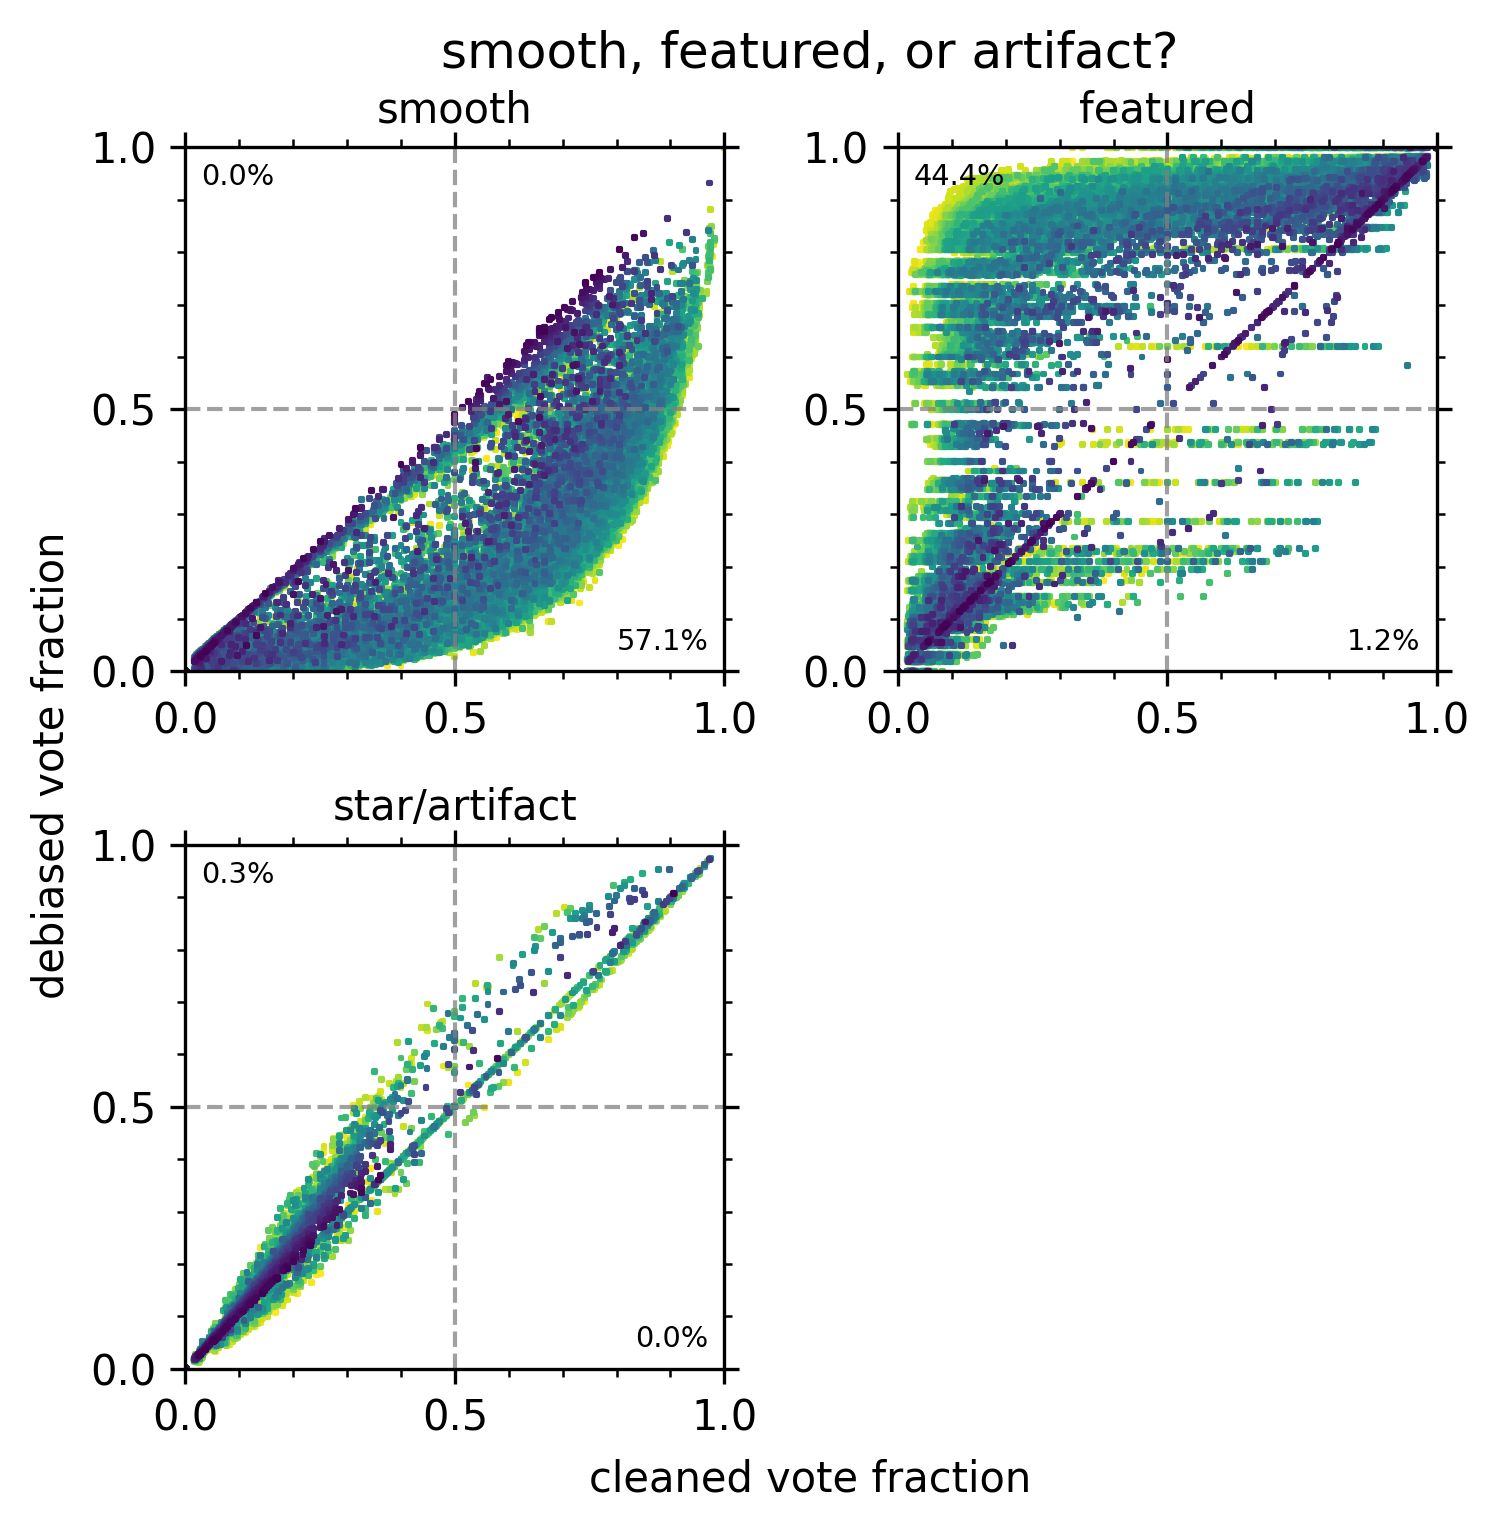

--------------------------------------------------------------------





--------------------------------------------------------------------
edge-on disk?
-------------
eligible galaxies in volume limited sample = 18350
                 yes: false pos = 1772  false neg = 148 
                  no: false pos = 175   false neg = 1716 


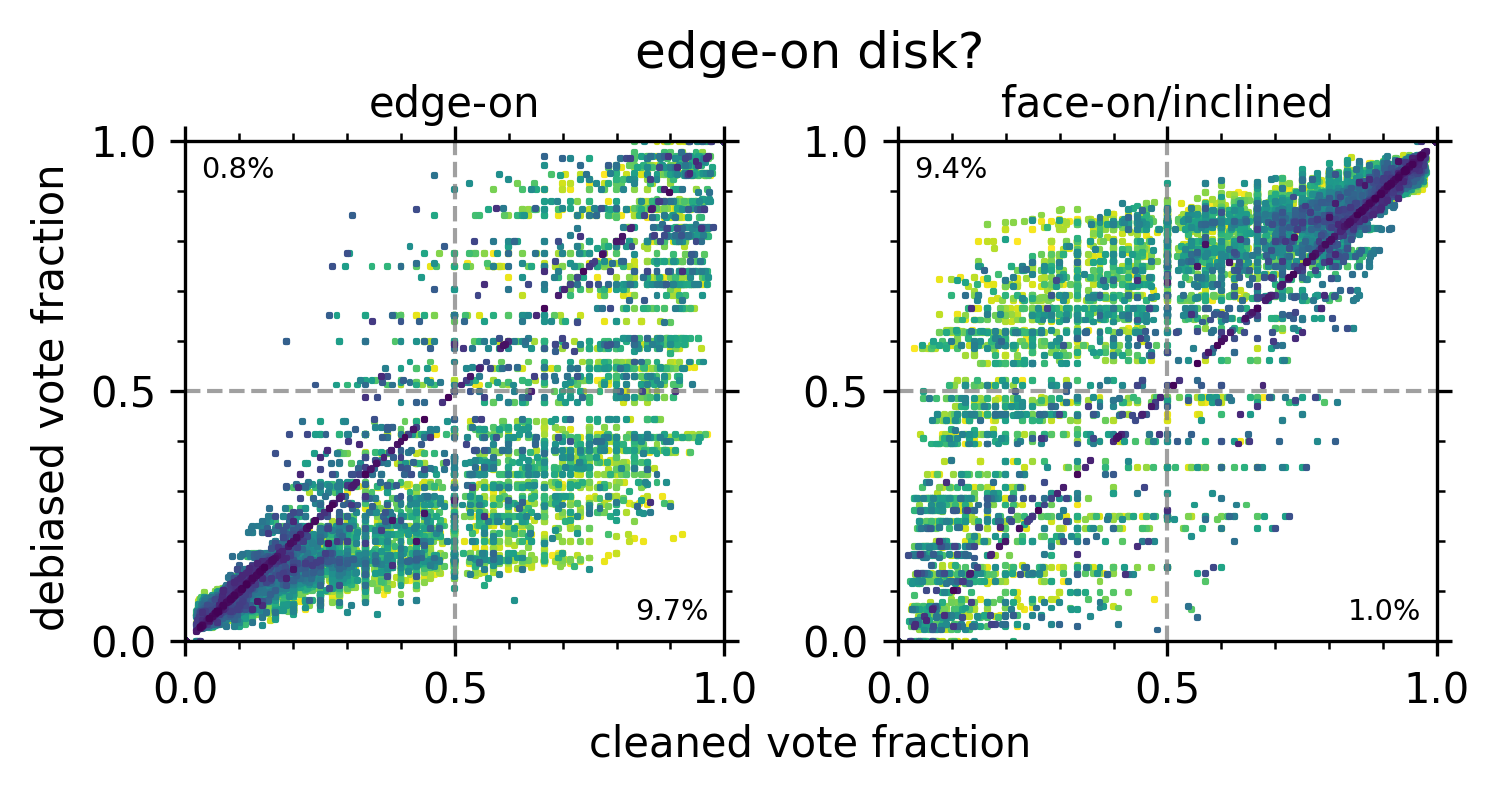

--------------------------------------------------------------------





--------------------------------------------------------------------
barred?
-------
eligible galaxies in volume limited sample = 14091
                  no: false pos = 1546  false neg = 96 
                 yes: false pos = 83    false neg = 1562 


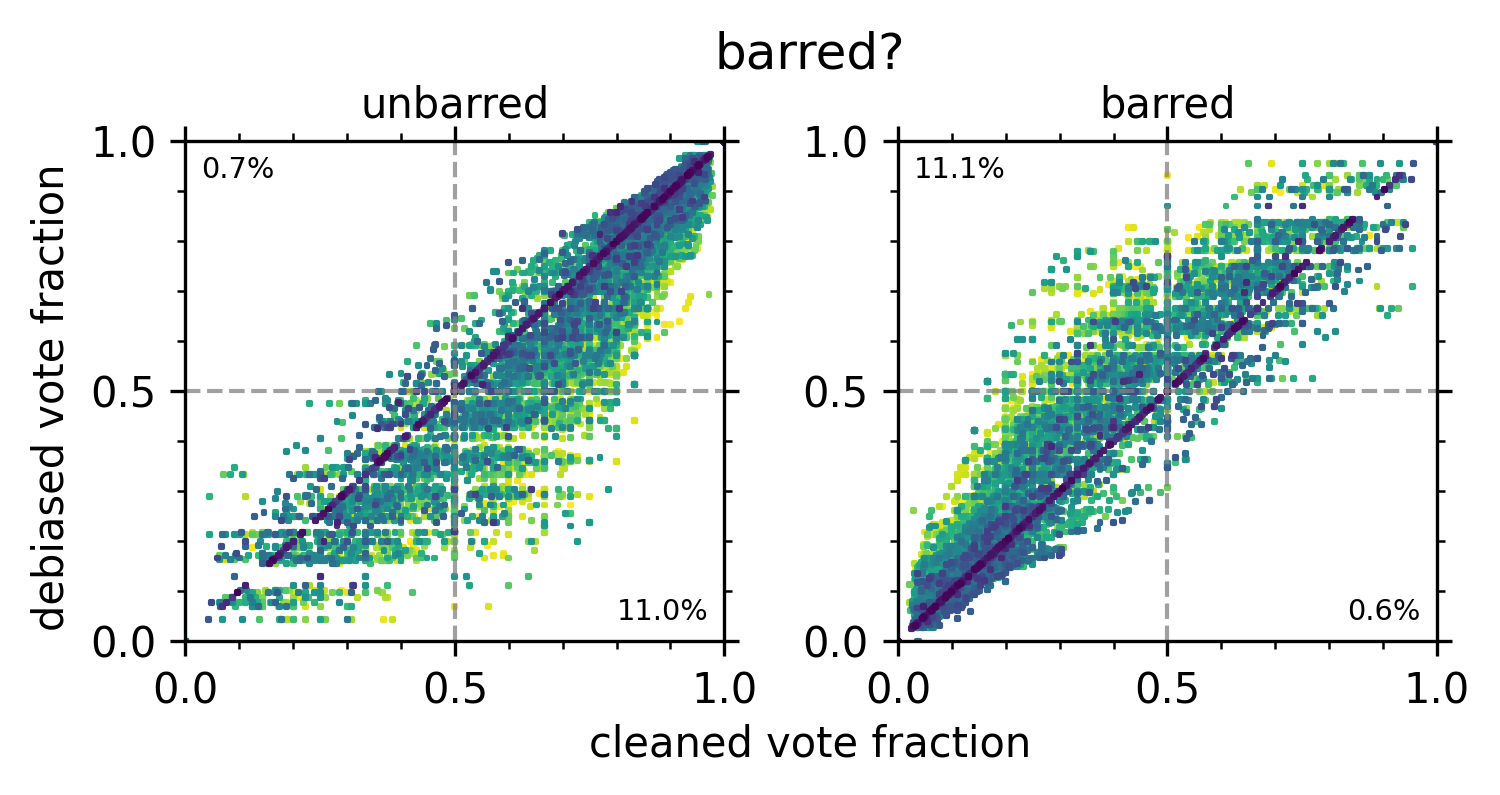

--------------------------------------------------------------------





--------------------------------------------------------------------
spiral arm pattern?
-------------------
eligible galaxies in volume limited sample = 14091
                  no: false pos = 4074  false neg = 0 
                 yes: false pos = 0     false neg = 4333 


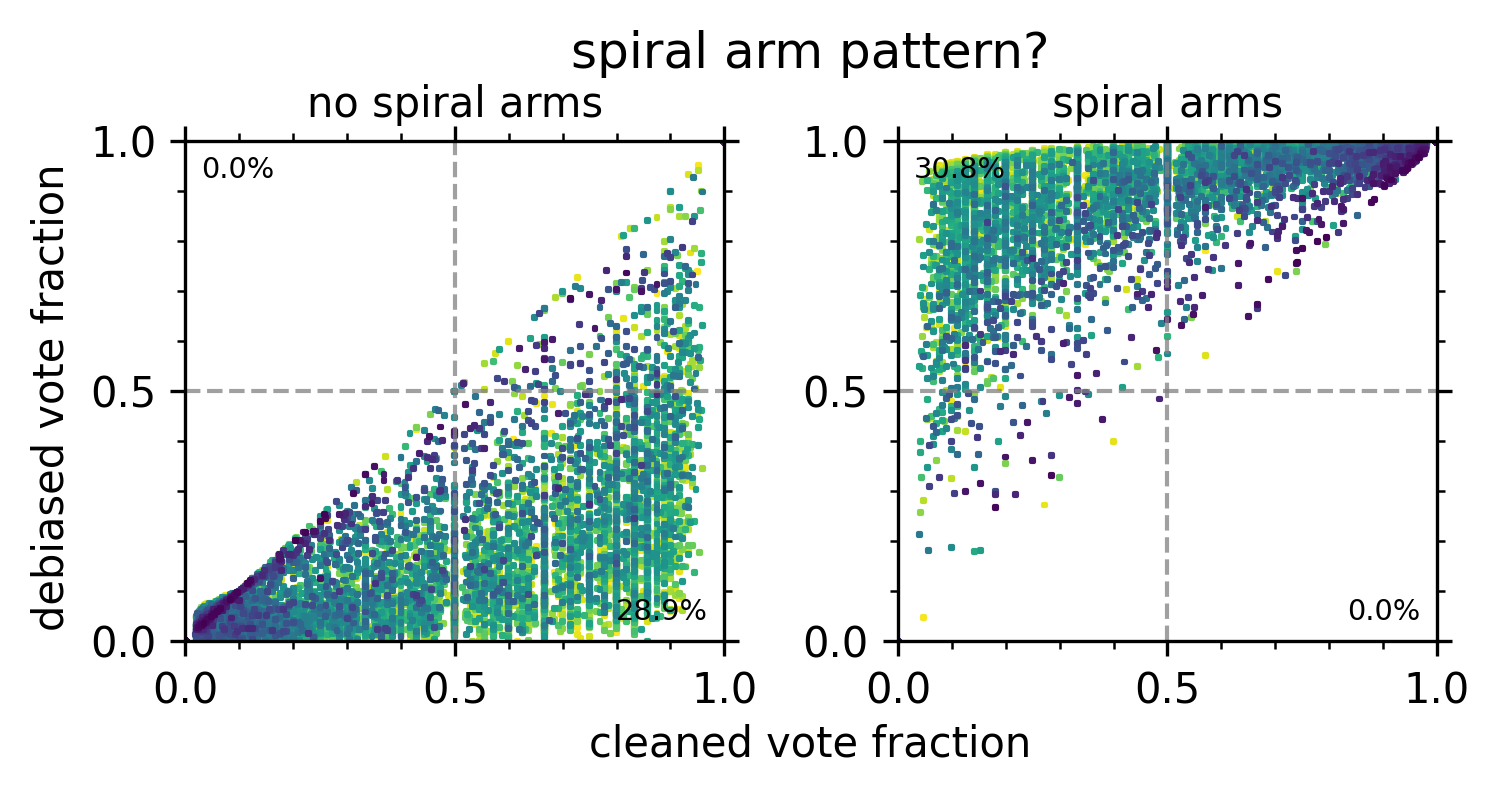

--------------------------------------------------------------------





--------------------------------------------------------------------
bulge size?
-----------
eligible galaxies in volume limited sample = 14091
                none: false pos = 232   false neg = 0 
             obvious: false pos = 220   false neg = 1585 
            dominant: false pos = 967   false neg = 282 


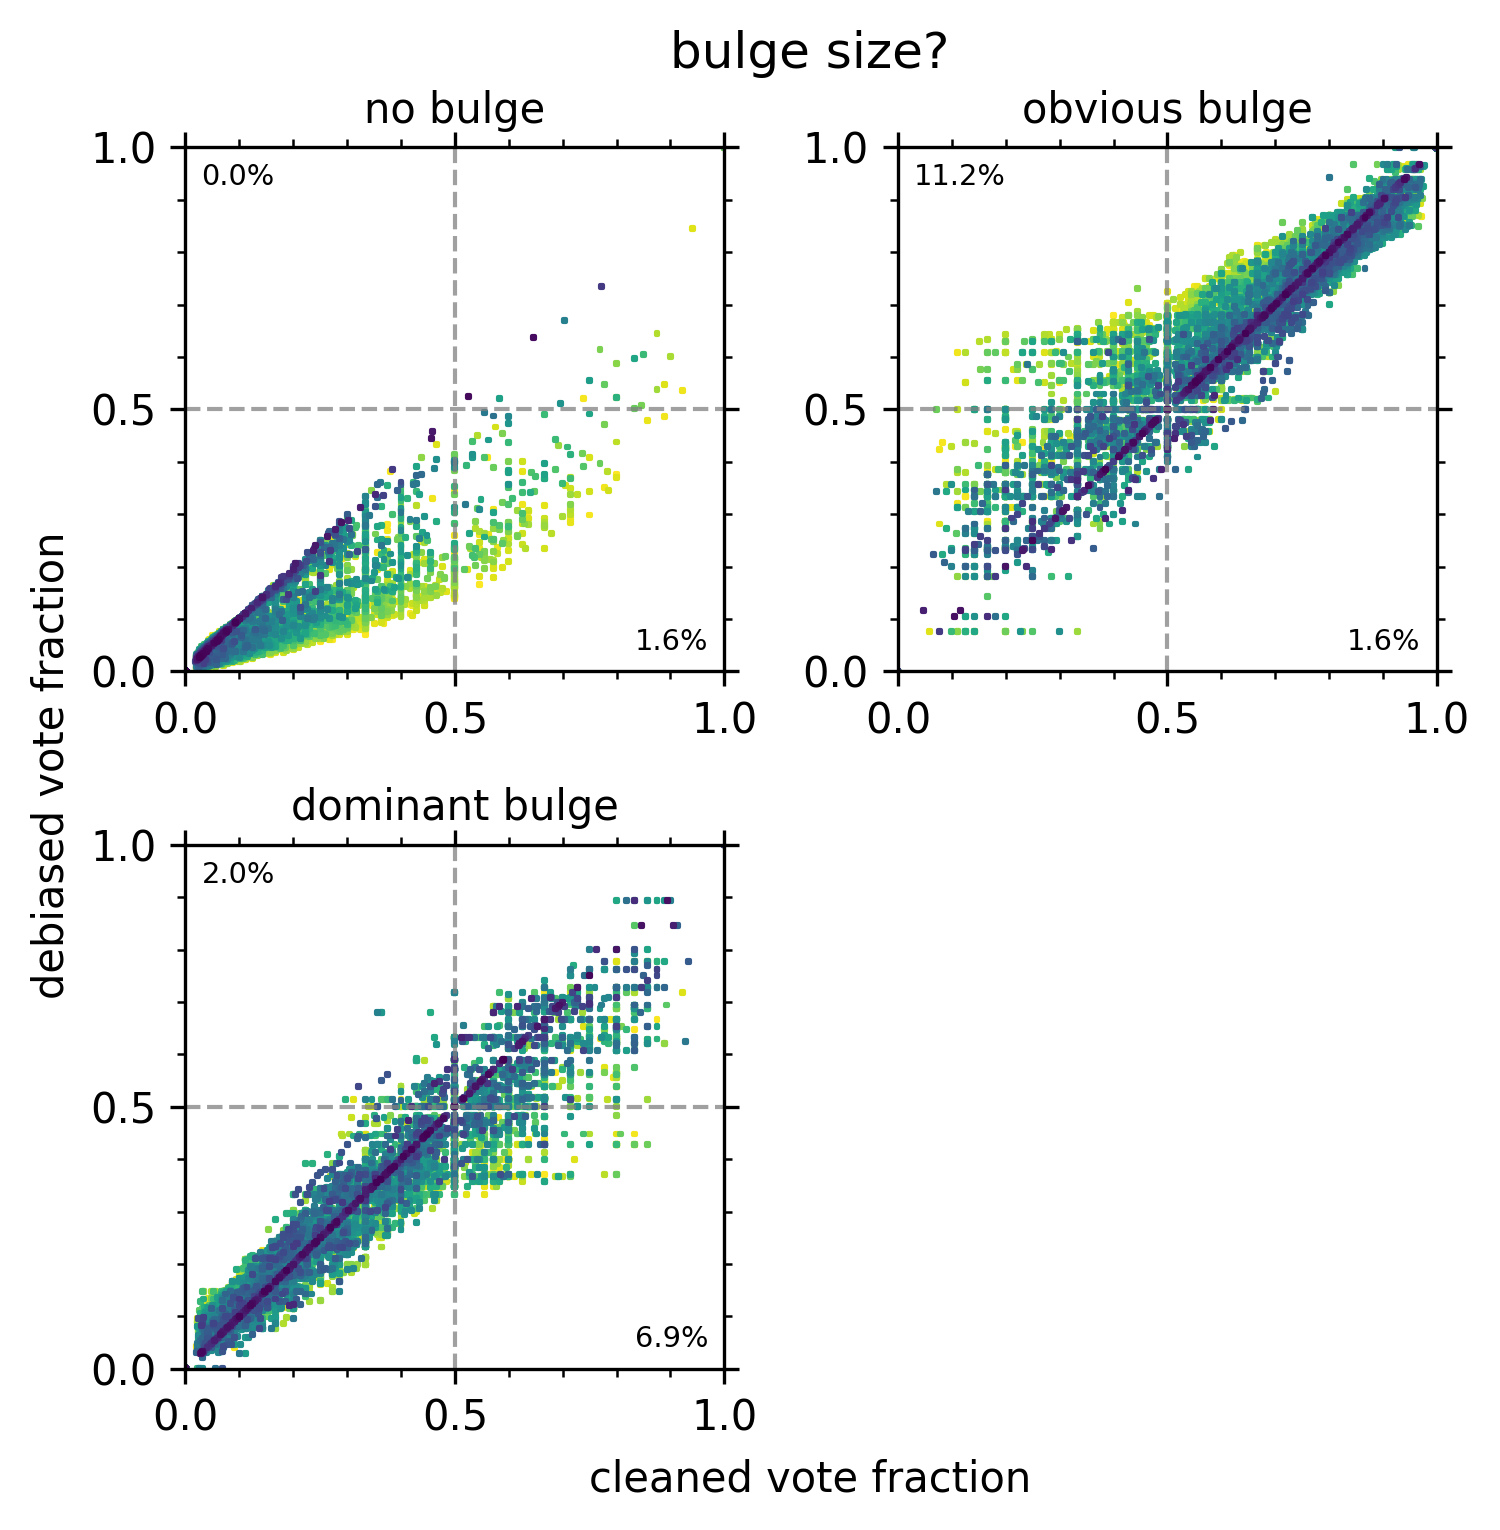

--------------------------------------------------------------------





--------------------------------------------------------------------
spiral arm winding?
-------------------
eligible galaxies in volume limited sample = 7704
               tight: false pos = 0     false neg = 2845 
              medium: false pos = 903   false neg = 0 
               loose: false pos = 814   false neg = 0 


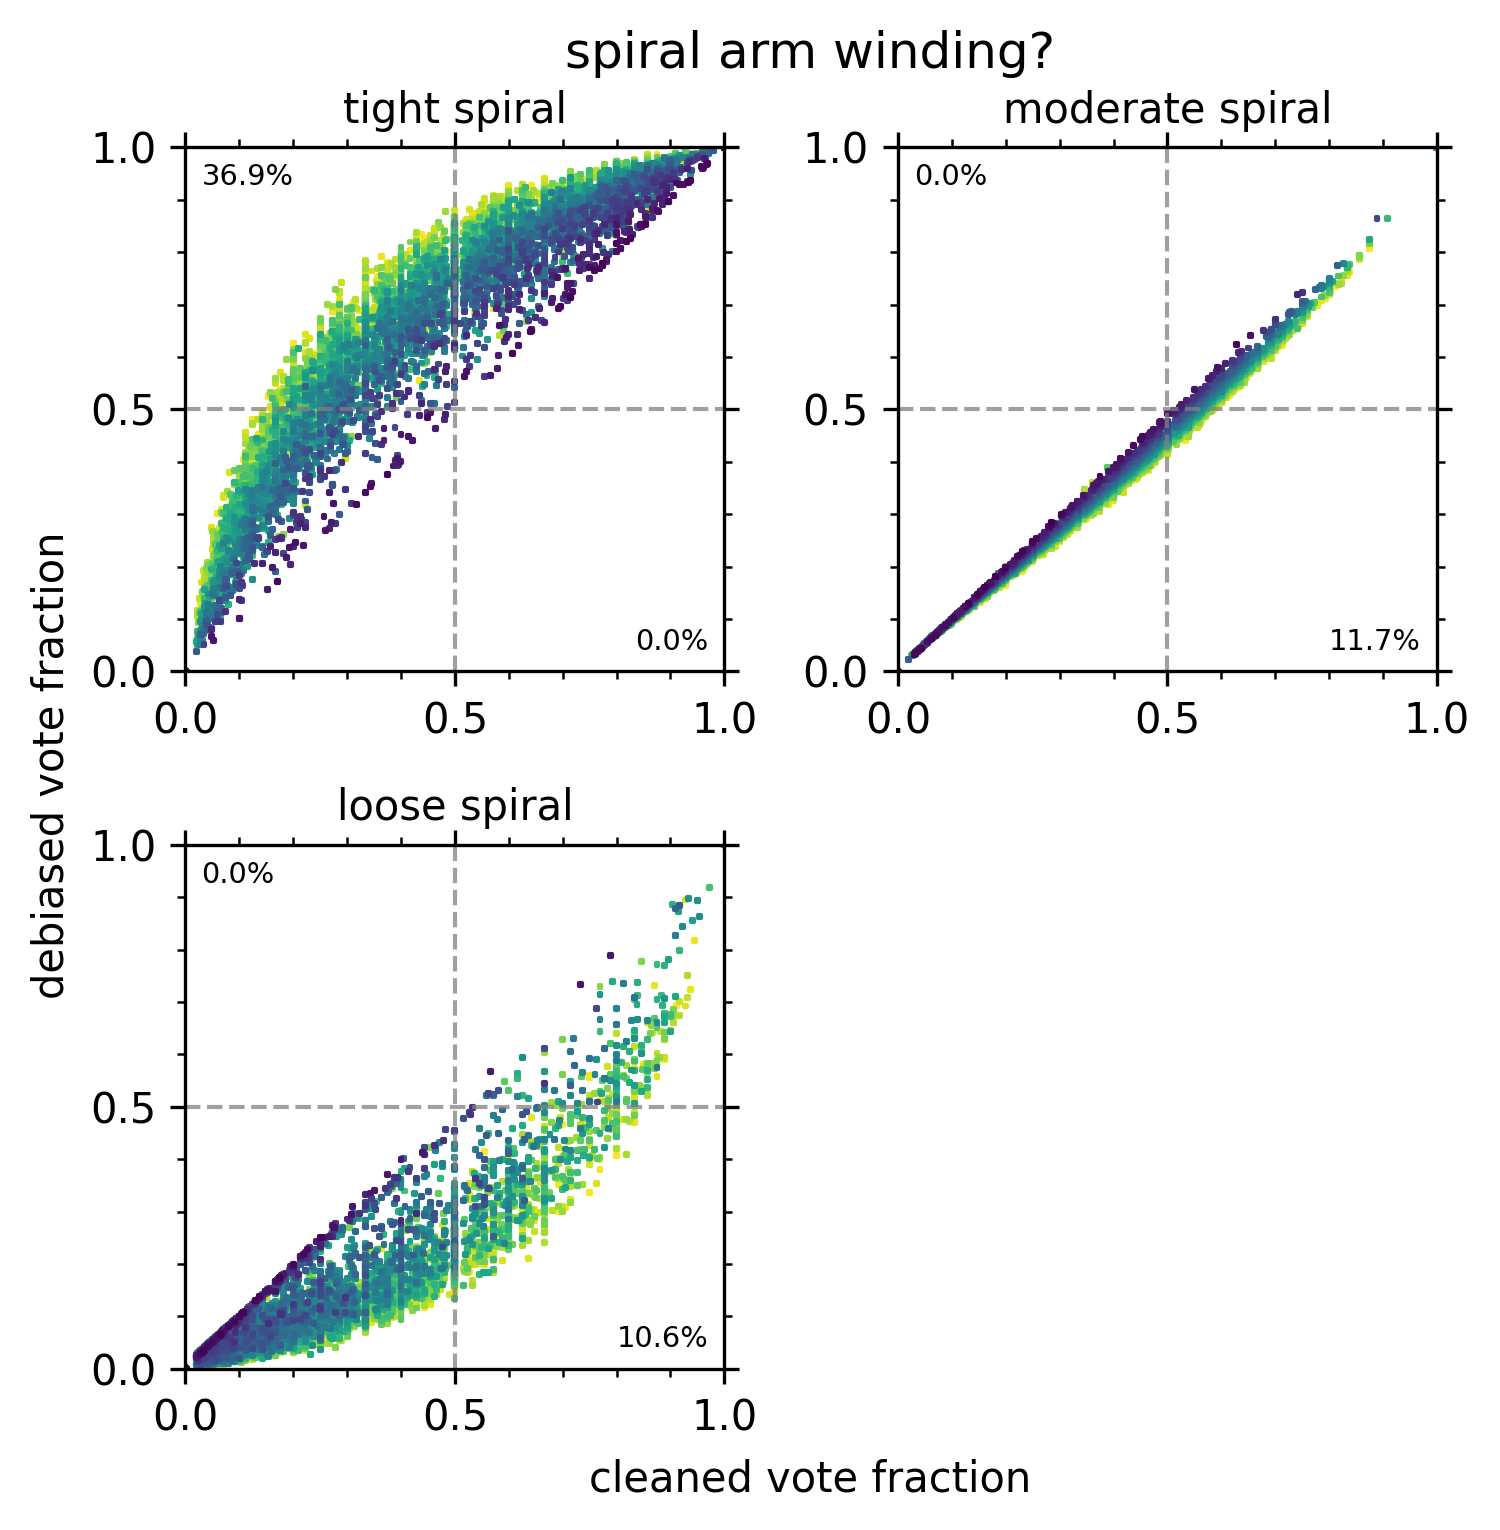

--------------------------------------------------------------------





--------------------------------------------------------------------
spiral arm number?
------------------
eligible galaxies in volume limited sample = 7704
                   1: false pos = 227   false neg = 8 
                   2: false pos = 2627  false neg = 0 
                   3: false pos = 14    false neg = 362 
                   4: false pos = 0     false neg = 325 
         more-than-4: false pos = 3     false neg = 305 


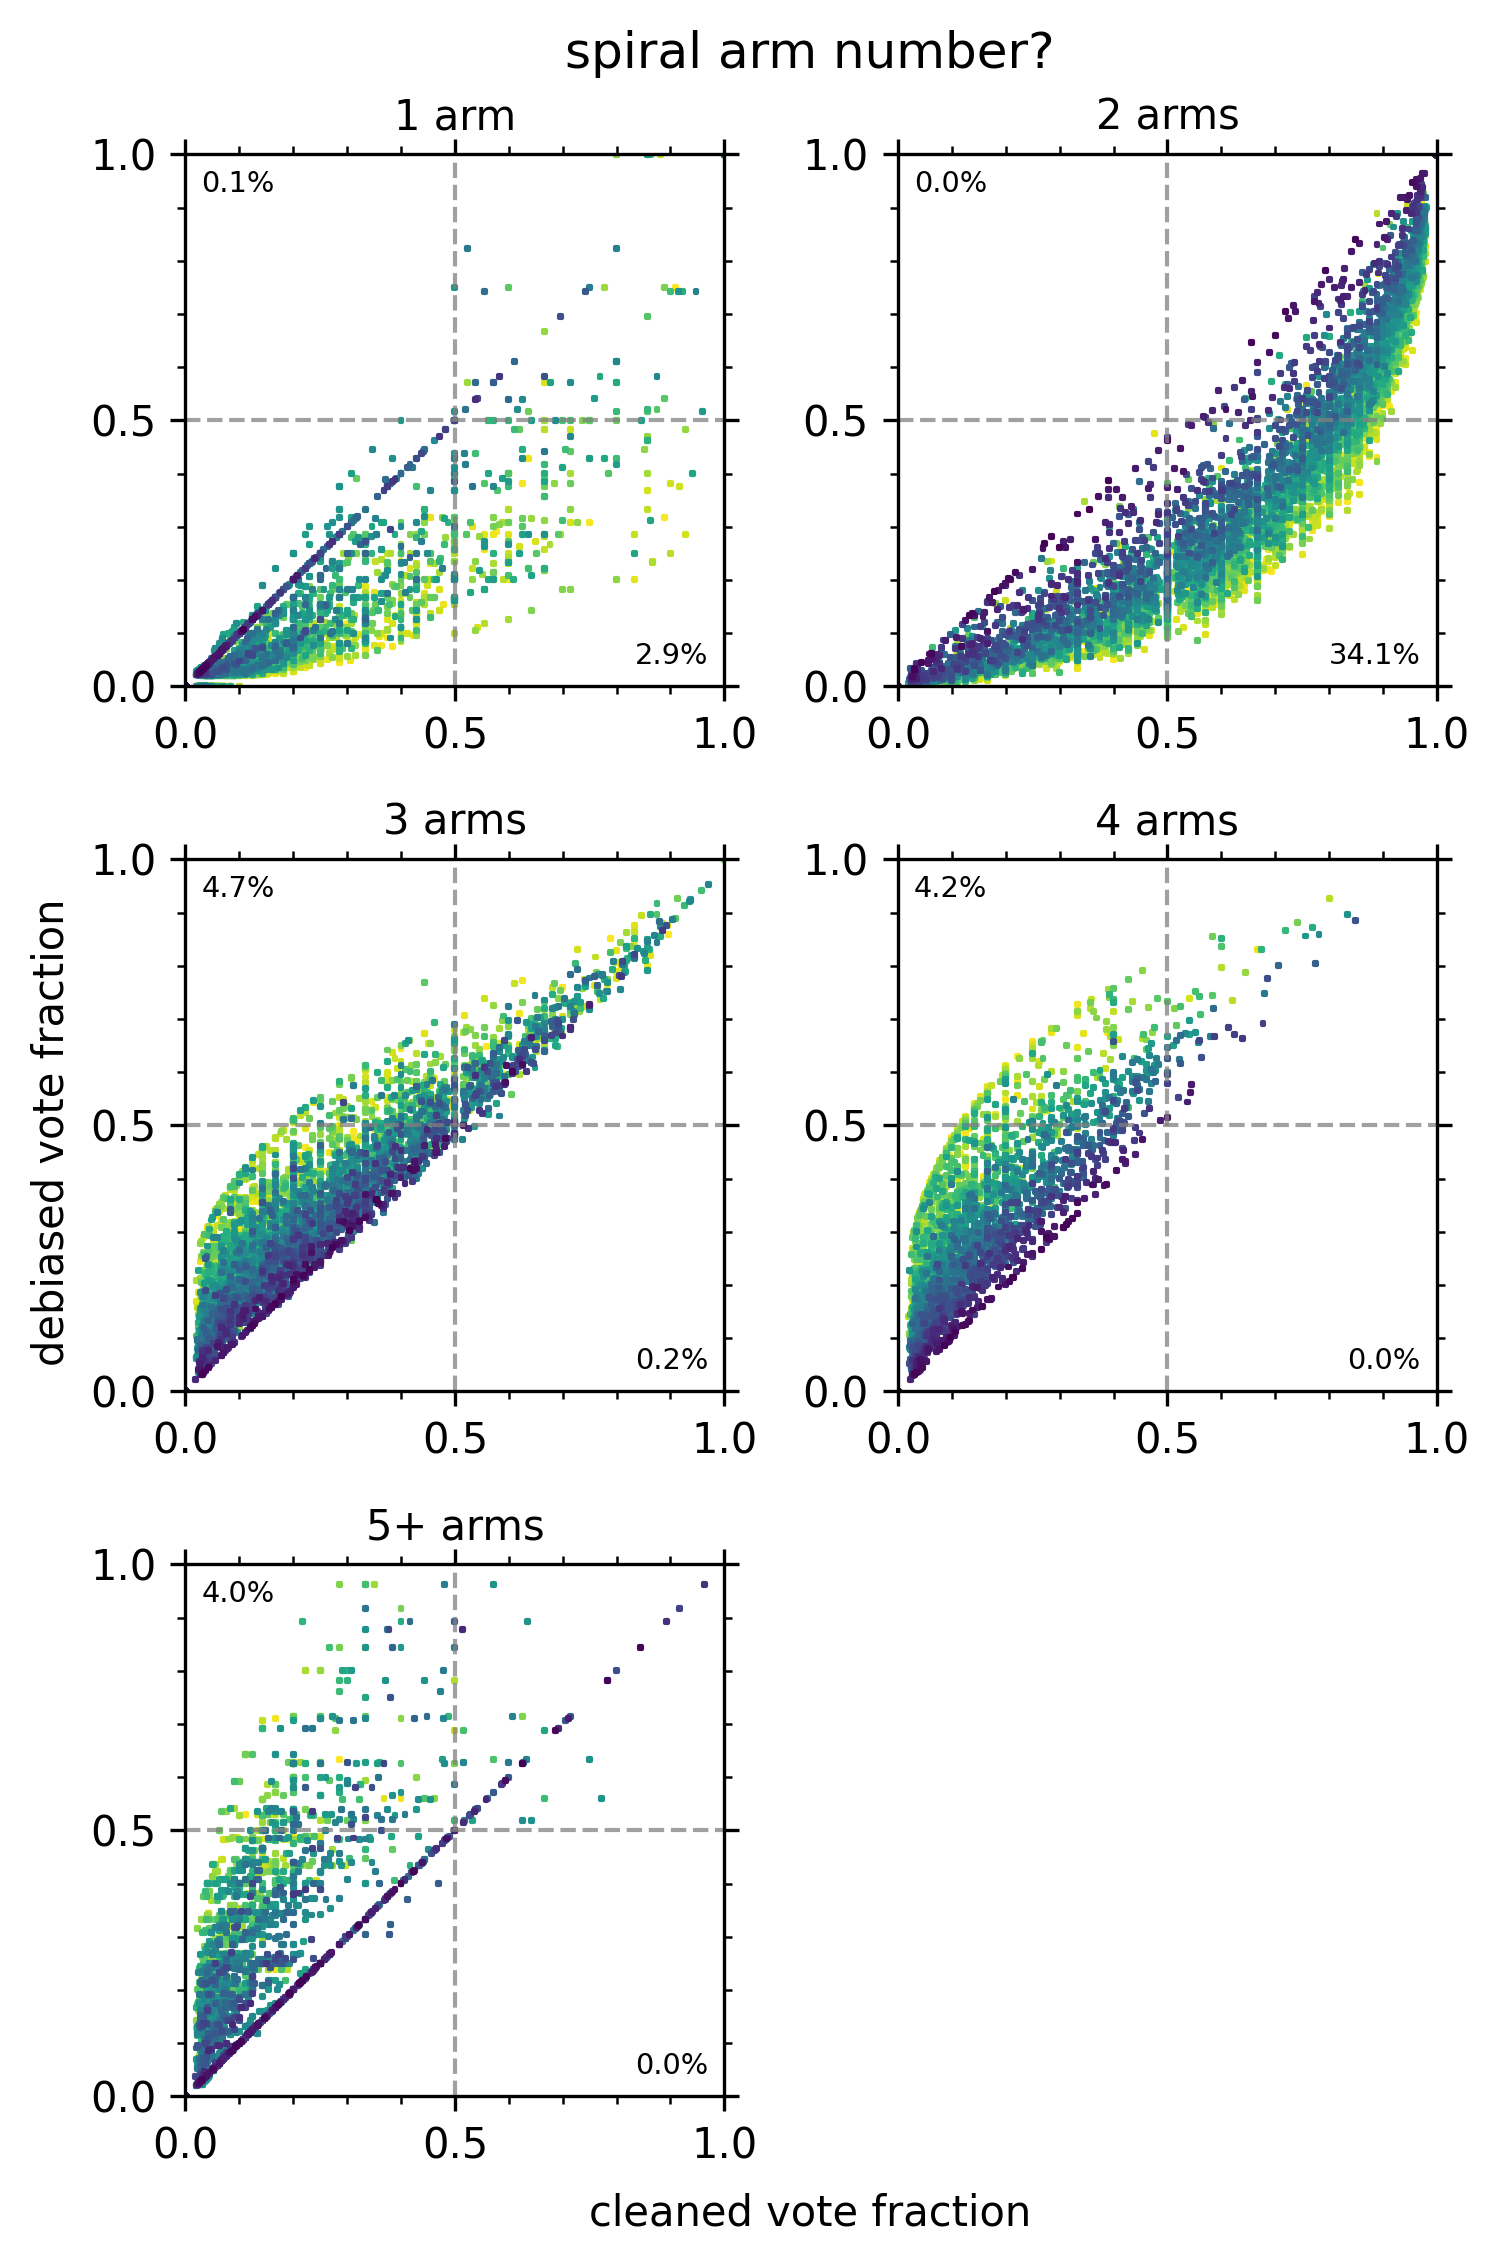

--------------------------------------------------------------------





--------------------------------------------------------------------
edge-on bulge shape?
--------------------
eligible galaxies in volume limited sample = 1523
             rounded: false pos = 78    false neg = 24 
                boxy: false pos = 7     false neg = 27 
                none: false pos = 35    false neg = 37 


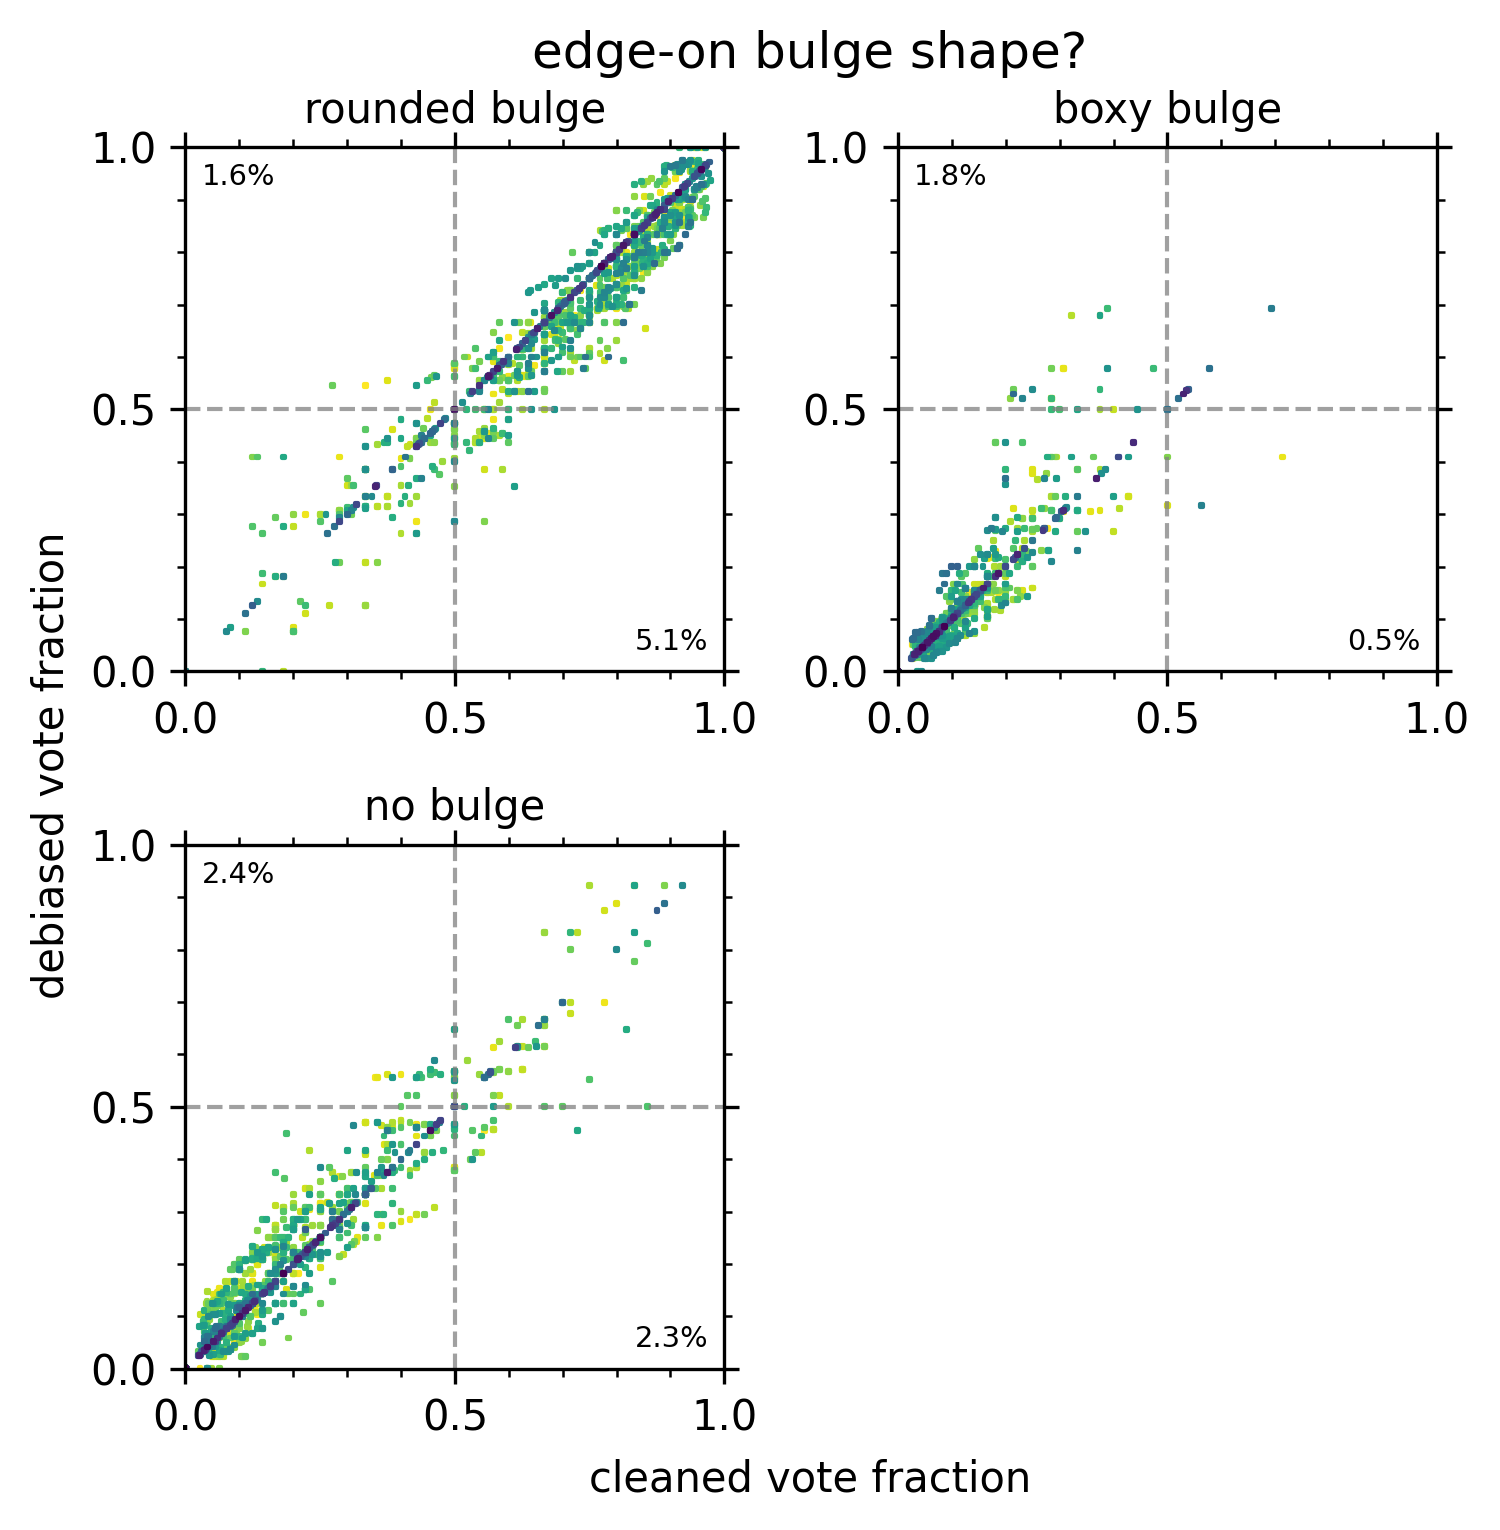

--------------------------------------------------------------------





--------------------------------------------------------------------
smooth roundedness?
-------------------
eligible galaxies in volume limited sample = 2787
          completely: false pos = 160   false neg = 49 
          in-between: false pos = 58    false neg = 134 
        cigar-shaped: false pos = 2     false neg = 8 


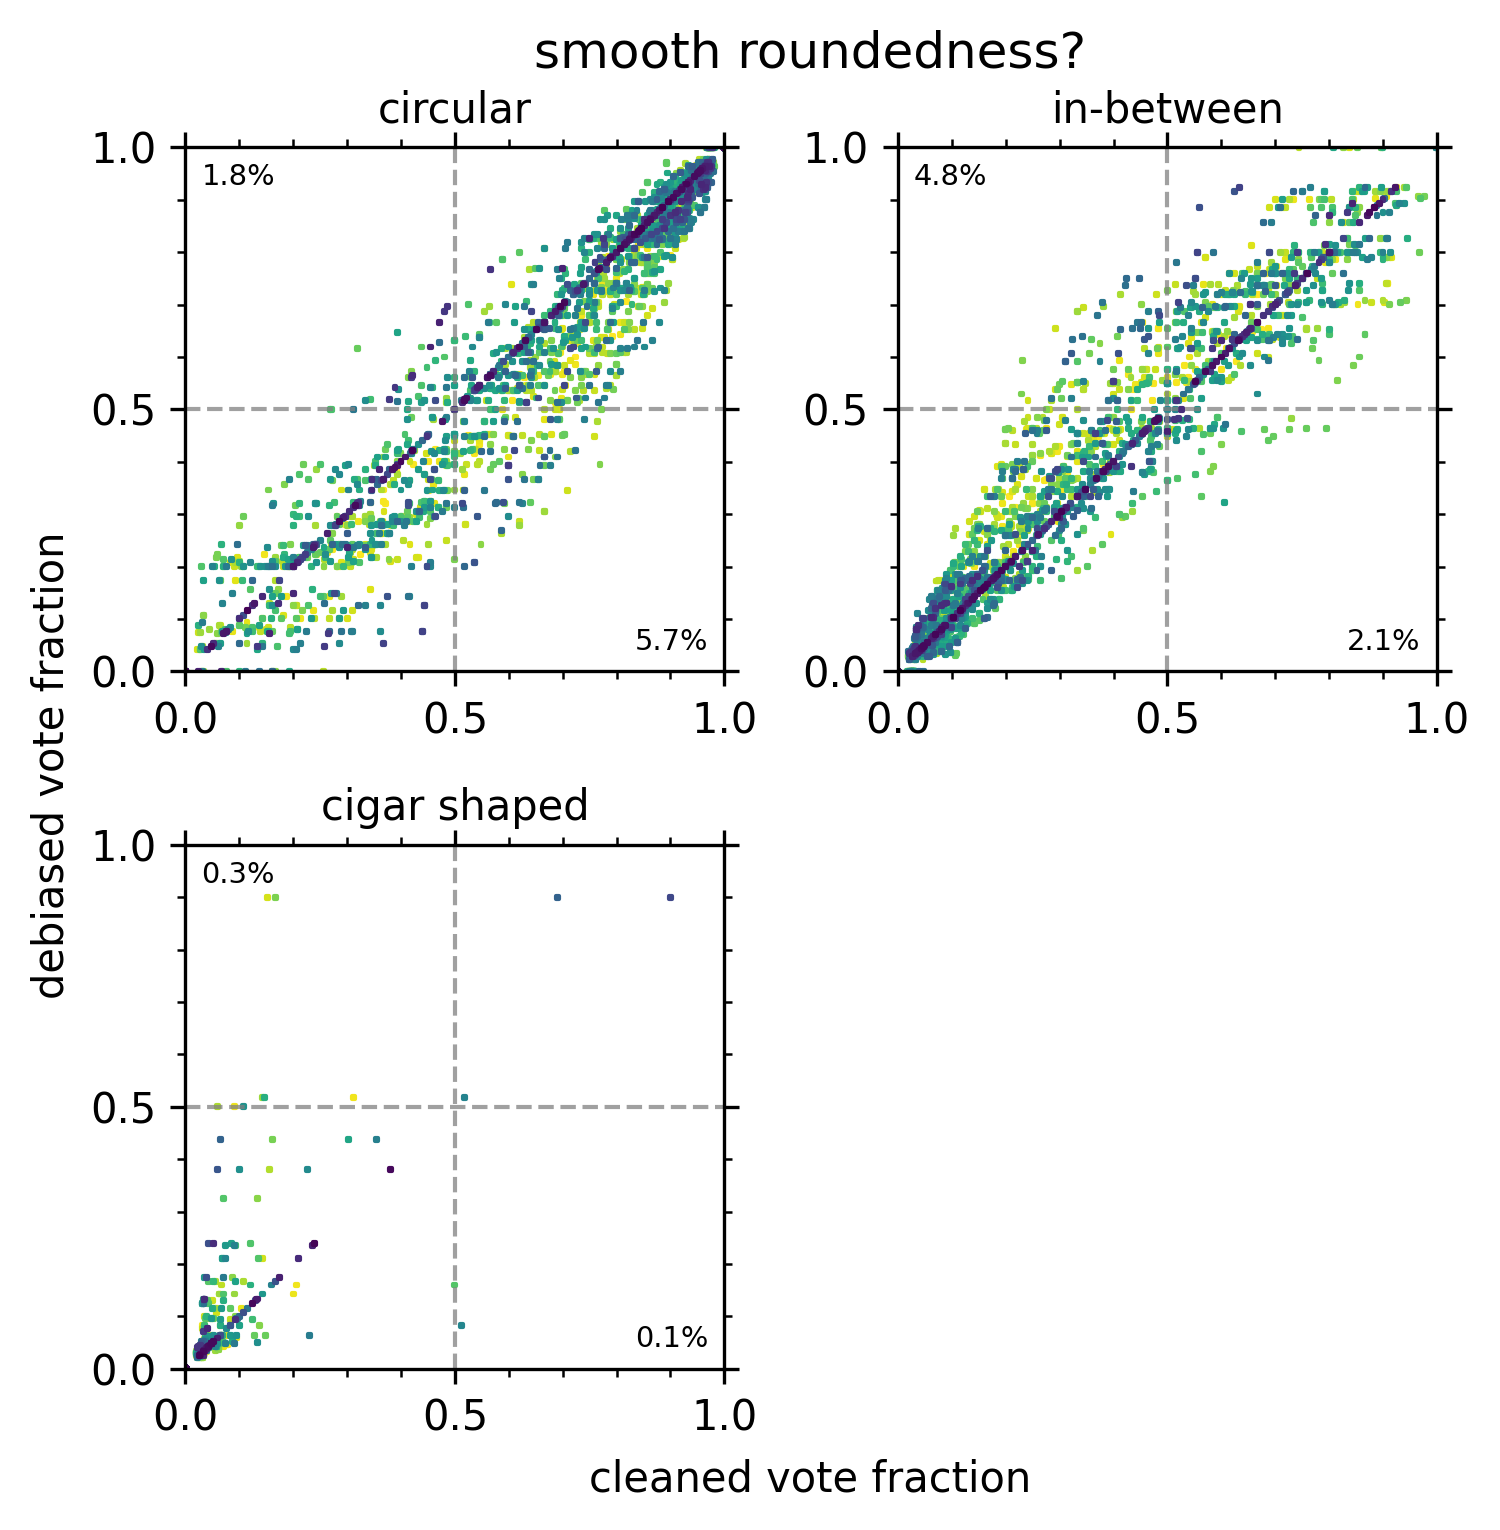

--------------------------------------------------------------------





--------------------------------------------------------------------
merging activity?
-----------------
eligible galaxies in volume limited sample = 29968
             neither: false pos = 1647  false neg = 581 
                both: false pos = 36    false neg = 240 
        tidal-debris: false pos = 68    false neg = 279 
              merger: false pos = 348   false neg = 0 


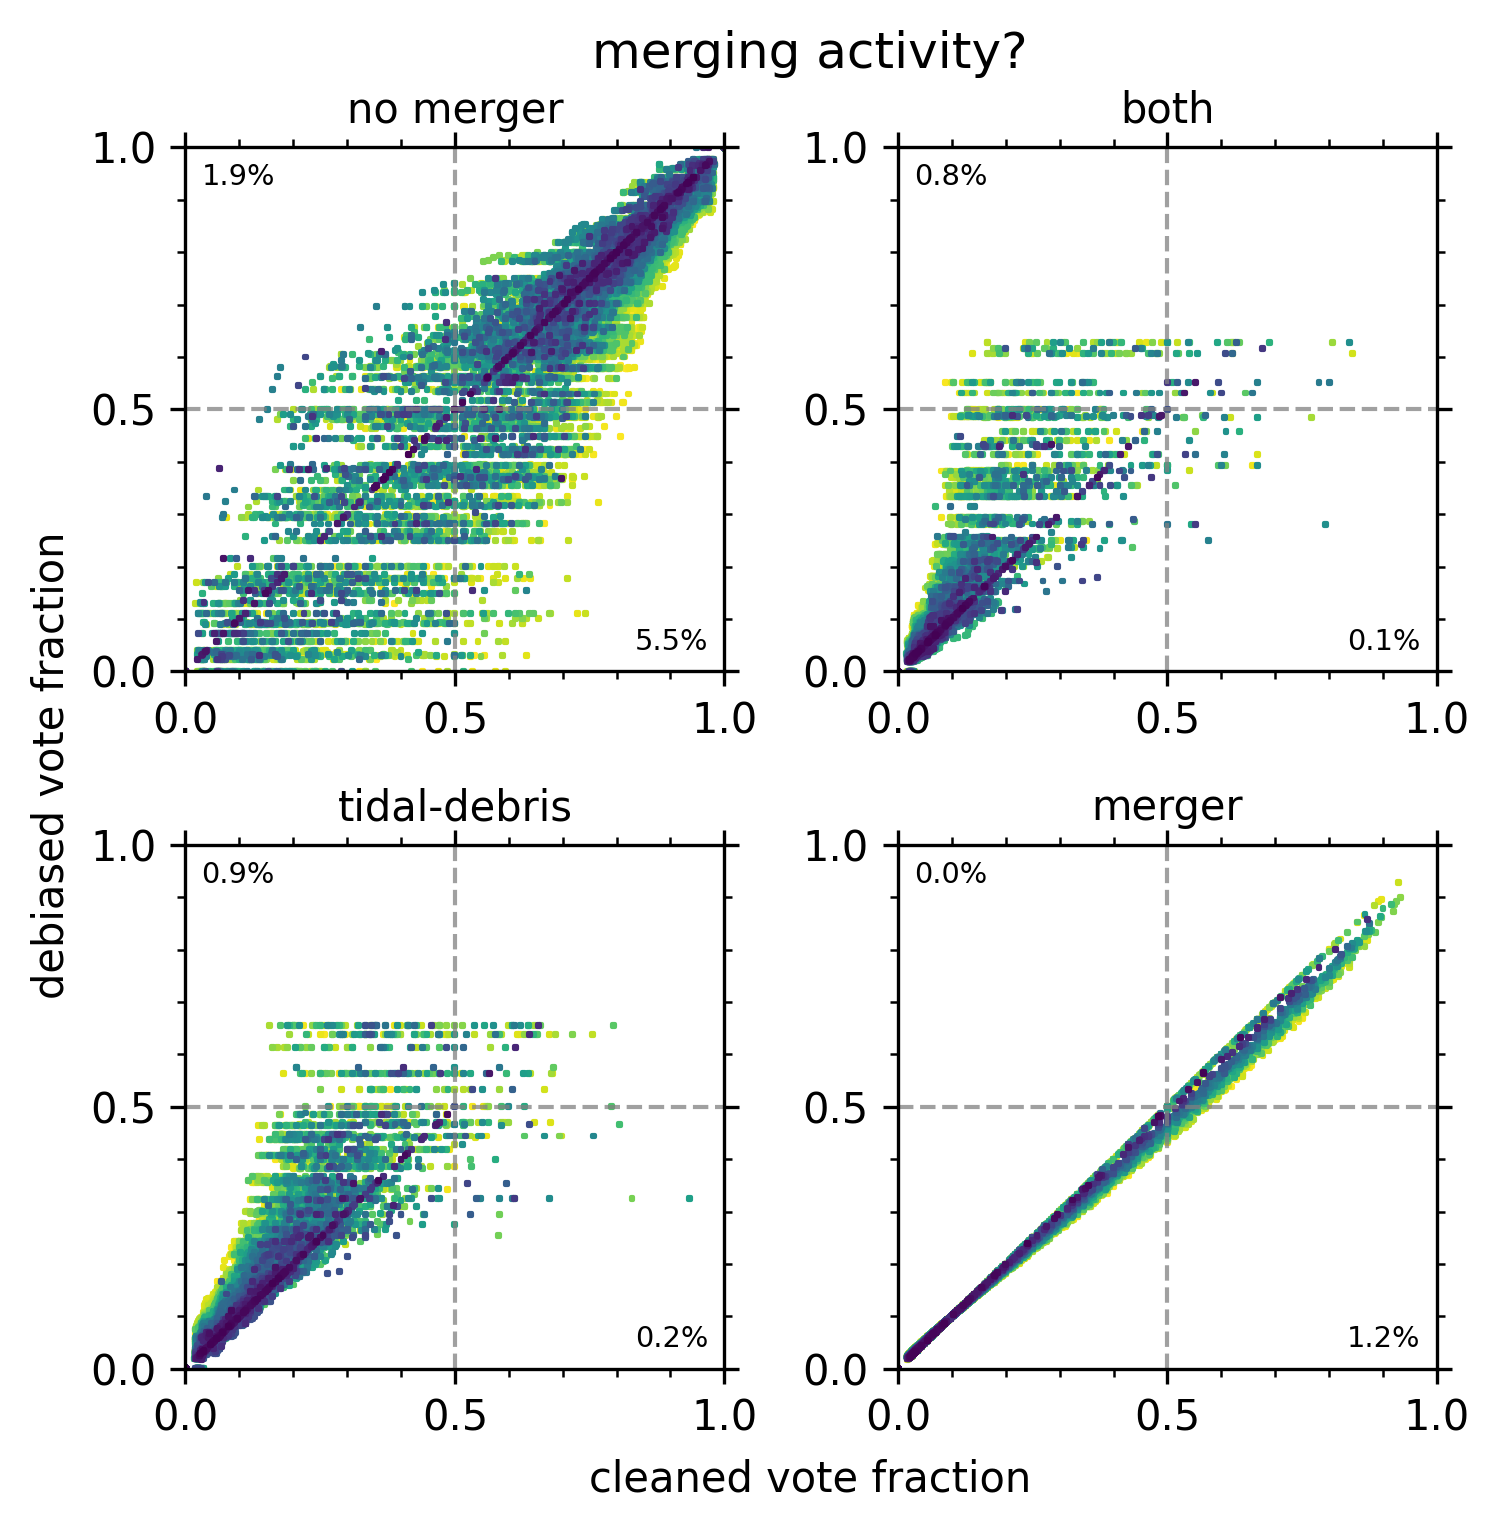

--------------------------------------------------------------------






In [56]:
# cleaned vs debiased vote fractions for all question/answer pairs
z = data_original[z_column]
Mr = data_original[Mr_column]
MagComplete = mag_to_Mag(survey_mag_limit,
                         np.max(volume_redshift_bounds))
in_vl = ((z >= volume_redshift_bounds[0]) &
         (z <= volume_redshift_bounds[1]) &
         (Mr > -99) & (Mr <= MagComplete))
major_ticks = np.arange(0,1+1e-5,0.5)
label_inset = 0.03
axis_pad = 0.02
for q in list(question_dict.keys()):
    qlbl = question_dict[q]['lbl_question']
    anss = question_dict[q]['pos_answers']
    lbls = question_dict[q]['lbl_answers']
    ncols = 2
    nrows = int(np.ceil(len(anss) / ncols))
    fig, axs = plt.subplots(nrows, ncols, dpi=300,
                           figsize=(ncols*2.5, nrows*2.5))
    for ax in axs.flatten():
        ax.set_visible(False)
        ax.minorticks_on()
        ax.tick_params('x', which='both', bottom=True, top=True)
        ax.tick_params('y', which='both', left=True, right=True)
    for a, l, ax in zip(anss, lbls, axs.flatten()):
        cln = data_deb[f'{q}_{a}{input_frac_suffix}']
        deb = data_deb[f'{q}_{a}{output_frac_suffix}']
        qa_good = ((deb>=0)&(deb<=1)&(cln>=0)&(cln<=1)&in_vl)
        qa_good &= data_deb[f'{q}{output_priorsample_suffix}']
        cln_good = cln[qa_good]
        deb_good = deb[qa_good]
        z_good = z[qa_good]
        oo = np.argsort(z_good)[::-1]
        qa_false_pos = (cln_good >= 0.5) & (deb_good <= 0.5)
        qa_false_neg = (cln_good <= 0.5) & (deb_good >= 0.5)
        if a==anss[0]:
            print(f'\n{"-"*68}\n{qlbl}\n{"-"*len(qlbl)}\n'
                  f'eligible galaxies in volume limited sample = '
                  f'{sum(qa_good)}')
        print(f'{a.rjust(20)}: '
              f'false pos = {str(sum(qa_false_pos)).ljust(5)} '
              f'false neg = {sum(qa_false_neg)} ')
        ax.set_visible(True)
        ax.set_xticks(major_ticks)
        ax.set_yticks(major_ticks)
        ax.scatter(cln_good[oo], deb_good[oo], c=z_good[oo],
                   marker=',', s=0.5)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.text(0+label_inset, 1-label_inset, ha='left', va='top',
                s=f'{100*(sum(qa_false_neg)/sum(qa_good)):.01f}%',
                fontsize='x-small')
        ax.text(1-label_inset, 0+label_inset,ha='right',va='bottom',
                s=f'{100*(sum(qa_false_pos)/sum(qa_good)):.01f}%',
                fontsize='x-small')
#         ax.text(0+label_inset, 1-label_inset,l,ha='left',va='top')
        ax.text(0.5, 1+label_inset, l, ha='center', va='bottom')
        ax.axvline(0.5, c='grey', ls='--', lw=1, alpha=0.75)
        ax.axhline(0.5, c='grey', ls='--', lw=1, alpha=0.75)

    fig.text(0.53, 0.99, qlbl, fontsize='large',
             ha='center', va='top', transform=fig.transFigure)
    fig.text(0.53, 0.01, 'cleaned vote fraction',
             ha='center', va='bottom', transform=fig.transFigure)
    fig.text(0.01, 0.5, 'debiased vote fraction', rotation=90,
             ha='left', va='center', transform=fig.transFigure)

    plt.tight_layout(rect=[0+axis_pad, 0+axis_pad, 1, 1-axis_pad])
    plt.savefig(fname=outdir+'/votefrac_scat_'+q+'.png',
                dpi='figure')
    plt.show()
    plt.close()
    print(f'{"-"*68}\n\n\n\n')


--------------------------------------------------------------------
smooth, featured, or artifact?
------------------------------
eligible galaxies in volume limited sample = 30483
in lo-z bin = 575
in hi-z bin = 9553


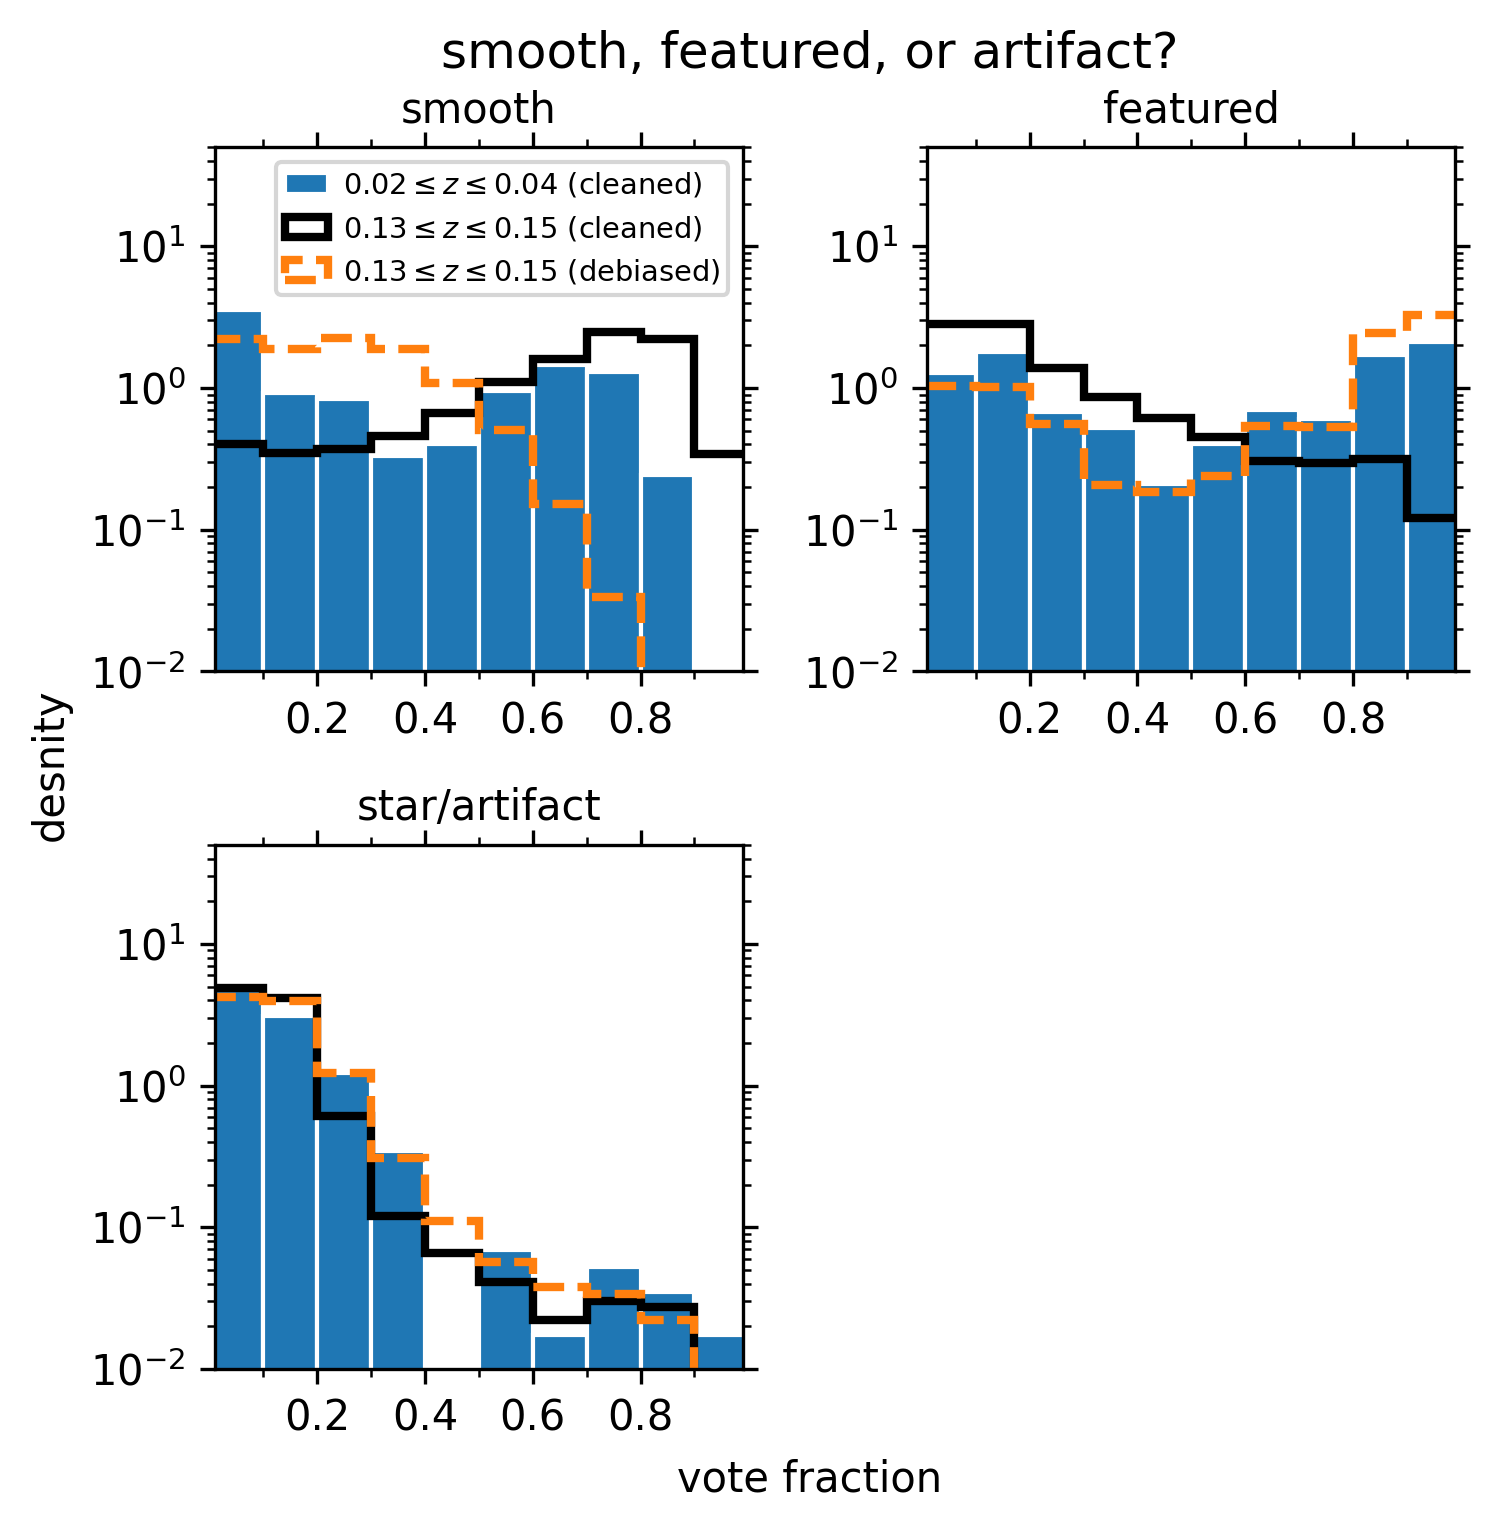

--------------------------------------------------------------------





--------------------------------------------------------------------
edge-on disk?
-------------
eligible galaxies in volume limited sample = 18350
in lo-z bin = 328
in hi-z bin = 5310


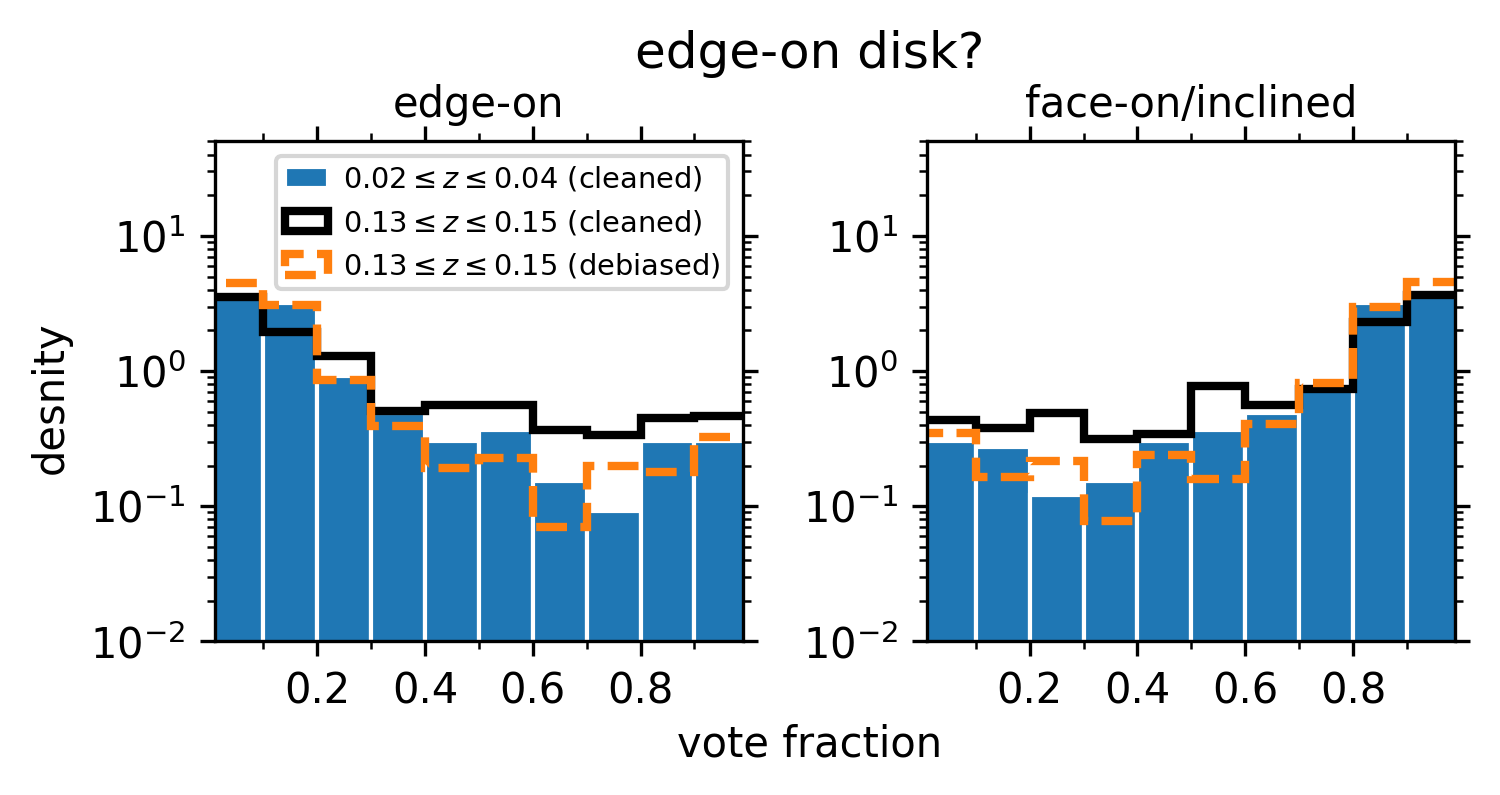

--------------------------------------------------------------------





--------------------------------------------------------------------
barred?
-------
eligible galaxies in volume limited sample = 14091
in lo-z bin = 263
in hi-z bin = 3849


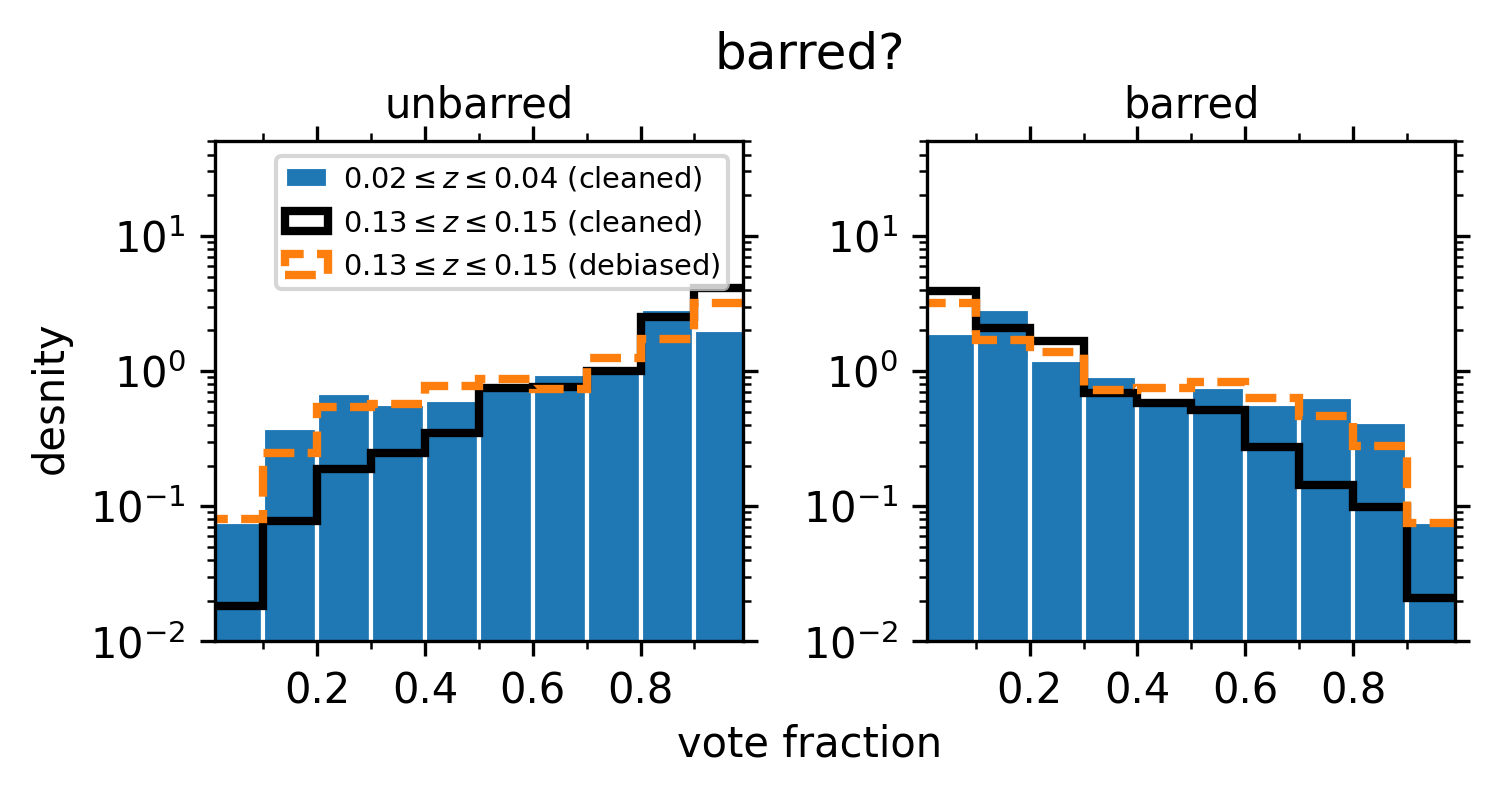

--------------------------------------------------------------------





--------------------------------------------------------------------
spiral arm pattern?
-------------------
eligible galaxies in volume limited sample = 14091
in lo-z bin = 263
in hi-z bin = 3849


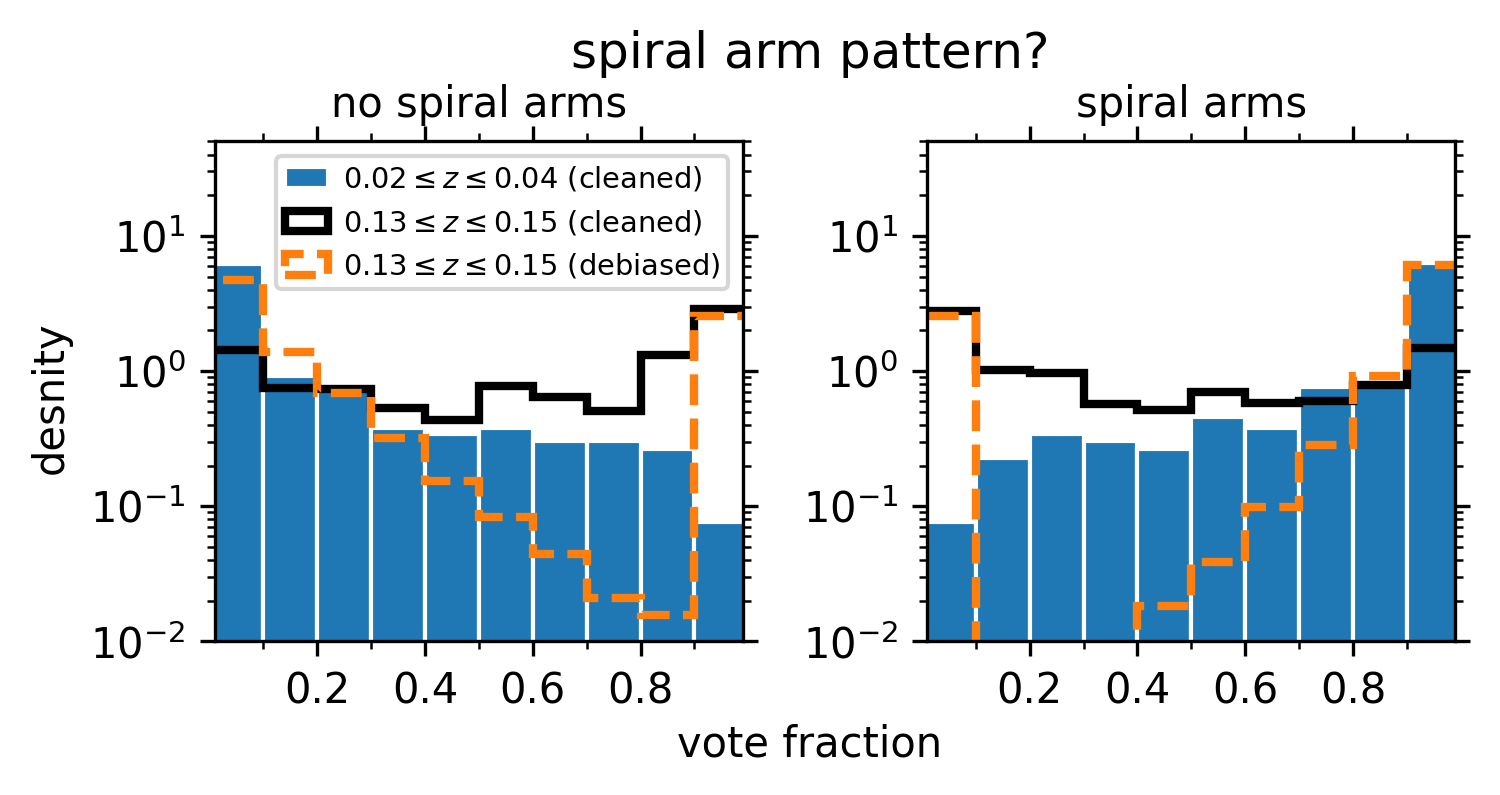

--------------------------------------------------------------------





--------------------------------------------------------------------
bulge size?
-----------
eligible galaxies in volume limited sample = 14091
in lo-z bin = 263
in hi-z bin = 3849


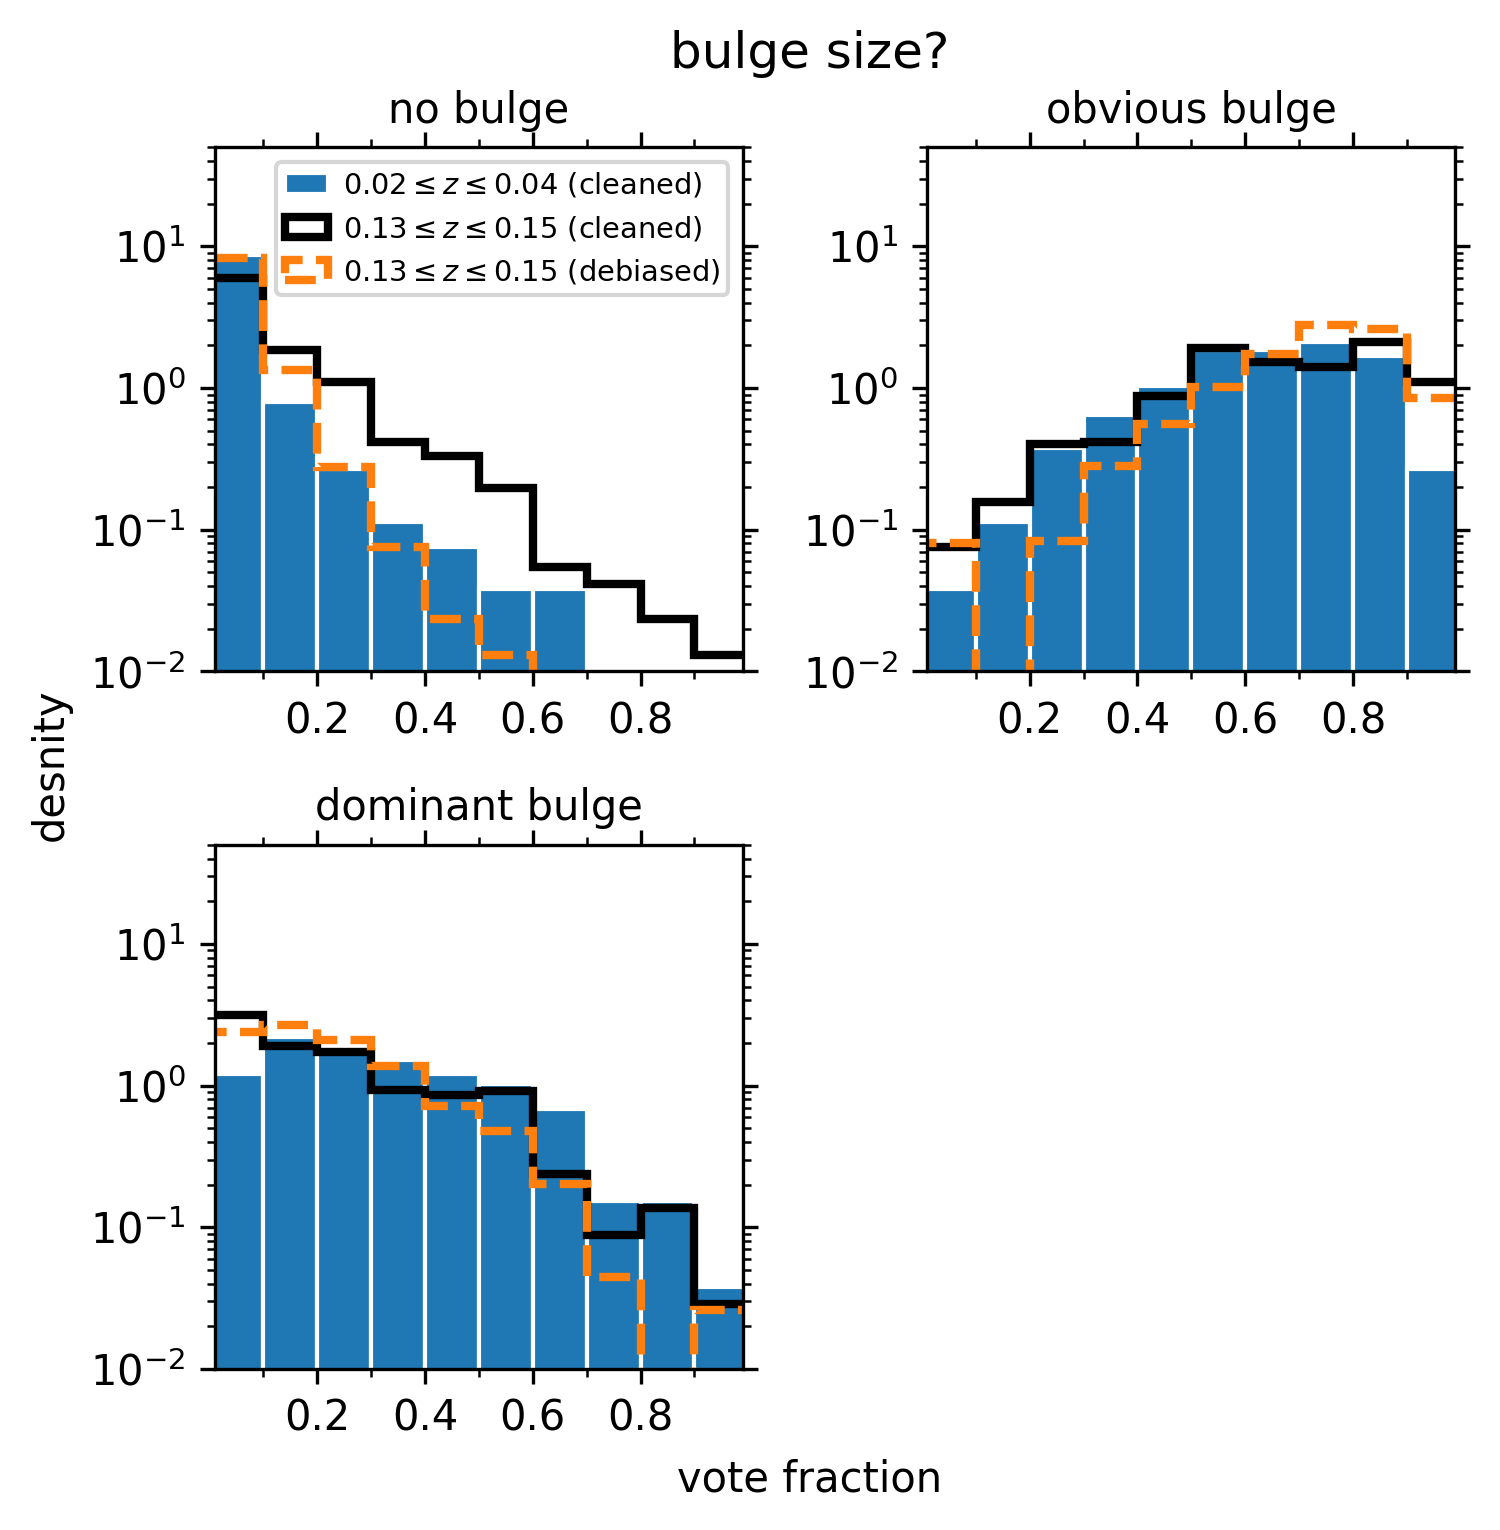

--------------------------------------------------------------------





--------------------------------------------------------------------
spiral arm winding?
-------------------
eligible galaxies in volume limited sample = 7704
in lo-z bin = 215
in hi-z bin = 1679


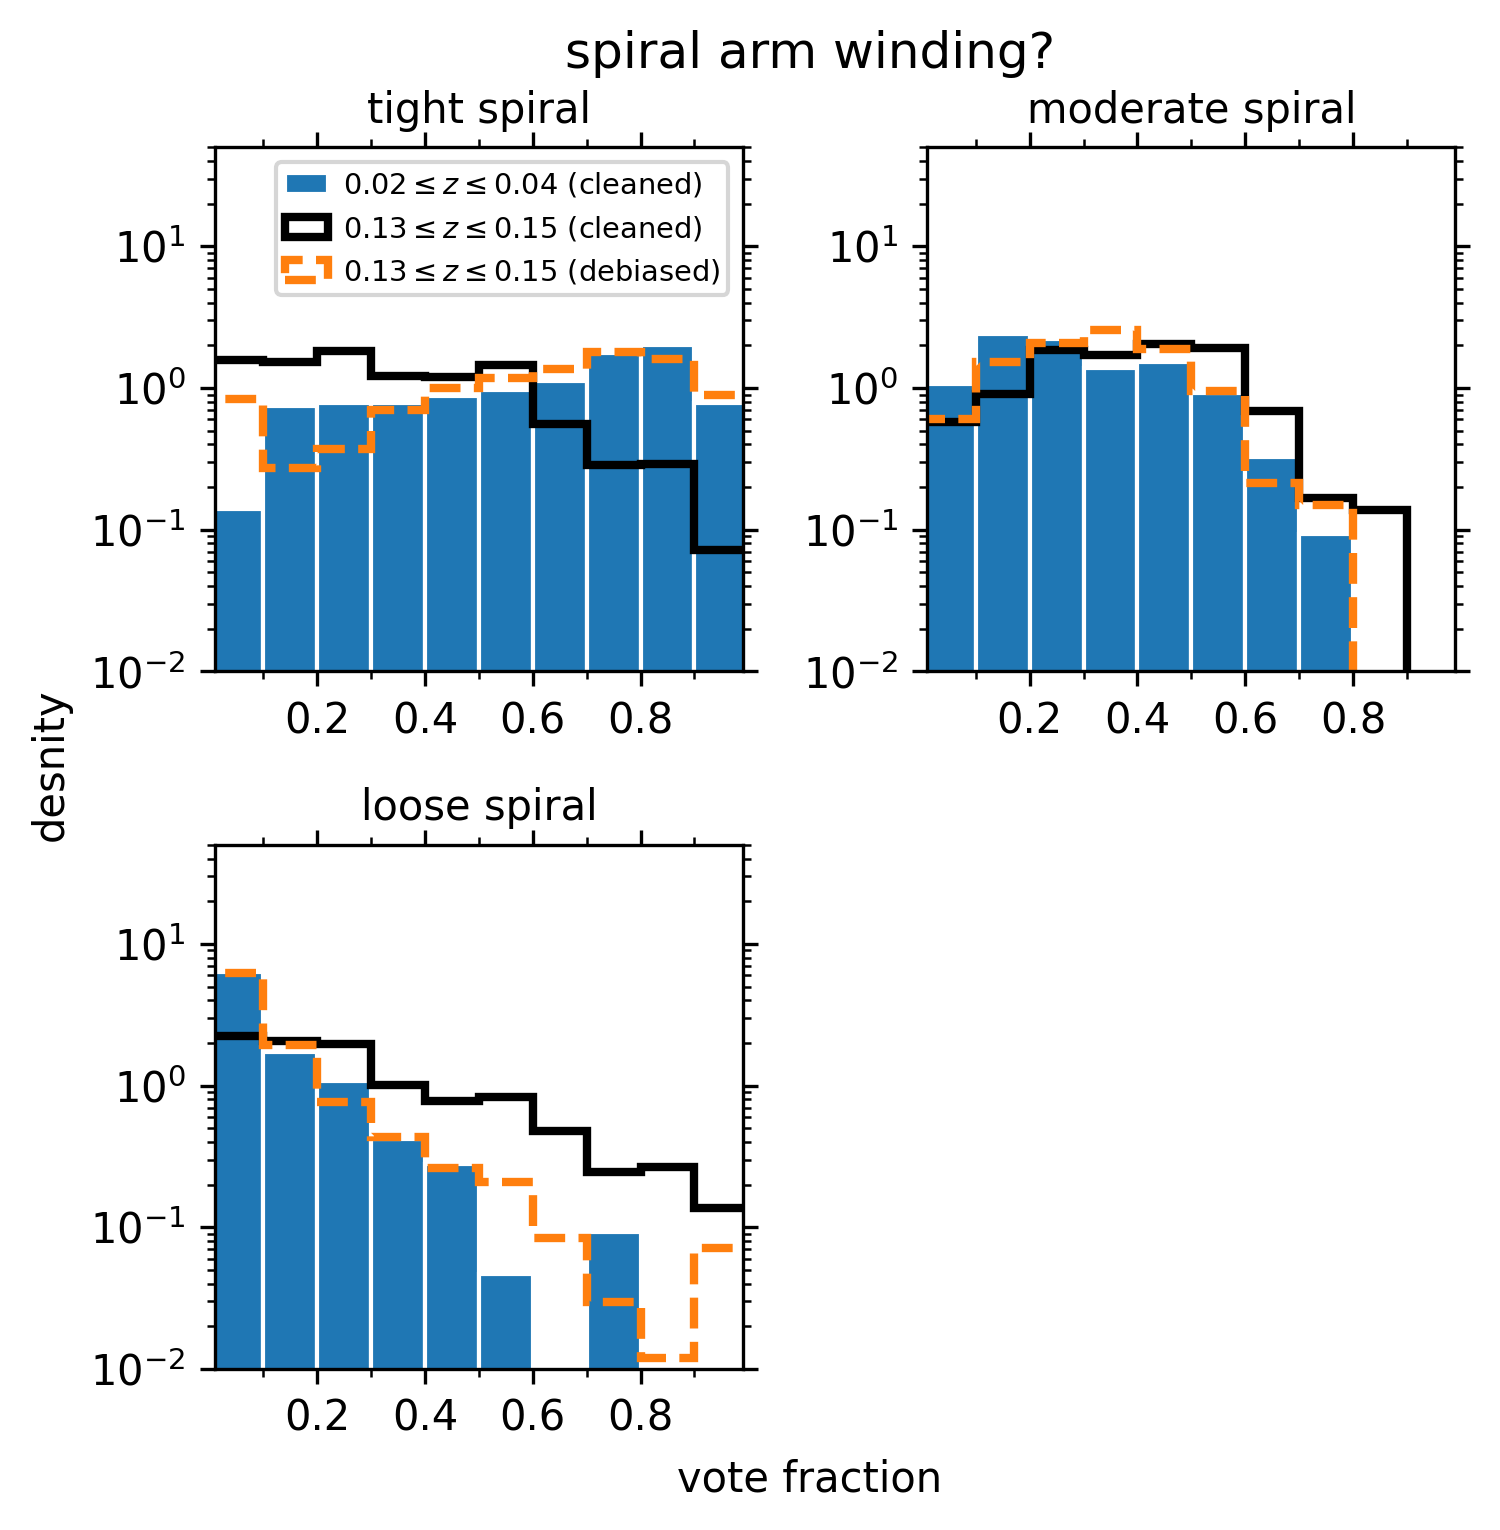

--------------------------------------------------------------------





--------------------------------------------------------------------
spiral arm number?
------------------
eligible galaxies in volume limited sample = 7704
in lo-z bin = 215
in hi-z bin = 1679


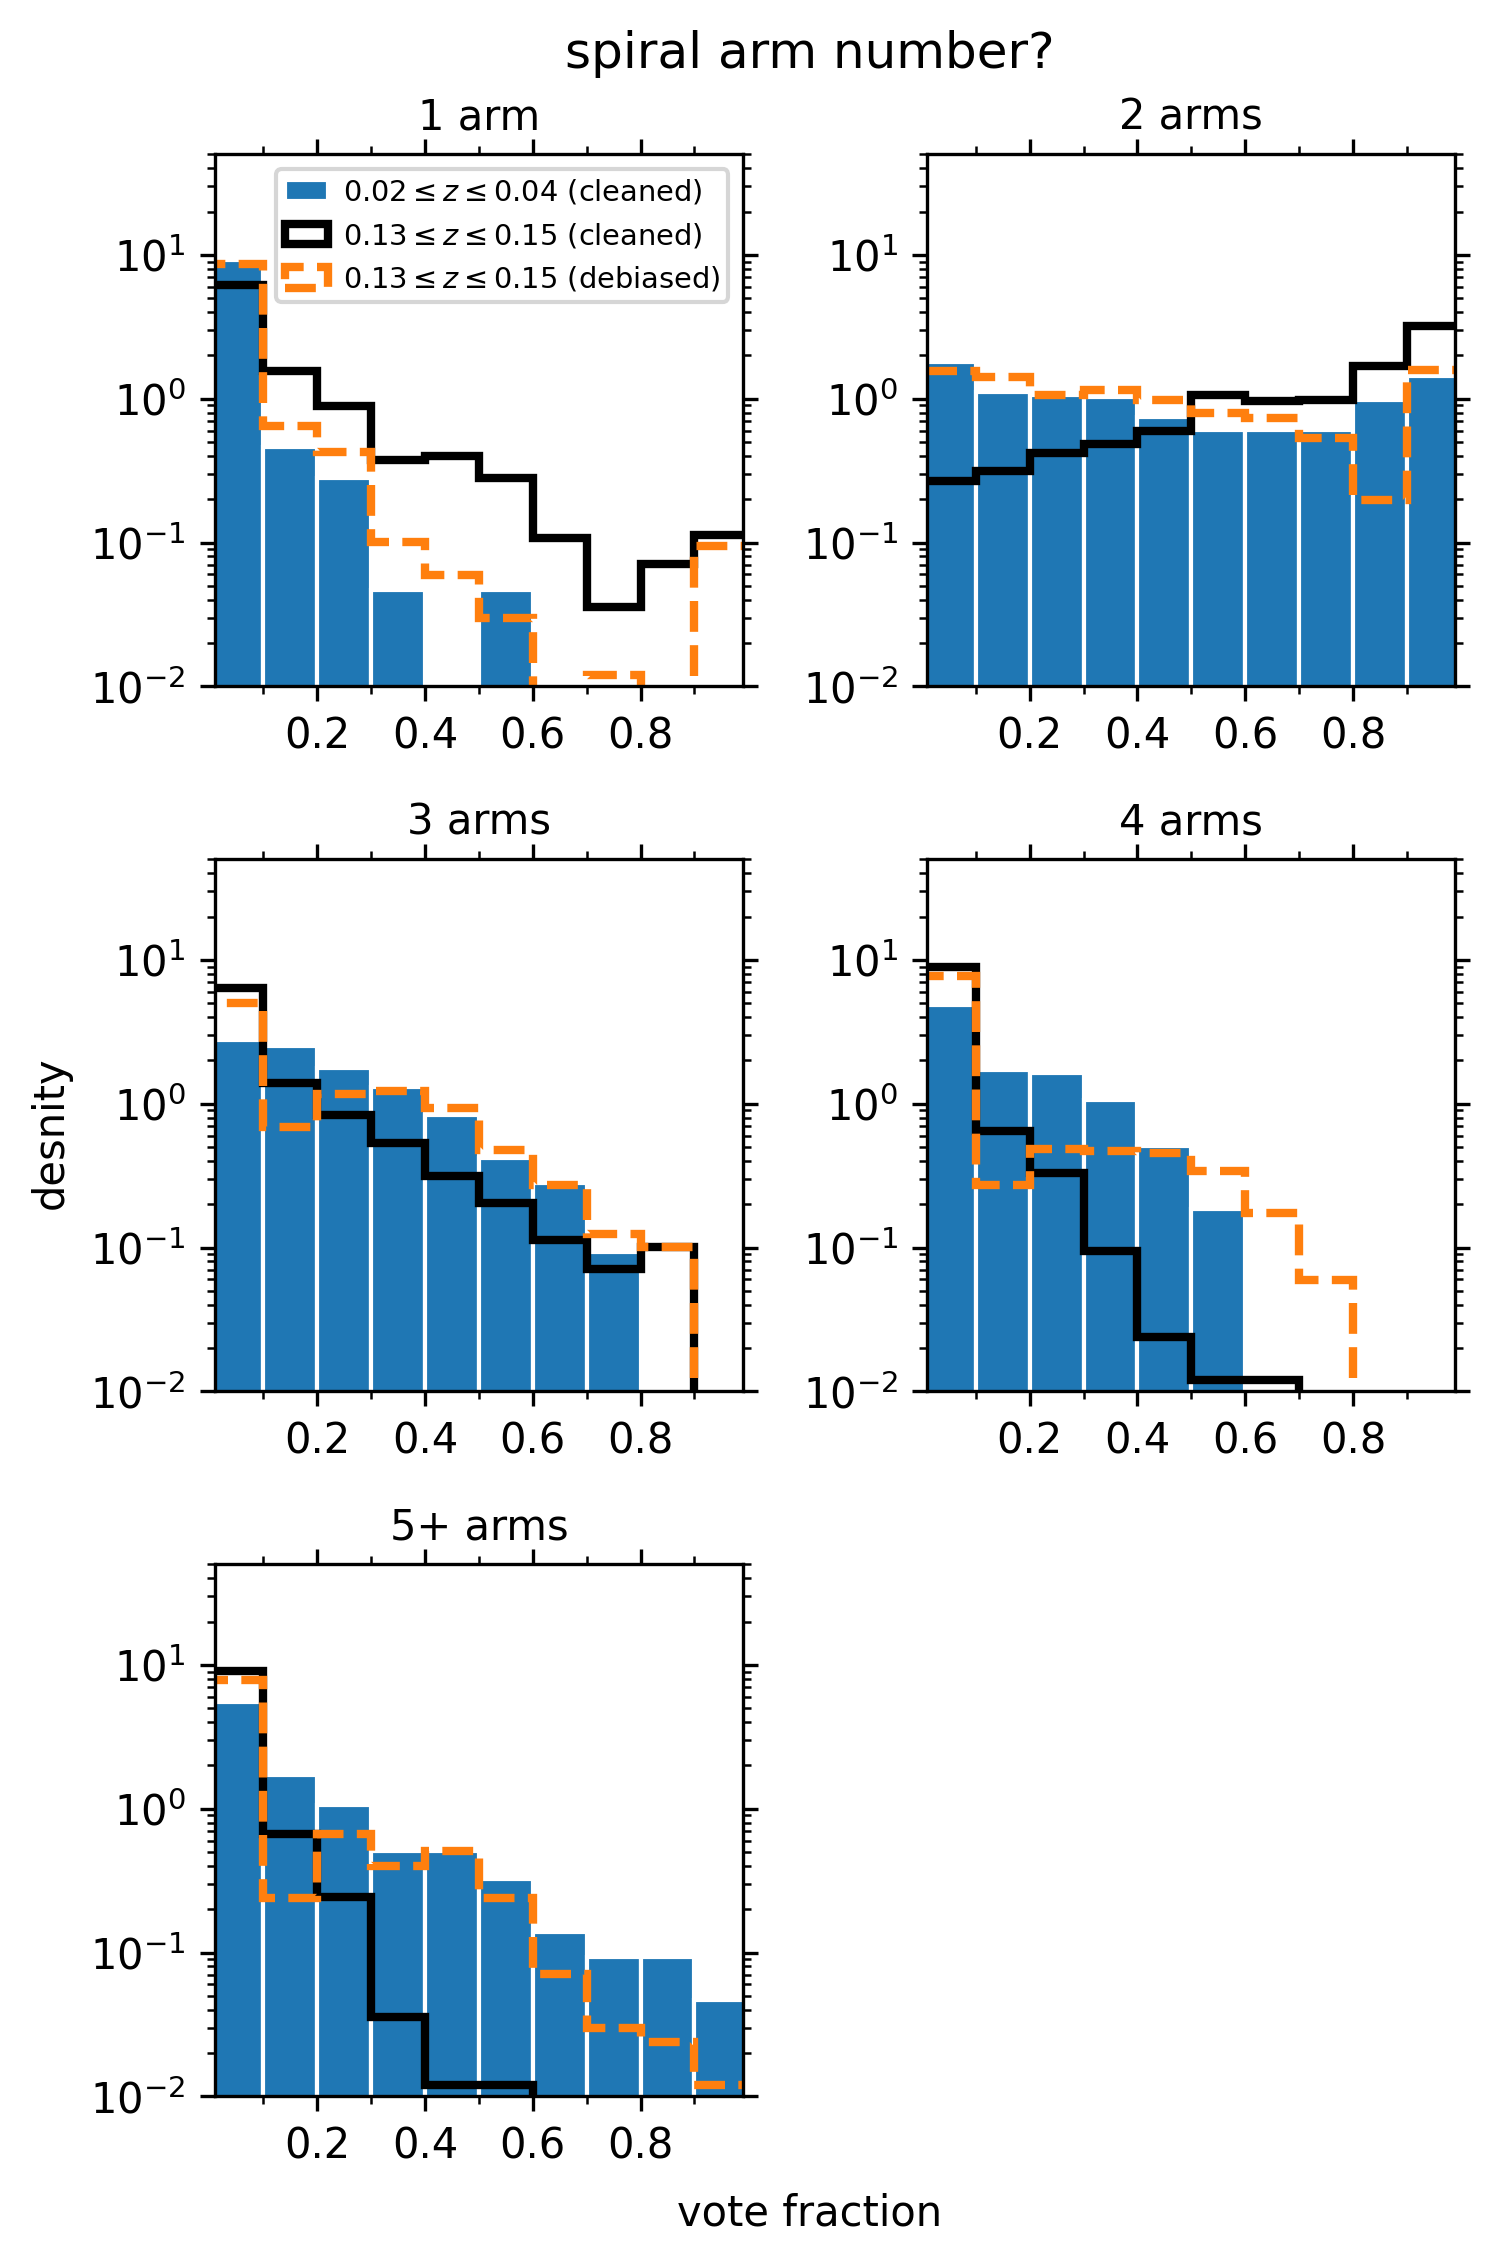

--------------------------------------------------------------------





--------------------------------------------------------------------
edge-on bulge shape?
--------------------
eligible galaxies in volume limited sample = 1523
in lo-z bin = 24
in hi-z bin = 425


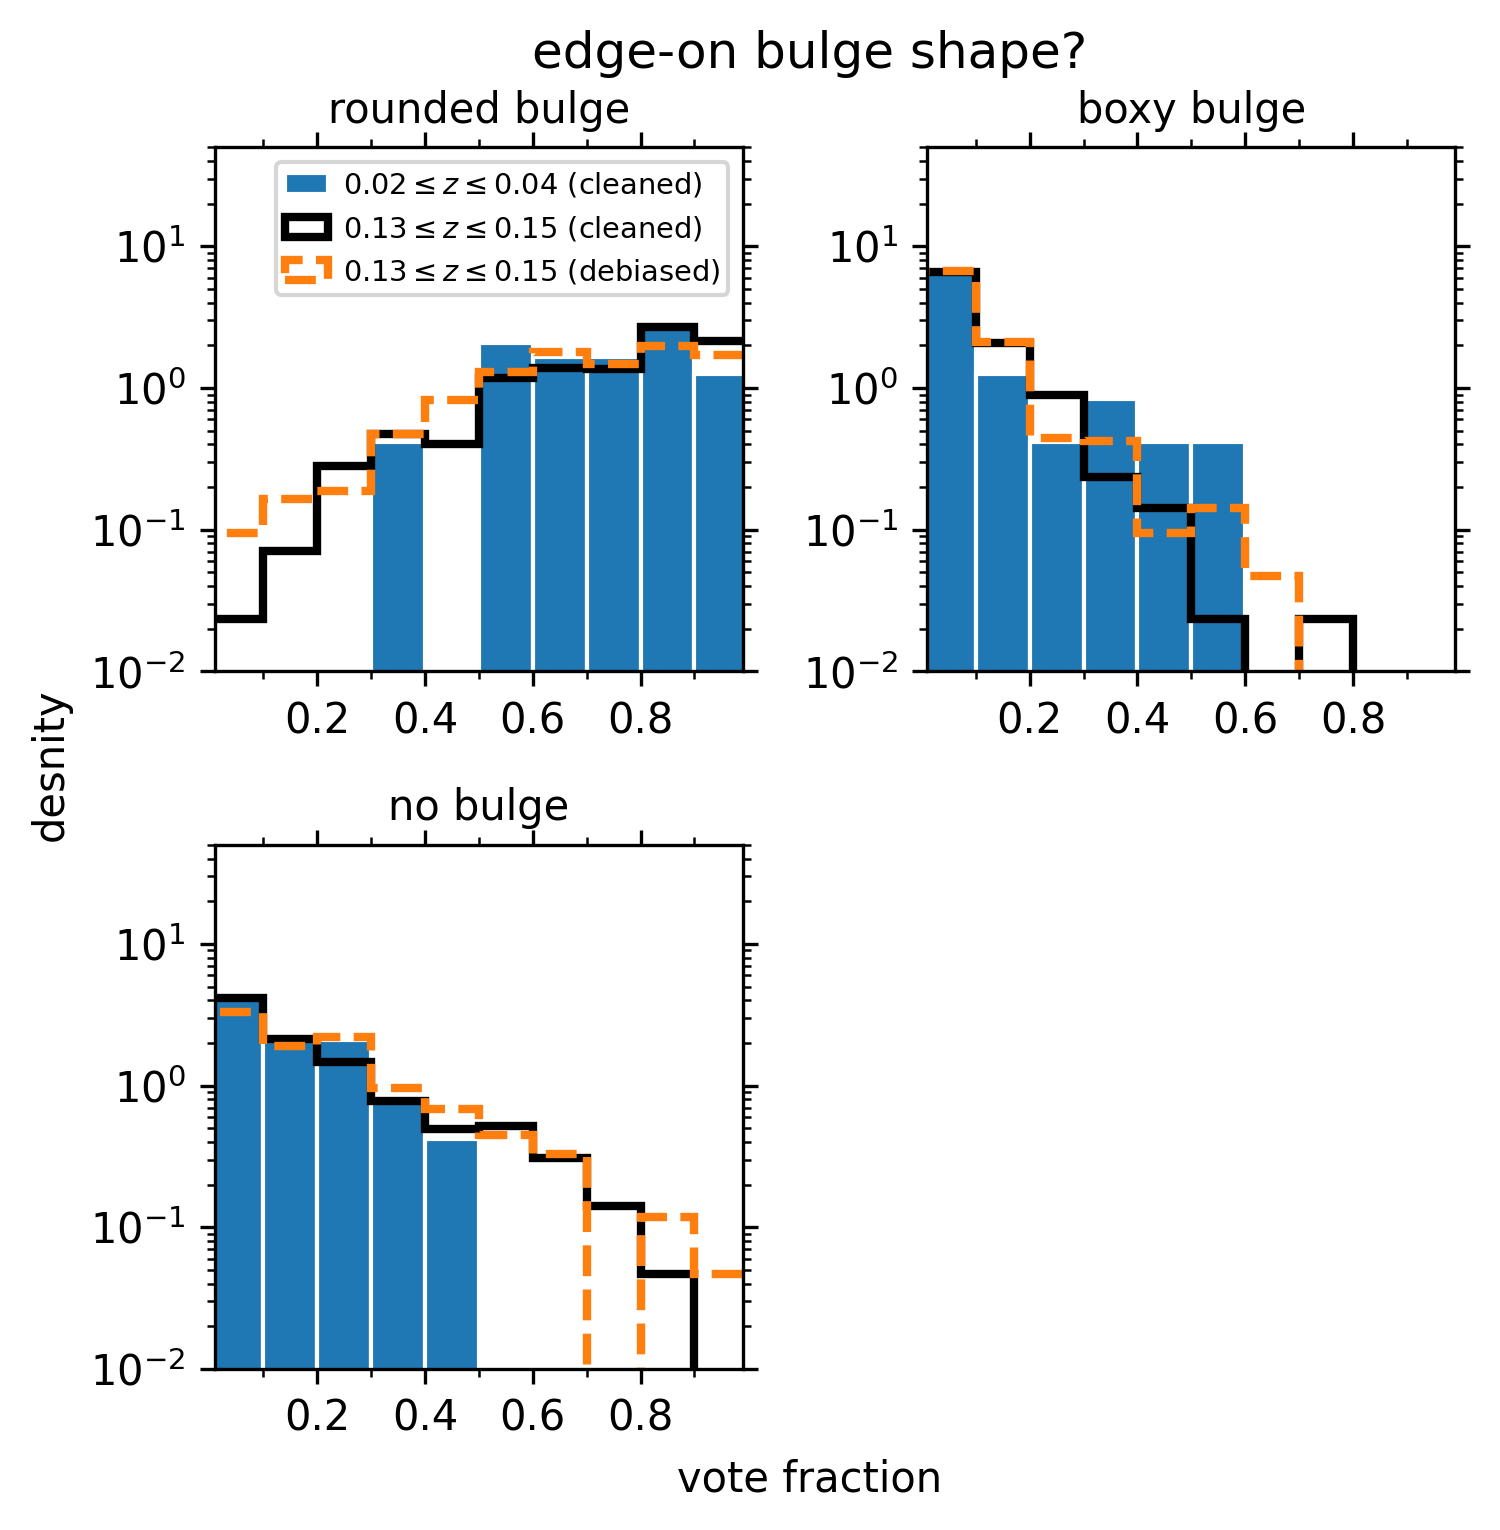

--------------------------------------------------------------------





--------------------------------------------------------------------
smooth roundedness?
-------------------
eligible galaxies in volume limited sample = 2787
in lo-z bin = 175
in hi-z bin = 669


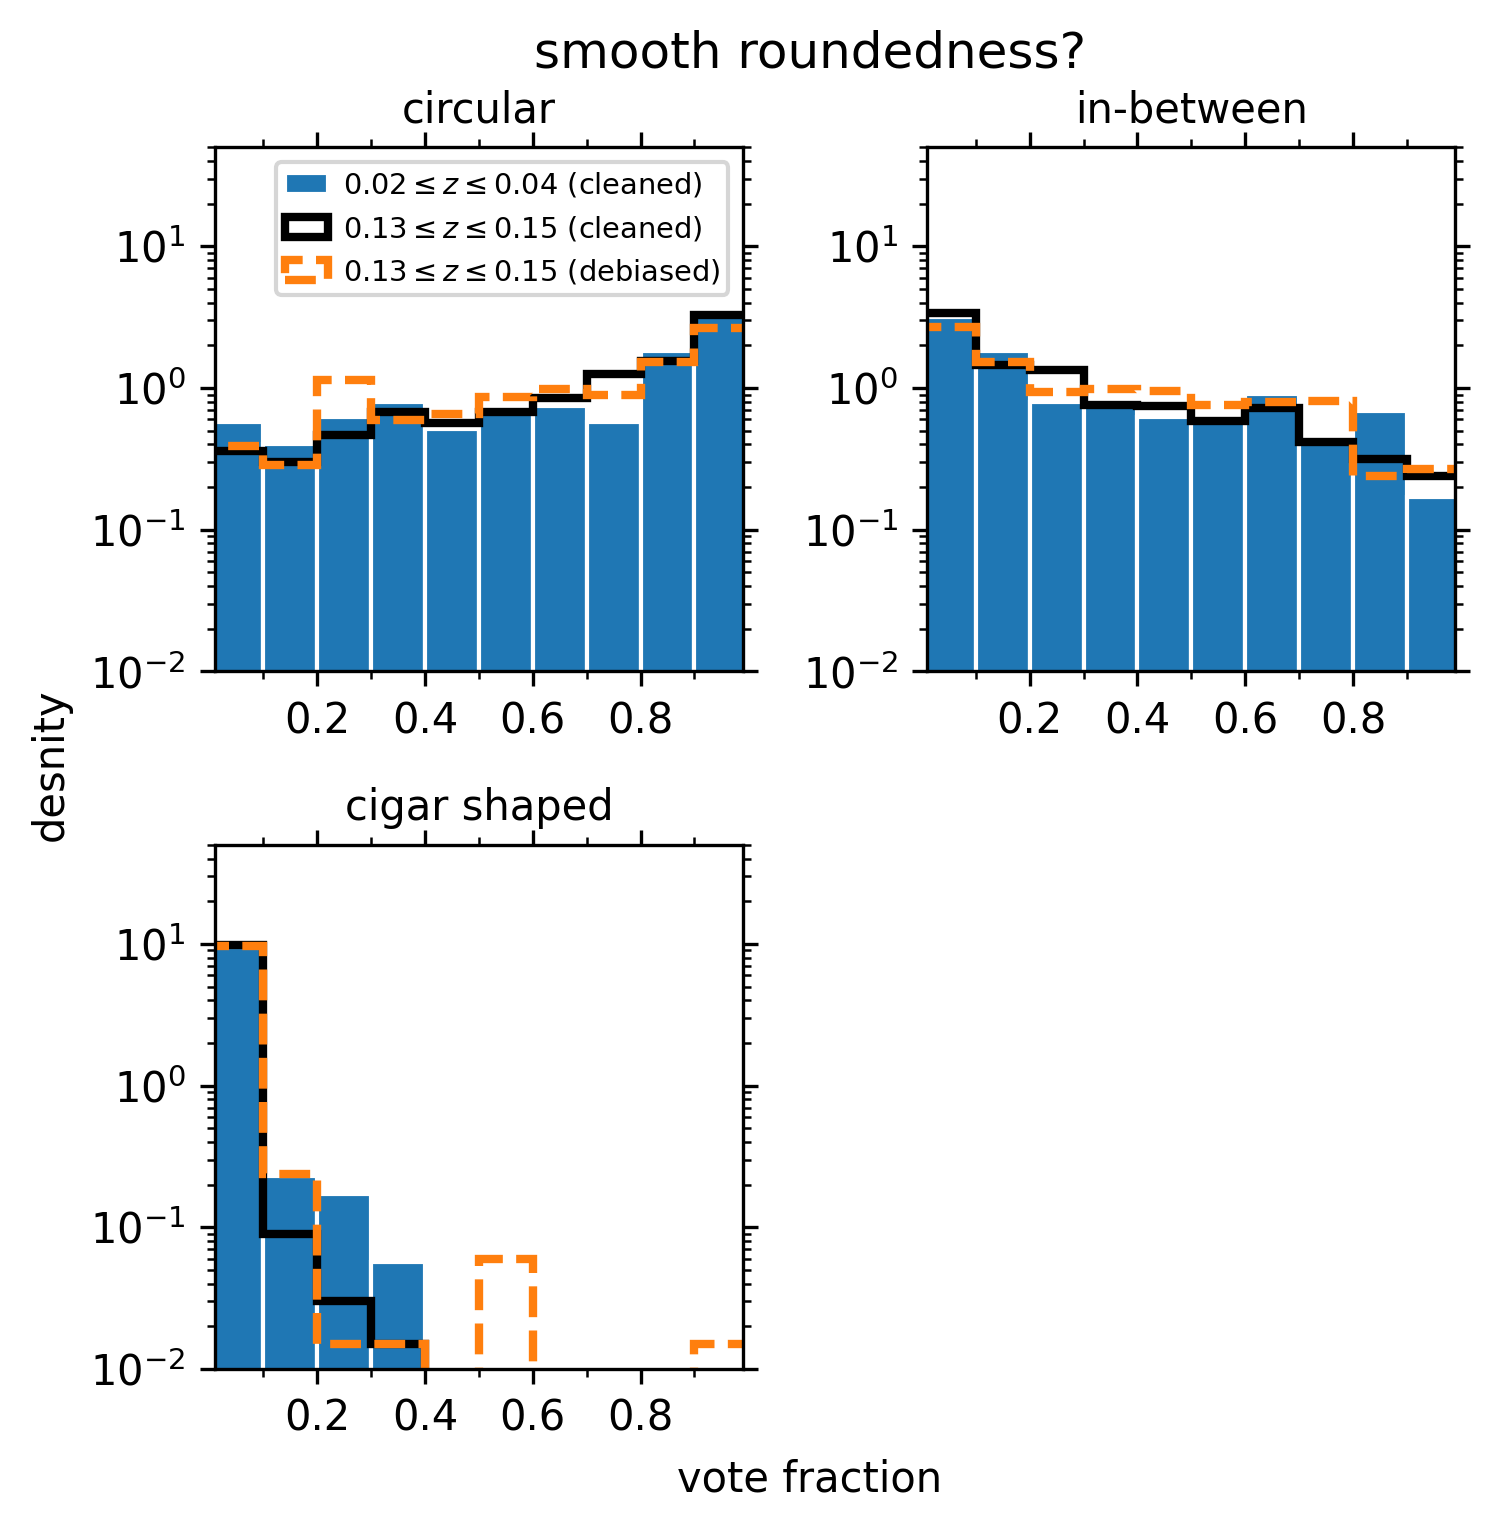

--------------------------------------------------------------------





--------------------------------------------------------------------
merging activity?
-----------------
eligible galaxies in volume limited sample = 29968
in lo-z bin = 564
in hi-z bin = 9408


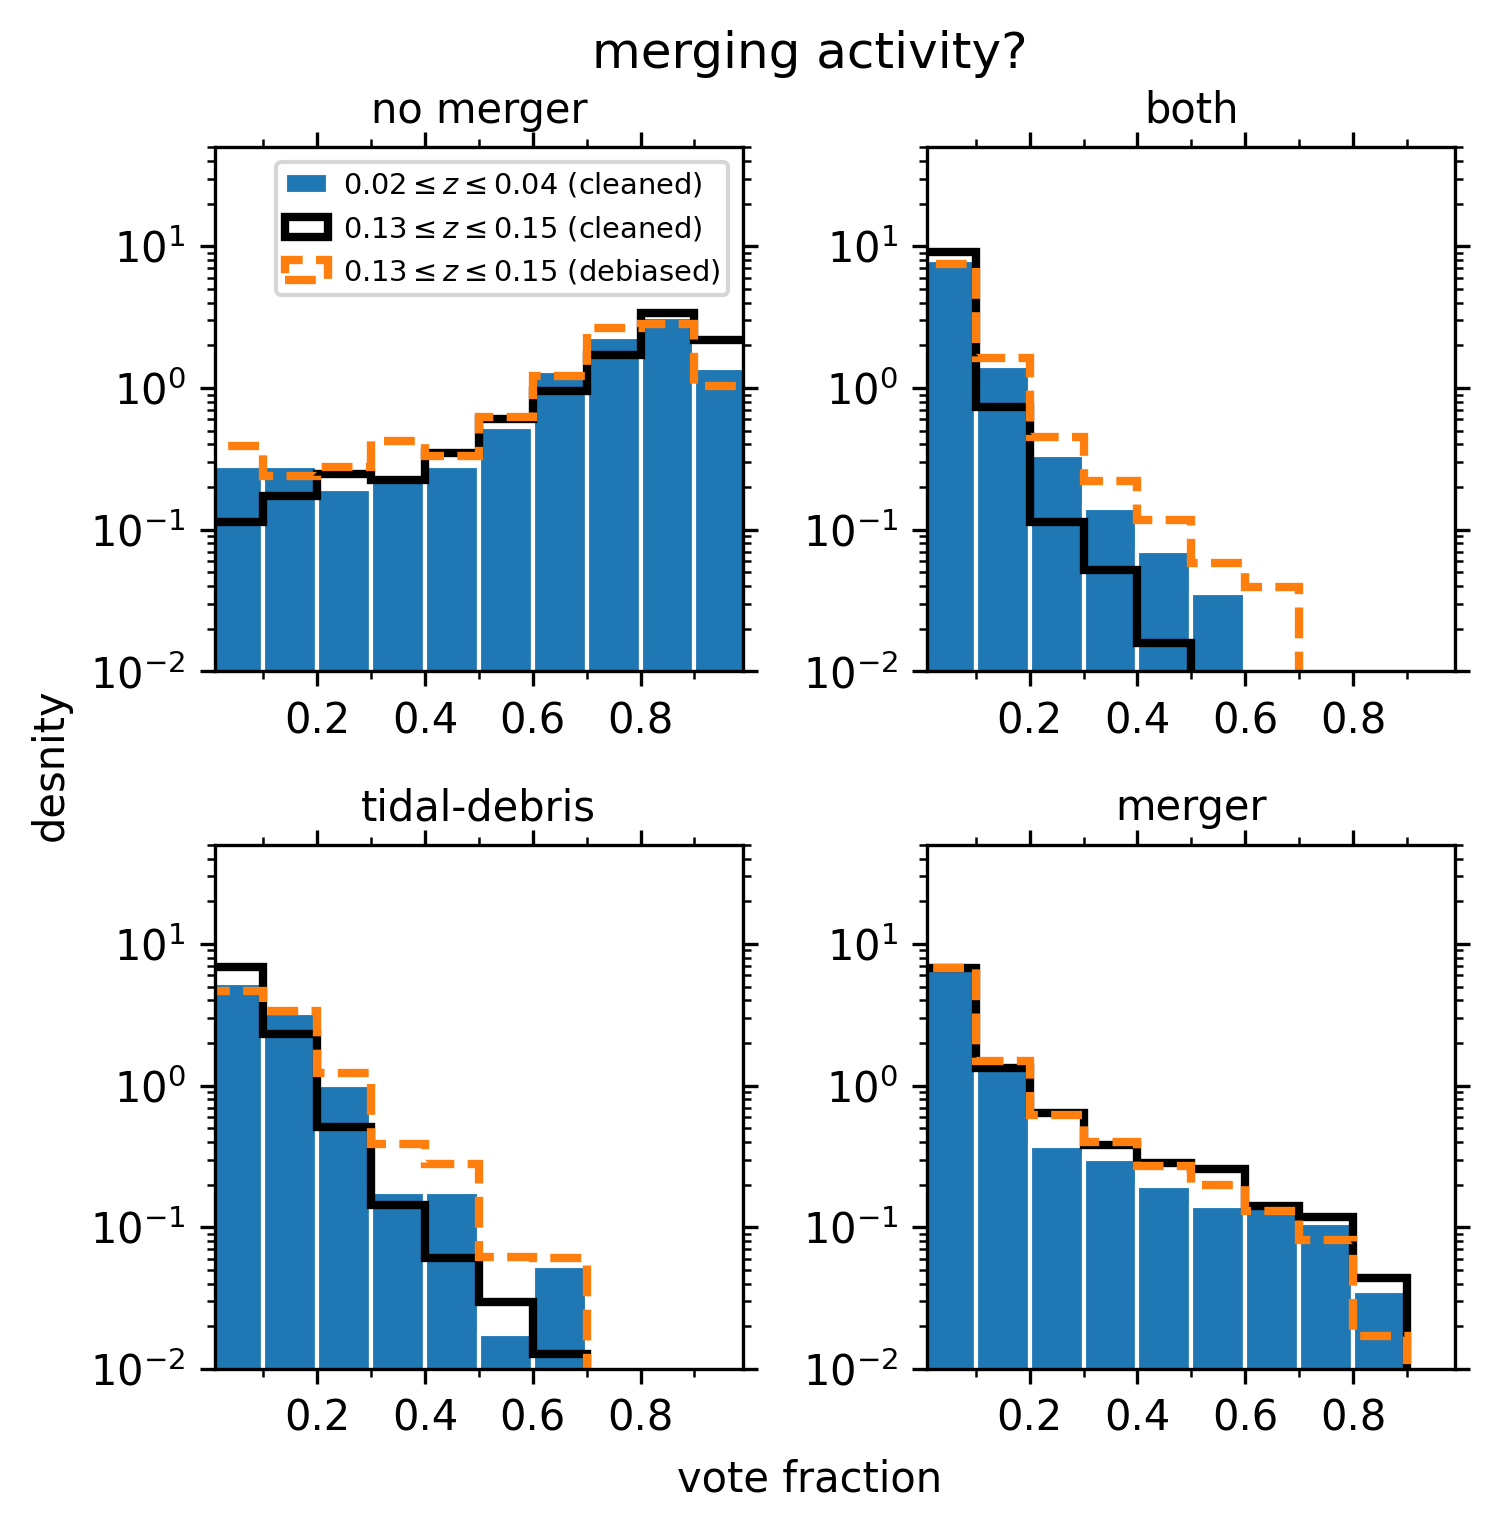

--------------------------------------------------------------------






In [57]:
# vote fraction histograms for all question/answer pairs
z = data_original[z_column]
Mr = data_original[Mr_column]
MagComplete = mag_to_Mag(survey_mag_limit,
                         np.max(volume_redshift_bounds))
in_vl = ((z >= volume_redshift_bounds[0]) &
         (z <= volume_redshift_bounds[1]) &
         (Mr > -99) & (Mr <= MagComplete))
zstep = 0.02
zbinlo = [volume_redshift_bounds[0],volume_redshift_bounds[0]+zstep]
zbinhi = [volume_redshift_bounds[1]-zstep,volume_redshift_bounds[1]]
in_loz = ((z >= zbinlo[0]) & (z <= zbinlo[1]))
in_hiz = ((z >= zbinhi[0]) & (z <= zbinhi[1]))
major_ticks = np.arange(0,1+1e-5,0.2)
label_inset = 0.03
axis_pad = 0.02
for q in list(question_dict.keys()):
    qlbl = question_dict[q]['lbl_question']
    anss = question_dict[q]['pos_answers']
    lbls = question_dict[q]['lbl_answers']
    ncols = 2
    nrows = int(np.ceil(len(anss) / ncols))
    fig, axs = plt.subplots(nrows, ncols, dpi=300,
                           figsize=(ncols*2.5, nrows*2.5))
    for ax in axs.flatten():
        ax.set_visible(False)
        ax.minorticks_on()
        ax.tick_params('x', which='both', bottom=True, top=True)
        ax.tick_params('y', which='both', left=True, right=True)
        ax.xaxis.set_minor_locator(
            matplotlib.ticker.MultipleLocator(0.1))
    for a, l, ax in zip(anss, lbls, axs.flatten()):
        cln = data_deb[f'{q}_{a}{input_frac_suffix}']
        deb = data_deb[f'{q}_{a}{output_frac_suffix}']
        qa_good = ((deb>=0)&(deb<=1)&(cln>=0)&(cln<=1)&in_vl)
        qa_good &= data_deb[f'{q}{output_priorsample_suffix}']
        cln_loz = cln[qa_good & in_loz]
        cln_hiz = cln[qa_good & in_hiz]
#         deb_loz = deb[qa_good & in_loz]
        deb_hiz = deb[qa_good & in_hiz]
        if a == anss[0]:
            print(f'\n{"-"*68}\n{qlbl}\n{"-"*len(qlbl)}\n'
                  f'eligible galaxies in volume limited sample = '
                  f'{sum(qa_good)}')
            print(f'in lo-z bin = {len(cln_loz)}\n'
                  f'in hi-z bin = {len(cln_hiz)}')
        ax.set_visible(True)
        ax.set_xticks(major_ticks)
        ax.set_yticks(major_ticks)
        cln_loz_lbl = (f'${zbinlo[0]} \leq z \leq {zbinlo[1]}$ '
                       f'(cleaned)')
        cln_hiz_lbl = (f'${zbinhi[0]} \leq z \leq {zbinhi[1]}$ '
                       f'(cleaned)')
        deb_hiz_lbl = (f'${zbinhi[0]} \leq z \leq {zbinhi[1]}$ '
                       f'(debiased)')
        ax.hist(cln_loz,bins=10,range=(0,1),density=True,log=True,
                color=cols[1], edgecolor='white', lw=1,
                label=cln_loz_lbl)
#         ax.hist(deb_loz,bins=10,range=(0,1),density=True,log=True,
#                 color=cols[0], ls='--', histtype='step', lw=2)
        ax.hist(cln_hiz,bins=10,range=(0,1),density=True,log=True,
                color='black', histtype='step', lw=2,
                label=cln_hiz_lbl)
        ax.hist(deb_hiz,bins=10,range=(0,1),density=True,log=True,
                color=cols[0], ls='--', histtype='step', lw=2,
                label=deb_hiz_lbl)
        ax.set_xlim(0+1e-2, 1-1e-2)
        ax.set_ylim(1e-2, 5e1)
        ax.text(0.5, 1+label_inset, l, ha='center', va='bottom',
                transform=ax.transAxes)
        if a == anss[0]:
            ax.legend(fontsize='x-small', handlelength=1.5,
                      labelspacing=0.5, handletextpad=0.5,
                      borderpad=0.3, frameon=True)

    fig.text(0.53, 0.99, qlbl, fontsize='large',
             ha='center', va='top', transform=fig.transFigure)
    fig.text(0.53, 0.01, 'vote fraction',
             ha='center', va='bottom', transform=fig.transFigure)
    fig.text(0.01, 0.5, 'desnity', rotation=90,
             ha='left', va='center', transform=fig.transFigure)

    plt.tight_layout(rect=[0+axis_pad, 0+axis_pad, 1, 1-axis_pad])
    plt.savefig(fname=outdir+'/votefrac_hist_'+q+'.pdf',
                dpi='figure')
    plt.show()
    plt.close()
    print(f'{"-"*68}\n\n\n\n')

## Dataset Clean Up

 * (redundant) Construct reference sample prior p columns
 * Trim final dataset of unnecessary columns
 * Write into output FITS table
 * (optional) GZIP

In [58]:
# # generate prior p column data
# (already included above - checked it matches)
# q_keys = [q for q in question_dict.keys()]
# for q in q_keys:
#     
#     # pick out question/answer info
#     rqs = question_dict[q]['req_questions']
#     ras = question_dict[q]['req_answers']
#     nas = question_dict[q]['not_answers']
#     
#     # choose only those that had pq>=0.5 and Nq>=5 for req_q/req_a
#     if rqs is not None:
#         pq = 1
#         if ras is not None:
#             for q_, a_ in zip(rqs, ras):
#                 colname = f'{q_}_{a_}{output_frac_suffix}'
#                 pq *= data_deb[colname]
#         else:
#             for q_, a_ in zip(rqs, nas):
#                 colname = f'{q_}_{a_}{output_frac_suffix}'
#                 pq *= (1 - data_deb[colname])
#         Nq = data_deb[f'{q}{input_total_suffix}']
#     else:
#         pq = 1
#         Nq = 100
#     req_good = (pq >= 0.5) & (Nq >= 5)
#     
#     # add column
#     newcolname = q + output_priorsample_suffix + '_check'
#     data_deb[newcolname] = req_good
#     data_deb[q+'_pq'] = pq

In [59]:
# remove duplicated and unnecessary columns in final catalogue
data_deb_trim = data_deb.copy()
bin_names = [c for c in data_deb_trim.colnames if 
             input_frac_suffix in c]
bad_names = (bin_names + 
             [Mr_column, R50_column, z_column] + 
             ['LOGR50'])
data_deb_trim.remove_columns(bad_names)

In [60]:
# write output catalogue and gzip
if output_cat[-3:] == '.gz':
    output_cat_TEMP = output_cat[:-3]
    if os.path.exists(output_cat_TEMP):
        os.remove(output_cat_TEMP)
    if os.path.exists(output_cat):
        os.remove(output_cat)
    data_deb_trim.write(output_cat_TEMP)
    cmd = f'gzip --best {output_cat_TEMP}'
    !{cmd}
else:
    if os.path.exists(output_cat):
        os.remove(output_cat)
    data_deb_trim.write(output_cat)

## Total Numbers Analysis

Looking at the impact of switching from multiplicative to additive p-value generation. Designed to work only with the GAMA-KiDS dataset.

In [61]:
try:
    feat_num = data_deb['features_clean_total']
    feat_featfrac = data_deb['features_features_deb_frac']
    edge_num = data_deb['edgeon_clean_total']
    edge_nofrac = data_deb['edgeon_no_deb_frac']
    spiral_num = data_deb['spiral_clean_total']
    spiral_yesfrac = data_deb['spiral_spiral_deb_frac']
    winding_num = data_deb['spiralwinding_clean_total']
    winding_tightfrac = data_deb['spiralwinding_tight_deb_frac']

    print('\nEdge-on question:')
    print(f'p criteria: feat_featfrac >= p_cut : {np.sum(feat_featfrac >= p_cut)}')
    print(f'N criteria: edge_num >= N_cut : {np.sum(edge_num >= N_cut)}')
    print(f'total out: edge_nofrac >= 0 : {np.sum(edge_nofrac >= 0)}')
    print(f'eligible (p >= p_cut) & (edge_num >= N_cut): {np.sum((feat_featfrac >= p_cut) & (edge_num >= N_cut))}')

    print('\nSpiral question:')
    print(f'p criteria mul: feat_featfrac * edge_nofrac >= p_cut: {np.sum(feat_featfrac * edge_nofrac >= p_cut)}')
    print(f'p criteria add: (feat_featfrac >= p_cut) & (edge_nofrac >= p_cut): {np.sum((feat_featfrac >= p_cut) & (edge_nofrac >= p_cut))}')
    print(f'N criteria: spiral_num >= N_cut : {np.sum(spiral_num >= N_cut)}')
    print(f'total out: spiral_yesfrac >= 0 : {np.sum(spiral_yesfrac >= 0)}')
    print(f'eligible mul: (p >= p_cut) & (spiral_num >= N_cut) : {np.sum((feat_featfrac * edge_nofrac >= p_cut) & (spiral_num >= N_cut))}')
    print(f'eligible add: (p >= p_cut) & (spiral_num >= N_cut) : {np.sum((feat_featfrac >= p_cut) & (edge_nofrac >= p_cut) & (spiral_num >= N_cut))}')

    print('\nSpiral winding question:')
    print(f'p criteria mul: feat_featfrac * edge_nofrac * spiral_yesfrac >= p_cut: {np.sum(feat_featfrac * edge_nofrac * spiral_yesfrac >= p_cut)}')
    print(f'p criteria add: (feat_featfrac >= p_cut) & (edge_nofrac >= p_cut) & (spiral_yesfrac >= p_cut): {np.sum((feat_featfrac >= p_cut) & (edge_nofrac >= p_cut) & (spiral_yesfrac >= p_cut))}')
    print(f'N criteria: winding_num >= N_cut : {np.sum(winding_num >= N_cut)}')
    print(f'total out: winding_tightfrac >= 0 : {np.sum(winding_tightfrac >= 0)}')
    print(f'eligible mul: (p >= p_cut) & (winding_num >= N_cut) : {np.sum((feat_featfrac * edge_nofrac * spiral_yesfrac >= p_cut) & (winding_num >= N_cut))}')
    print(f'eligible add: (p >= p_cut) & (winding_num >= N_cut) : {np.sum((feat_featfrac >= p_cut) & (edge_nofrac >= p_cut) & (spiral_yesfrac >= p_cut) & (winding_num >= N_cut))}')
except:
    pass

## Conclusions

This notebook successfully debiases input Galaxy Zoo data using procedures derived from Hart et al. 2016. Final results are presented in the figures above, with original (cleaned/user-weighted) data shown using solid lines, and debiased data shown using dotted lines.

In [62]:
# Notebook finish up
nbt1 = time.time()
nbt1str = time.strftime(nbtf, time.localtime(nbt1))
nbtd = nbt1-nbt0
nbtdstr = time.strftime('%H:%M:%S', time.gmtime(nbtd))
print(f'Notebook end time: \n   {nbt1str} (elapsed: {nbtdstr})')
#--------------------------------68-------------------------------->

Notebook end time: 
   2021-06-14 11:34:35 CEST (elapsed: 00:17:52)
